In [1]:
import numpy as np 
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
from numpy.linalg import norm,inv,eig
import sys
from scipy import stats
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.ensemble import RandomForestRegressor
from sub_dist_functions import get_eigs, get_radii, random_rotation,rotate,transform

#import numexpr as ne
#import scipy
#from scipy.optimize import minimize_scalar
#from helpers.io_utils import hlist2pandas
#from mpl_toolkits import mplot3d
from matplotlib import cm, colors
#import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
#from mpl_toolkits.mplot3d import Axes3D
#import random
#import glob
#import plotly
#import plotly.graph_objs as go
#plotly.offline.init_notebook_mode()
%config InlineBackend.figure_format='retina'


In [2]:
halo_names = []
host_ids = []
rvirs = []
mvirs = []
vmaxs = []

with open('halos_info.txt') as f:
    for l in f:
        this_halo, host_id, block, _ = l.split()
        halo_names.append(this_halo)
        host_ids.append(host_id)
        hostvalues = ascii.read('/Users/lmezini/proj_2/Halos_Recalculated/{}/out_0.list_final'.format(this_halo),format = 'commented_header')
        rvirs.append(hostvalues['host_rvir'][0])
        mvirs.append(hostvalues['host_mvir'][0])
        vmaxs.append(hostvalues['vmax'][0])


rhap_halo_names = []
#host_ids = []
#rvirs = []
#mvirs = []
with open('halos_info_2.txt') as f:
    for l in f:
        this_halo, host_id, block, _ = l.split()
        rhap_halo_names.append(this_halo)



In [3]:
rhap_halo_names.remove(rhap_halo_names[46])

In [4]:
def MC_err(pdf_type, n, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0):
    if pdf_type == "uniform":
        cdfs = np.zeros((n_rep,n))
        for i in range(n_rep):
            cdfs[i]+=np.sort(np.random.uniform(val_min1, val_max1, n))
            cdfs[i][0] = 0.0
            cdfs[i][n-1] = 1.0
        err = np.std(cdfs,axis=0)
        percentiles = np.percentile(cdfs,[15.9,84.1],axis=0)
        return cdfs,err,percentiles
    
    if pdf_type == "random":
        spears = np.zeros(n_rep)
        for i in range(n_rep):
            pdfs1 = val_min1 + np.random.random(n)*val_max1
            pdfs2 = val_min2 + np.random.random(n)*val_max2
            spears[i]+=stats.spearmanr(pdfs1,pdfs2).correlation
        err = np.std(spears)
        
        return spears, err

def bs_mass_frac_err(mass_frac_arr,n_boot,n_samp,p1=15.9,p2=84.1):
    n_rad, n_halos = np.shape(mass_frac_arr)
    boot_vals = np.zeros((n_boot,n_samp, n_rad))
    for i in range(n_boot):
        for j in range(n_samp):
            indx = random.randint(0, n_halos)
            boot_vals[i][j]+=mass_frac_arr.T[indx]
    meds = np.median(boot_vals,axis=1)
    percentiles = np.percentile(meds,[p1,p2],axis=0)
    
    return percentiles

def bs_cumul_plot_err(angs, n_boot, n_samp, n_cumul_angs = 50, p1=15.9,p2=84.1):
    n_halos = len(angs)
    seq = np.arange(0,n_halos,1)
    boot_vals = np.zeros((n_boot,n_samp,n_cumul_angs))
    for i in range(n_boot):
        for j in range(n_samp):
            indx = random.choices(seq,k=95)
            boot_vals[i][j]+=get_cumul_angles(angs[indx],num=n_cumul_angs)[1]
            
    meds = np.median(boot_vals,axis=1)
    percentiles = np.percentile(meds,[p1,p2],axis=0)

    return percentiles


In [5]:
def check_ortho(evect):
    #check if eigen vectors of inertia tensor are orthonormal
    #create indentity matrix
    
    a = np.zeros((3, 3))
    np.fill_diagonal(a, 1.)

    #take dot product of v and v.T
    #off diagonals are usually 1e-15 so round them to 0.
    m = np.abs(np.round(np.dot(evect,evect.T),1))

    #check if all elements are equal to identity matrix
    if np.any(a != m):
        print("not orthonormal")
        sys.exit(1)
    
def get_axis(w):
    #return axis ratios
    a,b,c = w
    s = c/a
    q = b/a
    
    return s,q


def random_rotation(I,pos):
    np.random.seed()
    tx=np.random.random()*90.0
    ty=np.random.random()*90.0
    tz=np.random.random()*90.0

    new_I = rotate(I,tx,ty,tz)
    new_pos = transform(pos,new_I).T
    para = np.zeros(np.shape(new_pos))
    perp = np.zeros(np.shape(new_pos))
    p = np.zeros(len(new_pos))
    t = np.zeros(len(new_pos))
    hA = new_I[0]
    hB = new_I[1]
    
    for i in range(len(new_pos)):
        para[i]+=np.dot(new_pos[i],hA/norm(hA))*(hA/norm(hA))
        perp[i]+=new_pos[i]-para[i]
        t[i]+=np.arccos(np.dot(new_pos[i],hA)/(norm(new_pos[i])*norm(hA)))
        p[i]+=np.arccos(np.dot(perp[i],hB)/(norm(hB)*norm(perp[i])))
    r = np.sqrt(np.sum(perp**2,axis=1))

    return r

def rotation_err(true_frac,I_arr,pos_arr,h_rvir,h_mass,s_mass,n,n_rep=1000):
    corrs = np.zeros(n_rep)
    fracs = np.zeros((n_rep,n))
    for j in range(n_rep):
        for i in range(n):
            r = random_rotation(I_arr[i],pos_arr[i])
            frac = np.sum(s_mass[i][r<0.0003*h_rvir[i]])/h_mass[i]
            fracs[j][i]+=frac
        corrs[j]+=stats.ks_2samp(fracs[j],true_frac)[0]

    return np.std(corrs)

def rotation_err_bs(true_frac,rand_frac,n,n_rep=1000,test_type='ks_2samp'):
    corrs = np.zeros(n_rep)
    for i in range(n_rep):
        rand = np.random.choice(rand_frac, n, replace=True)
        if test_type == 'ks_2samp':
            corrs[i]+=stats.ks_2samp(true_frac,rand)[0]
        elif test_type == 'mannwhitneyu':
            corrs[i]+=stats.mannwhitneyu(true_frac,rand)[0]

    return corrs

def rotation_err_bs_2(rand_frac,n,n_rep=1000):
    vals = np.zeros(n_rep)
    for i in range(n_rep):
        rand = np.random.choice(rand_frac, n, replace=True)
        vals[i]+=np.median(np.log10(rand))

    return vals, np.std(vals)

def rotation_err_bs_3(I_arr,pos_arr,s_mass,h_rvir,h_mass,r_cut,n,n_rep=1000):
    fracs = np.zeros((n_rep,n))
    for j in range(n_rep):
        for i in range(n):
            r = random_rotation(I_arr[i],pos_arr[i])
            frac = np.sum(s_mass[i][r<r_cut*h_rvir[i]])/h_mass[i]
            fracs[j][i]+=frac

    #std1 = np.std(np.median(np.log10(fracs),axis=1))
    std2 = np.std(np.median(fracs,axis=1))
    percentiles1 = np.percentile(np.log10(np.median(fracs,axis=1)),[15.9,84.1])
    percentiles2 = np.percentile(np.median(fracs,axis=1),[15.9,84.1])

    return std2,percentiles1,percentiles2

def pearsonr_err(n, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0):

    prsnr = np.zeros(n_rep)
    for i in range(n_rep):
        pdfs1 = val_min1 + np.random.random(n)*val_max1
        pdfs2 = val_min2 + np.random.random(n)*val_max2
        prsnr[i]+=stats.pearsonr(pdfs1,pdfs2)[0]
    err = np.std(prsnr)
        
    return err

In [6]:
def get_cumul_angles(angles,num=150,min_val = 1.):
    angle_arr = np.linspace(min_val,1,num)
    cumul_angles = np.zeros((num))
    for j in range(len(angle_arr)):
        cut = angles<=angle_arr[j]
        cumul_angles[j] += len(angles[cut])/len(angles)

    return angle_arr,cumul_angles

In [7]:
mwm_90_mass_scale = np.load('mw_90mass_scale.npy')
mwm_70_mass_scale = np.load('mw_70mass_scale.npy')
mwm_50_mass_scale = np.load('mw_50mass_scale.npy')
mwm_25_mass_scale = np.load('mw_25mass_scale.npy')

rhap_70_mass_scale = np.load('rhapsody_70mass_scale.npy')
rhap_70_mass_scale  = np.delete(rhap_70_mass_scale,46)
rhap_90_mass_scale = np.load('rhapsody_90mass_scale.npy')
rhap_90_mass_scale  = np.delete(rhap_90_mass_scale,46)
rhap_50_mass_scale = np.load('rhapsody_50mass_scale.npy')
rhap_50_mass_scale  = np.delete(rhap_50_mass_scale,46)
rhap_25_mass_scale = np.load('rhapsody_25mass_scale.npy')
rhap_25_mass_scale  = np.delete(rhap_25_mass_scale,46)
rhap_99_mass_scale = np.load('rhapsody_99mass_scale.npy')
rhap_99_mass_scale  = np.delete(rhap_99_mass_scale,46)

In [8]:
names =['scale','ID','desc_scale','desc_id','num_prog','pid','upid','desc_pid',
    'phantom','sam_mvir','Mvir','Rvir','Rs', 'vrms', 'mmp', 'scale_of_last_MM',
    'Vmax', 'X','Y','Z','VX','VY','VZ','JX','JY','JZ','Spin','Breadth_first_ID',
    'Depth_first_ID','Tree_root_ID','Orig_halo_ID','Snap_num',
    'Next_coprogenitor_depthfirst_ID','Last_progenitor_depthfirst_ID',
    'Rs_Klypin','Mvir_all','M200b','M200c','M500c','M2500c','Xoff','Voff',
    'spin_bullock','b_to_a','c_to_a','A[x]','A[y]','A[z]','b_to_a(500c)',
    'c_to_a(500c)','A[x](500c)','A[y](500c)','A[z](500c)','T/|U|','Macc',
    'Mpeak','Vacc','Vpeak','Halfmass_Scale','Acc_Rate_Inst','Acc_Rate_100Myr',
    'Acc_Rate_Tdyn']

In [9]:
def get_angle(v1,v2):
    c = np.dot(v1,v2)/(norm(v1)*norm(v2)) # -> cosine of the angle
    #angle = np.arccos(np.clip(c, -1, 1))
    #angles = angle*180/np.pi
    return c

def get_angles(v1,v2,num):
    angles=np.zeros(num)
    
    for i in range(num):
        angles[i]+=get_angle(v1[i],v2[i])
    return angles

def get_angles_1vect(v1,v2,num):
    angles=np.zeros(num)
    
    for i in range(num):
        angles[i]+=get_angle(v1[i],v2)
    
    return angles

In [10]:
def get_ang_moment(masses,r,v):
    #calculate angular momentum for all subhalos
    L = np.sum(masses*np.cross(r,v).T,axis=1)
    #print("L = {}".format(L))
    return L


In [11]:
#halo_names = []
#host_ids = []
hlist_host_ids = []
with open('hlist_halo_ids.txt') as f:
    for l in f:
        this_halo, host_id = l.split()
        hlist_host_ids.append(int(host_id))

#with open('halos_info.txt') as f:
#    for l in f:
#        this_halo, host_id, block, _ = l.split()
#        halo_names.append(this_halo)
#        host_ids.append(host_id)

In [14]:
#As = np.zeros((45,3))
L_J_angles_tot = np.zeros(45)
#Ls_close = np.zeros((45,3))
#Ls_far = np.zeros((45,3))
#mean_ang = np.zeros((45))
#mean_r = np.zeros(45)
#cumul_top_mass = np.zeros((45,101))
#top_mass = np.zeros((45,100))
sub_pos = []
sub_mass = []
sub_rvir = []
host_pos = []
host_TU_val = []
host_acc_rate_tdyn = []
host_acc_rate_100myr = []
host_c = []
L_J_angles = []
for i,halo in enumerate(halo_names):
    hostvalues = ascii.read('/Users/lmezini/proj_2/rs_files/{}/hlist.list'.format(halo),names=names)
    loc = int(np.where(hostvalues['ID']==int(hlist_host_ids[i]))[0][0])

    halo_rvir = hostvalues['Rvir'][loc]
    halo_mvir = hostvalues['Mvir'][loc]
    
    host_TU_val.append(hostvalues['T/|U|'][loc])
    host_acc_rate_tdyn.append(hostvalues['Acc_Rate_Tdyn'][loc])
    host_acc_rate_100myr.append(hostvalues['Acc_Rate_100Myr'][loc])
    host_c.append(hostvalues['Rvir'][loc]/hostvalues['Rs'][loc])

    ##Position in Mpc/h##
    halox = hostvalues['X'][loc]
    haloy = hostvalues['Y'][loc]
    haloz = hostvalues['Z'][loc]
    host_pos.append(np.array((halox, haloy, haloz)))

    
    ##Velocity in km/s##
    halovx = hostvalues['VX'][loc]
    halovy = hostvalues['VY'][loc]
    halovz = hostvalues['VZ'][loc]

    """
    haloAx = hostvalues['A[x]'][loc]
    haloAy = hostvalues['A[y]'][loc]
    haloAz = hostvalues['A[z]'][loc]

    A = np.array((haloAx,haloAy,haloAz))

    As[i]+=A
    """
    hostvalues.remove_row(loc)
    wh = np.where(hostvalues['upid']==int(hlist_host_ids[i]))
    hostvalues = hostvalues[wh]
    #order = np.argsort(hostvalues['Mvir'])
    #low_mass = hostvalues[order][0:-99]
    #high_mass = hostvalues[order][-100:]
    #cumul_top_mass[i][0]+=np.sum(low_mass['Mvir'])
    #for j in range(0,100):
    #    cumul_top_mass[i][j+1]+=cumul_top_mass[i][j]+high_mass[j]['Mvir']
    #top_mass[i]+=hostvalues['Mvir'][order][-100:]

    
    ##Position in Mpc/h##
    subx = hostvalues['X']
    suby = hostvalues['Y']
    subz = hostvalues['Z']

    r = np.sqrt((subx - halox)**2+(suby - haloy)**2+(subz - haloz)**2)
    #mean_r[i] += np.mean(r)

    wh = np.where(r<halo_rvir)
    hostvalues = hostvalues[wh]

    wh = hostvalues['Vmax']>10.
    hostvalues = hostvalues[wh]

    subx = hostvalues['X']
    suby = hostvalues['Y']
    subz = hostvalues['Z']

    r = np.sqrt((subx - halox)**2+(suby - haloy)**2+(subz - haloz)**2)

    posx = (subx - halox)
    posy = (suby - haloy) 
    posz = (subz - haloz) 
    pos = np.array(list(zip(posx, posy, posz)))
    sub_mass.append(hostvalues['Mvir'])
    sub_pos.append(pos)
    sub_rvir.append(hostvalues['Rvir'])

    ##Velocity in km/s##
    subvx = hostvalues['VX']
    subvy = hostvalues['VY']
    subvz = hostvalues['VZ']
    
    velx = (subvx - halovx)
    vely = (subvy - halovy)
    velz = (subvz - halovz)
    vel = np.array(list(zip(velx, vely, velz)))

    L = hostvalues['Mvir']*np.cross(pos,vel).T
    L_J_angles.append(get_angles_1vect(L.T,j_all.T[i],len(L.T)))

    L = get_ang_moment(hostvalues['Mvir'],pos,vel)
    L_J_angles_tot[i]+=get_angle(L,j_all.T[i])
    """
    dist_ord = np.argsort(r)
    pos_srt = pos[dist_ord]
    vel_srt = vel[dist_ord]
    num = len(r)
    Ls_close[i] += get_ang_moment(hostvalues['Mvir'][0:int(num/2)],pos[0:int(num/2)],vel[0:int(num/2)])
    Ls_far[i] += get_ang_moment(hostvalues['Mvir'][int(num/2):num],pos[int(num/2):num],vel[int(num/2):num])
    """


In [13]:
##### MWM

#mwm subs
data_subs = ascii.read('mwm_sub.table')
jx_subs = data_subs['calc_Jx']
jy_subs = data_subs['calc_Jy']
jz_subs = data_subs['calc_Jz']
j_tot_subs = np.sum(np.array((jx_subs,jy_subs,jz_subs))**2,axis=0)
j_subs = np.array((jx_subs,jy_subs,jz_subs))

ax_subs = data_subs['calc_a_ax_x']
ay_subs = data_subs['calc_a_ax_y']
az_subs = data_subs['calc_a_ax_z']
A_subs = np.array((ax_subs,ay_subs,az_subs))
mwm_sub_spin = data_subs['calc_spin']
#mwm hosts
data_host = ascii.read('mwm_host.table')
hjx_ns = data_host['calc_Jx']
hjy_ns = data_host['calc_Jy']
hjz_ns = data_host['calc_Jz']
j_tot_host = np.sum(np.array((hjx_ns,hjy_ns,hjz_ns))**2,axis=0)
j_host = np.array((hjx_ns,hjy_ns,hjz_ns))

ax_hosts = data_host['calc_a_ax_x']
ay_hosts = data_host['calc_a_ax_y']
az_hosts = data_host['calc_a_ax_z']
A_hosts = np.array((ax_hosts,ay_hosts,az_hosts))
mwm_host_spin = data_host['calc_spin']

#mwm all
data_all = ascii.read('mwm_all_2.table')
hjx = data_all['calc_Jx']
hjy = data_all['calc_Jy']
hjz = data_all['calc_Jz']
j_tot_all = np.sum(np.array((hjx,hjy,hjz))**2,axis=0)
j_all = np.array((hjx,hjy,hjz))

hjx_w = data_all['calc_Jx_w']
hjy_w = data_all['calc_Jy_w']
hjz_w = data_all['calc_Jz_w']
#j_tot_all = np.sum(np.array((hjx,hjy,hjz))**2,axis=0)
j_all_w = np.array((hjx_w,hjy_w,hjz_w))
j_subs_w = j_all_w-j_host

ax_all = data_all['calc_a_ax_x']
ay_all = data_all['calc_a_ax_y']
az_all = data_all['calc_a_ax_z']
A_all = np.array((ax_all,ay_all,az_all))

mwm_all_spin = data_all['calc_spin']
#data_noSS = ascii.read('mwm_no_ss.table')
#hjx_ns = data_ns['calc_Jx']
#hjy_ns = data_ns['calc_Jy']
#hjz_ns = data_ns['calc_Jz']

#j_tot_no_ss = np.sum(np.array((hjx_ns,hjy_ns,hjz_ns))**2,axis=0)
#j_no_ss = np.array((hjx_ns,hjy_ns,hjz_ns))

prop_vals = ascii.read('host_og_vals_mw_new.table')
host_mvirs = prop_vals['mvir']
host_rvirs = prop_vals['rvir']
num_subs = prop_vals['num_subs']
fs = prop_vals['sub_mass']/host_mvirs
mwm_sub_mass = prop_vals['sub_mass']


#####Rhapsody

#rhap host
data_rhap_host = ascii.read('rhap_hosts.table')
data_rhap_host.remove_row(46)
hjx_ns = data_rhap_host['calc_Jx']
hjy_ns = data_rhap_host['calc_Jy']
hjz_ns = data_rhap_host['calc_Jz']
j_rhap_tot_host = np.sum(np.array((hjx_ns,hjy_ns,hjz_ns))**2,axis=0)
j_rhap_host = np.array((hjx_ns,hjy_ns,hjz_ns))

ax_hosts = data_rhap_host['calc_a_ax_x']
ay_hosts = data_rhap_host['calc_a_ax_y']
az_hosts = data_rhap_host['calc_a_ax_z']
rhap_A_hosts = np.array((ax_hosts,ay_hosts,az_hosts))
rhap_host_spin = data_rhap_host['calc_spin']
#rhap subs
rhap_data_subs = ascii.read('rhap_subs.table')
rhap_data_subs.remove_row(46)
jx_subs = rhap_data_subs['calc_Jx']
jy_subs = rhap_data_subs['calc_Jy']
jz_subs = rhap_data_subs['calc_Jz']
j_rhap_tot_subs = np.sum(np.array((jx_subs,jy_subs,jz_subs))**2,axis=0)
j_rhap_subs = np.array((jx_subs,jy_subs,jz_subs))

ax_subs = rhap_data_subs['calc_a_ax_x']
ay_subs = rhap_data_subs['calc_a_ax_y']
az_subs = rhap_data_subs['calc_a_ax_z']
rhap_A_subs = np.array((ax_subs,ay_subs,az_subs))
rhap_sub_spin = rhap_data_subs['calc_spin']
#rhap all
data_rhap_all = ascii.read('rhap_all_2.table')
data_rhap_all.remove_row(46)
hjx = data_rhap_all['calc_Jx']
hjy = data_rhap_all['calc_Jy']
hjz = data_rhap_all['calc_Jz']
j_rhap_tot_all = np.sum(np.array((hjx,hjy,hjz))**2,axis=0)
j_rhap_all = np.array((hjx,hjy,hjz))

rhap_A_all = np.array((ax_all,ay_all,az_all))

hjx_w = data_rhap_all['calc_Jx_w']
hjy_w = data_rhap_all['calc_Jy_w']
hjz_w = data_rhap_all['calc_Jz_w']
#j_tot_all = np.sum(np.array((hjx,hjy,hjz))**2,axis=0)
j_rhap_all_w = np.array((hjx_w,hjy_w,hjz_w))
j_rhap_subs_w = j_rhap_all_w-j_rhap_host
rhap_all_spin = data_rhap_all['calc_spin']

"""
#data_rhap_noSS = ascii.read('no_ss_rock_mass.table')
#hjx_ns = data_rhap_ns['calc_Jx']
#hjy_ns = data_rhap_ns['calc_Jy']
#hjz_ns = data_rhap_ns['calc_Jz']

#j_rhap_tot_no_ss = np.sum(np.array((hjx_ns,hjy_ns,hjz_ns))**2,axis=0)
#j_rhap_no_ss = np.array((hjx_ns,hjy_ns,hjz_ns))
"""

rhap_prop_vals =ascii.read('host_og_vals_rhap.table')
rhap_prop_vals.remove_row(46)
rhap_host_mvirs = rhap_prop_vals['mvir']
rhap_host_rvirs = rhap_prop_vals['rvir']
rhap_host_cs = rhap_prop_vals['host_cs']
rhap_num_subs = rhap_prop_vals['num_subs']
rhap_fs = rhap_prop_vals['sub_mass']/rhap_host_mvirs
rhap_sub_mass = rhap_prop_vals['sub_mass']

data_all_rhap_rm = ascii.read('all_rhap_rock_mass.table')
data_all_rhap_rm.remove_row(46)
rhap_all_cs = data_all_rhap_rm['calc_cs']

data_ns_rhap_rm = ascii.read('host_rhap_rock_mass.table')
data_ns_rhap_rm.remove_row(46)

#j_rhap_host_w = j_rhap_host*rhap_host_mvirs
#j_rhap_subs_w = (j_rhap_subs)*rhap_sub_mass


In [18]:
np.save('rhap_sub_mass_frac.npy',rhap_fs)

In [15]:
#Load number weighted inertia tensor
Is_all_norm = np.load('mwm_all_inertia_tensor.npy') #divided by each submass
Is_host_norm = np.load('mwm_host_inertia_tensor.npy') #divided by each submass
Is_subs_norm = Is_all_norm - Is_host_norm

#Load mass^2 inertia tensor
Is_all_norm_2 = np.load('mwm_all_inertia_tensor_1it_2.npy') #multiplied by halo mass fraction
Is_host_norm_2 = np.load('mwm_host_inertia_tensor_no_norm_1it.npy') #multiplied by halo mass fraction
Is_subs_norm_2 = Is_all_norm_2 - Is_host_norm_2

#Load 0 iteration inertia tensor
Is_all = np.load('mwm_all_inertia_tensor_no_norm.npy') #no normalization
Is_host = np.load('mwm_host_inertia_tensor_no_norm.npy') #no normalization
Is_subs = Is_all - Is_host



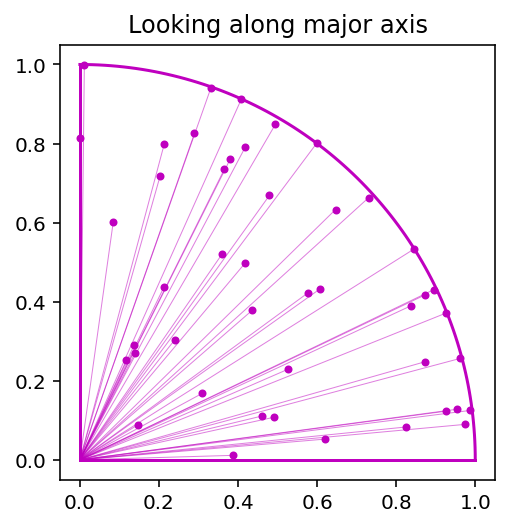

0.0 0.0


In [59]:
ang = np.linspace(0,np.pi/2,100)
plt.plot(np.cos(ang),np.sin(ang),c='m')
#plt.xlabel('B')
#plt.ylabel('C')
plt.axis('square')
plt.title('Looking along major axis')
plt.plot(np.array((0,0)),np.array((0,1)),c='m')
plt.plot(np.array((0,1)),np.array((0,0)),c='m')

subs_v = np.zeros((45,3))
subs_c = np.zeros((45,3))
host_v = np.zeros((45,3))
host_v_arr = np.zeros((45,3,3))
host_b = np.zeros((45,3))
host_c = np.zeros((45,3))
all_v = np.zeros((45,3))
new_vs = np.zeros((45,3))
rs = np.zeros((45))
ts = np.zeros((45))
count = 0
count_random = 0
for i in range(45):
    #get eigen vectors and eigen values
    sw,sv = get_eigs(Is_subs[i],rvirs[i])
    subs_v[i] += sv[0]
    subs_c[i] += sv[2]
    hw,hv = get_eigs(Is_host[i],rvirs[i])
    host_v_arr[i] += hv
    host_v[i]+=hv[0]
    host_c[i]+=hv[2]
    host_b[i]+=hv[1]
    #check if eigenvectors are orthogonal
    check_ortho(hv)
    check_ortho(sv)
    aw,av = get_eigs(Is_all[i],rvirs[i])
    all_v[i] += av[0]

    #transform to frame of host halo
    new_v = transform(sv,hv)
    new_vs[i] += new_v[0]
    
    para = np.dot(new_v[0],hv[0]/norm(hv[0]))*(hv[0]/norm(hv[0]))
    perp = new_v[0]-para
    t = np.arccos(np.dot(new_v[0],hv[0])/(norm(new_v[0])*norm(hv[0])))
    p = np.arccos(np.dot(perp,hv[1])/(norm(hv[1])*norm(perp)))
    r = np.sqrt(np.sum(perp**2))
    plt.scatter(r*abs(np.cos(p)),r*abs(np.sin(p)),color='m',marker='.')
    plt.plot([0,r*abs(np.cos(p))],[0,r*abs(np.sin(p))],color='m',linewidth=0.5,alpha = 0.5)
    if r < host_rvirs[i]*0.0003:
        count +=1
    
    new_hv = rotate(hv,34,12,76)
    para = np.dot(new_v[0],new_hv[0]/norm(new_hv[0]))*(new_hv[0]/norm(new_hv[0]))
    perp = new_v[0]-para
    t = np.arccos(np.dot(new_v[0],hv[0])/(norm(new_v[0])*norm(hv[0])))
    p = np.arccos(np.dot(perp,hv[1])/(norm(hv[1])*norm(perp)))
    r = np.sqrt(np.sum(perp**2))
    if r < host_rvirs[i]*0.0003:
        count_random +=1

plt.show()
print(count/45, count_random/45)


In [17]:
ang = np.linspace(0,np.pi/2,100)
#plt.plot(np.cos(ang),np.sin(ang),c='m')
#plt.xlabel('B')
#plt.ylabel('A')
#plt.axis('square')
#plt.title('Looking along major axis (# weight)')
#plt.plot(np.array((0,0)),np.array((0,1)),c='m')
#plt.plot(np.array((0,1)),np.array((0,0)),c='m')

subs_norm_v = np.zeros((45,3))
host_norm_v = np.zeros((45,3))

new_vs = np.zeros((45,3))
num_weight_thetas = np.zeros((45))

for i in range(45):
    #get eigen vectors and eigen values
    sw,sv = get_eigs(Is_subs_norm[i],rvirs[i])
    subs_norm_v[i] += sv[0]
    hw,hv = get_eigs(Is_host_norm[i],rvirs[i])
    host_norm_v[i]+=hv[0]

    #check if eigenvectors are orthogonal
    check_ortho(hv)
    check_ortho(sv)
    
    #transform to frame of host halo
    new_v = transform(sv,hv)
    new_vs[i] += new_v[0]



KstestResult(statistic=0.3694108341096356, pvalue=5.1237539548842385e-06)


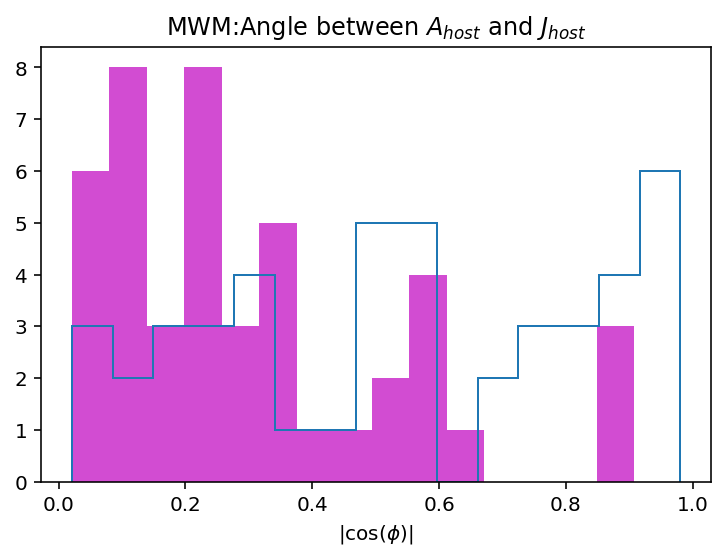

KstestResult(statistic=0.3733333333333333, pvalue=9.153754332058431e-07)


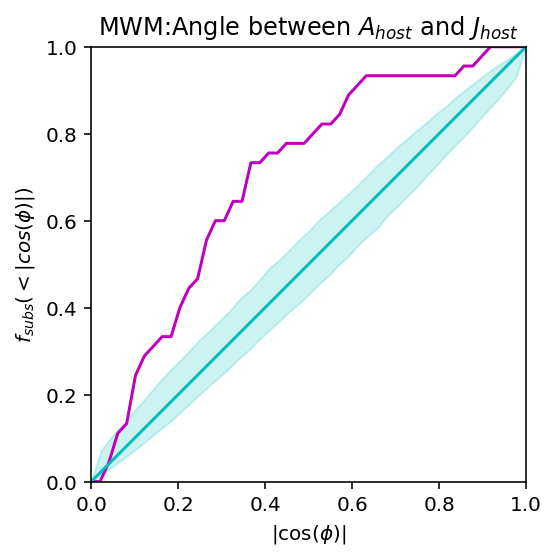

KstestResult(statistic=0.33305539933094674, pvalue=5.954929069576578e-05)


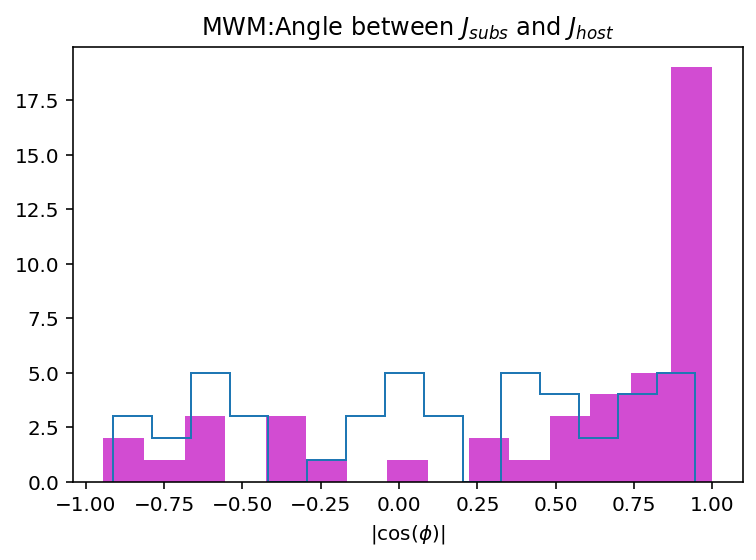

KstestResult(statistic=0.4466666666666667, pvalue=1.2905784715033901e-09)


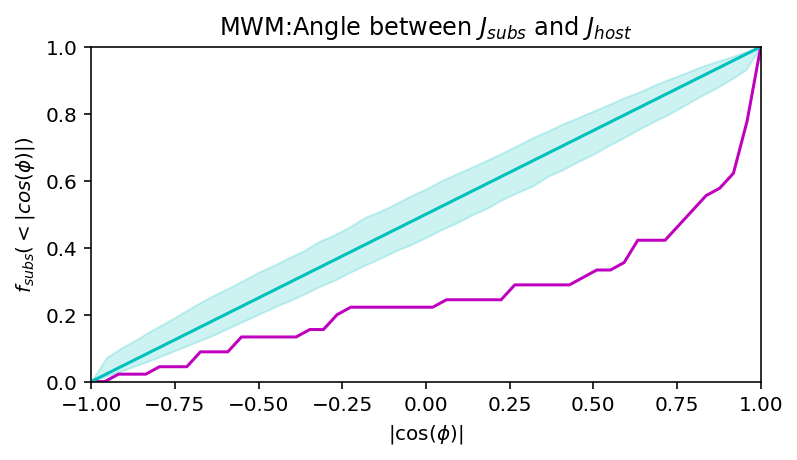

KstestResult(statistic=0.28888888888888886, pvalue=0.0008070750295987583)


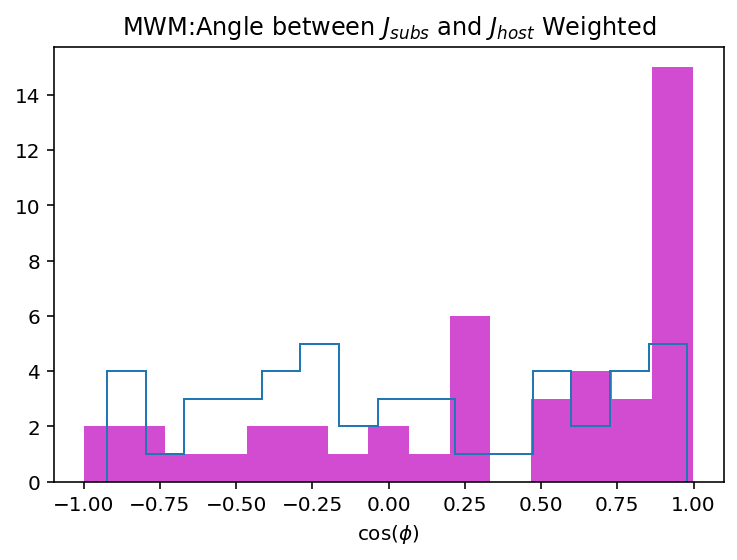

KstestResult(statistic=1.0, pvalue=0.0)


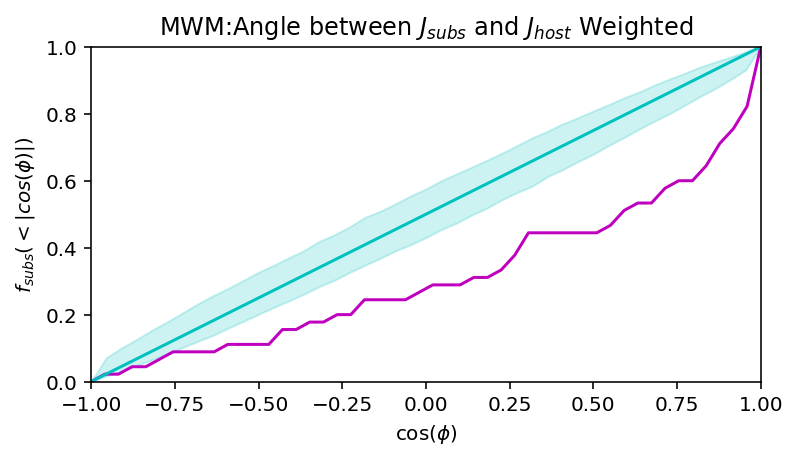

KstestResult(statistic=0.5668763235688519, pvalue=3.455531034911652e-14)


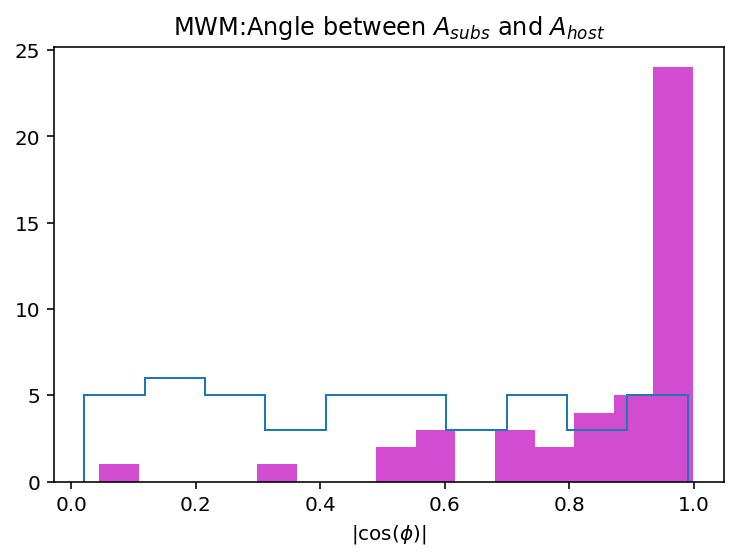

KstestResult(statistic=0.5533333333333332, pvalue=6.388008851589294e-15)


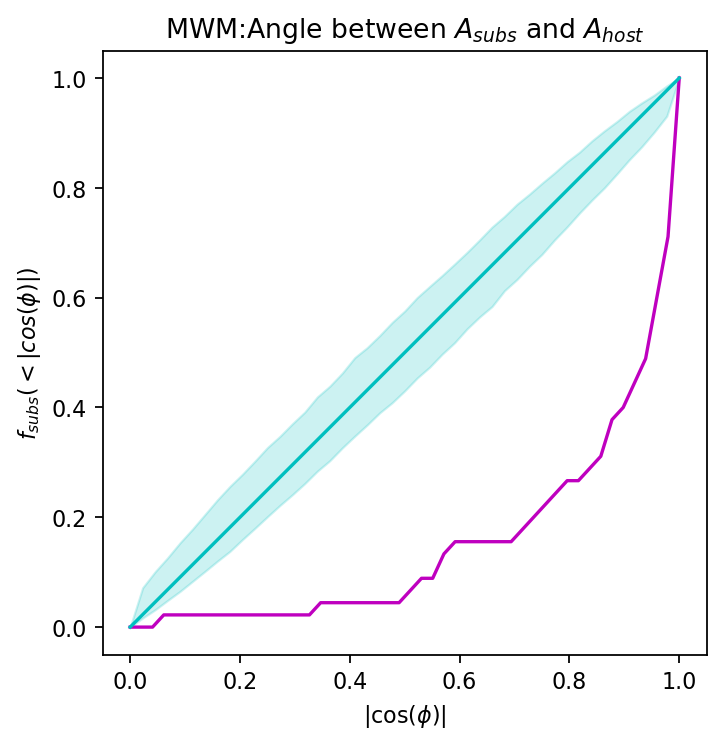

KstestResult(statistic=0.8359101205377614, pvalue=1.350058607526372e-35)


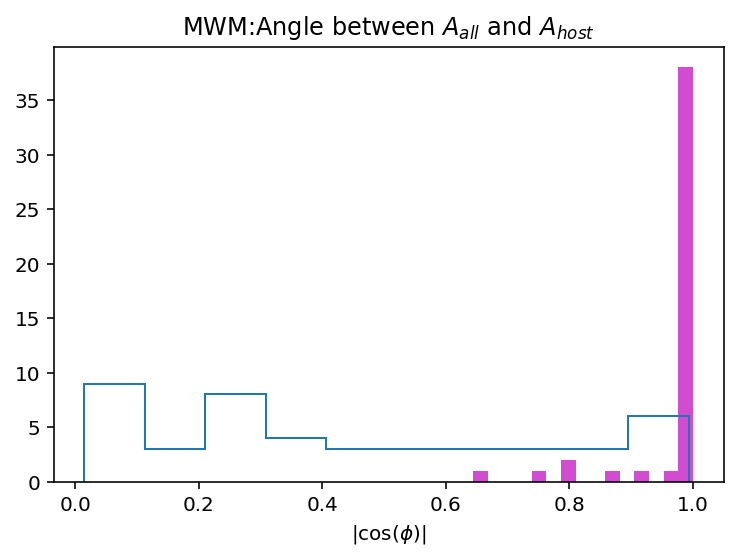

KstestResult(statistic=0.8266666666666667, pvalue=2.973698277097261e-38)


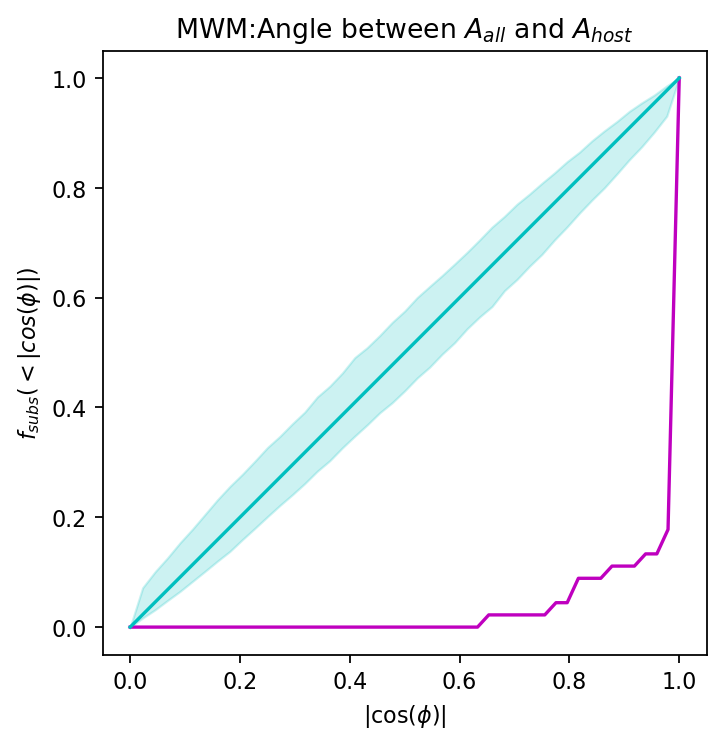

In [60]:
isotropic = np.random.uniform(0,1,45)
cdfs, iso_std, iso_percentile = MC_err('uniform',45,1000,0,1)

ahost_jhost_angs = abs(get_angles(host_v,j_host.T,45))
print(stats.kstest(abs(get_angles(host_v,j_host.T,45)),stats.uniform.cdf))

plt.hist(abs(get_angles(host_v,j_host.T,45)),bins=15,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step',density=False,bins=15)
plt.title('MWM:Angle between $A_{host}$ and $J_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.show()

lin_array = np.linspace(0,1,45)
print(stats.kstest(get_cumul_angles(ahost_jhost_angs,min_val=0.,num=50)[1],stats.uniform.cdf))
plt.plot(get_cumul_angles(ahost_jhost_angs,min_val=0.,num=50)[0],get_cumul_angles(ahost_jhost_angs,min_val=0.,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.xlabel('|cos($\phi$)|')
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('MWM:Angle between $A_{host}$ and $J_{host}$')
plt.show()

#####
isotropic = np.random.uniform(-1,1,45)

jsubs_jhost_angs = (get_angles(j_subs.T,j_host.T,45))
print(stats.kstest((get_angles(j_subs.T,j_host.T,45)),stats.uniform.cdf))

plt.hist((get_angles(j_subs.T,j_host.T,45)),bins=15,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step',density=False,bins=15)
plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.show()

lin_array = np.linspace(-1,1,45)
print(stats.kstest(get_cumul_angles(jsubs_jhost_angs,min_val=-1.,num=50)[1],stats.uniform.cdf))
plt.plot(get_cumul_angles(jsubs_jhost_angs,min_val=-1,num=50)[0],get_cumul_angles(jsubs_jhost_angs,min_val=-1,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot([-1,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(-1.,1.)
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$')
plt.show()


#####
isotropic = np.random.uniform(-1,1,45)

jsubs_jhost_w_angs = (get_angles(j_subs_w.T,j_host.T,45))
print(stats.kstest((get_angles(j_subs_w.T,j_host.T,45)),stats.uniform.cdf))

plt.hist(jsubs_jhost_w_angs,bins=15,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step',density=False,bins=15)
plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$ Weighted')
plt.xlabel('cos($\phi$)')
plt.show()

print(stats.kstest(get_cumul_angles(jsubs_jhost_w_angs,num=50)[1],stats.uniform.cdf))
plt.plot(get_cumul_angles(jsubs_jhost_w_angs,min_val=-1.,num=50)[0],get_cumul_angles(jsubs_jhost_w_angs,min_val =-1.,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot([-1,1],[0,1],c='c')
lin_array = np.linspace(-1,1,45)
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(-1,1)
plt.xlabel('cos($\phi$)')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$ Weighted')
plt.show()

#plt.hist(abs(get_angles(j_subs.T,j_host.T,45)),bins=15,density=False,color='m',alpha=0.7)
#plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$')
#plt.xlabel('cos($\phi$)')
#plt.show()

#plt.hist(abs(get_angles(j_subs.T,host_b,45)),bins=15,density=False,color='m',alpha=0.7)
#plt.title('MWM:Angle between $J_{subs}$ and $C_{host}$')
#plt.xlabel('cos($\phi$)')
#plt.show()

isotropic = np.random.uniform(0,1,45)
lin_array = np.linspace(0,1,45)

asubs_ahost_angs = abs(get_angles(subs_v,host_v,45))
print(stats.kstest(abs(get_angles(subs_v,host_v,45)),stats.uniform.cdf))
plt.hist(abs(get_angles(subs_v,host_v,45)),bins=15,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step')
plt.title('MWM:Angle between $A_{subs}$ and $A_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.show()

plt.figure(figsize=(5, 5), dpi=80)
plt.plot(get_cumul_angles(asubs_ahost_angs,min_val=0,num=50)[0],get_cumul_angles(asubs_ahost_angs,min_val=0,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
print(stats.kstest(get_cumul_angles(asubs_ahost_angs,min_val=0,num=50)[1],stats.uniform.cdf))
#for i in range(45):
#    plt.scatter(get_cumul_angles(asubs_ahost_angs,num=45)[0][i],get_cumul_angles(asubs_ahost_angs,num=45)[1][i],color=cm.cool(np.argsort(mvirs)[i]/40),alpha=1)
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
#plt.ylim(0.,1.)
#plt.xlim(0.,1.)
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('MWM:Angle between $A_{subs}$ and $A_{host}$')
plt.savefig('mwm_maj_axis_ang.png')
plt.show()

isotropic = np.random.uniform(0,1,45)
lin_array = np.linspace(0,1,45)

aall_ahost_angs = abs(get_angles(all_v,host_v,45))
print(stats.kstest(abs(get_angles(all_v,host_v,45)),stats.uniform.cdf))
plt.hist(abs(get_angles(all_v,host_v,45)),bins=15,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step')
plt.title('MWM:Angle between $A_{all}$ and $A_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.show()

plt.figure(figsize=(5, 5), dpi=80)
plt.plot(get_cumul_angles(aall_ahost_angs,min_val=0,num=50)[0],get_cumul_angles(aall_ahost_angs,min_val=0,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
print(stats.kstest(get_cumul_angles(aall_ahost_angs,min_val=0,num=50)[1],stats.uniform.cdf))
#for i in range(45):
#    plt.scatter(get_cumul_angles(asubs_ahost_angs,num=45)[0][i],get_cumul_angles(asubs_ahost_angs,num=45)[1][i],color=cm.cool(np.argsort(mvirs)[i]/40),alpha=1)
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
#plt.ylim(0.,1.)
#plt.xlim(0.,1.)
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('MWM:Angle between $A_{all}$ and $A_{host}$')
#plt.savefig('mwm_maj_axis_ang.png')
plt.show()

virial


ValueError: x and y must be the same size

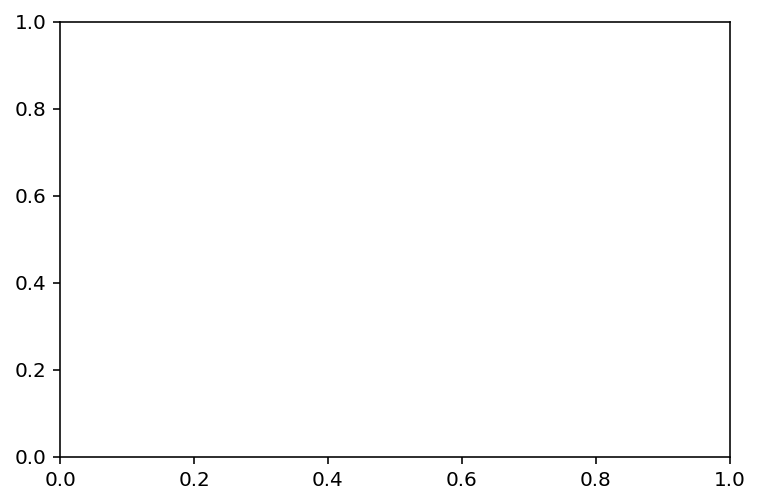

In [24]:
print('virial')
plt.scatter(jsubs_jhost_angs,host_TU_val)
#corr, _ = stats.spearmanr(jsubs_jhost_angs,host_TU_val)
#print('Spearmans correlation: %.3f' % corr)

#spears,s_err = MC_err('random',95,500,min(jsubs_jhost_angs),max(jsubs_jhost_angs),min(host_TU_val),max(host_TU_val))
#print('Spearmanr err: {}'.format(round(s_err,3)))

corr, _ = stats.pearsonr(jsubs_jhost_angs,host_TU_val)
print('pearsonr correlation: %.3f' % corr)

pear_err = pearsonr_err(45, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0)
print('pearsonr err: %.3f' % pear_err)

plt.show()

print('50% mass sacle')
plt.scatter(jsubs_jhost_angs,mwm_50_mass_scale)

corr, _ = stats.pearsonr(jsubs_jhost_angs,mwm_50_mass_scale)
print('pearsonr correlation: %.3f' % corr)

pear_err = pearsonr_err(45, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0)
print('pearsonr err: %.3f' % pear_err)

plt.show()

print('acc rate tdyn')
plt.scatter(jsubs_jhost_angs,host_acc_rate_tdyn)

corr, _ = stats.pearsonr(jsubs_jhost_angs,host_acc_rate_tdyn)
print('pearsonr correlation: %.3f' % corr)

pear_err = pearsonr_err(45, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = min(host_acc_rate_tdyn), val_max2 = max(host_acc_rate_tdyn))
print('pearsonr err: %.3f' % pear_err)

plt.show()

print('acc rate 100Myr')
plt.scatter(jsubs_jhost_angs,host_acc_rate_100myr)

corr, _ = stats.pearsonr(jsubs_jhost_angs,host_acc_rate_100myr)
print('pearsonr correlation: %.3f' % corr)

pear_err = pearsonr_err(45, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = min(host_acc_rate_100myr), val_max2 = max(host_acc_rate_100myr))
print('pearsonr err: %.3f' % pear_err)

plt.show()

print('concentration')
plt.scatter(jsubs_jhost_angs,host_c)

corr, _ = stats.pearsonr(jsubs_jhost_angs,host_c)
print('pearsonr correlation: %.3f' % corr)

pear_err = pearsonr_err(45, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = min(host_c), val_max2 = max(host_c))
print('pearsonr err: %.3f' % pear_err)

plt.show()


In [66]:
np.save('mwm_TU_val.npy',host_TU_val)

In [171]:
outlier_cut = np.argsort(jsubs_jhost_angs)
jsubs_jhost_angs_cut = jsubs_jhost_angs[outlier_cut][1:len(jsubs_jhost_angs)]
mwm_50_mass_scale_cut = mwm_50_mass_scale[outlier_cut][1:len(mwm_50_mass_scale)]

In [148]:
from sklearn.model_selection import train_test_split
from sklearn import utils,preprocessing

In [88]:
radius_cut2 = [0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05,0.025,0.02]#,0.015]
radius_cut = [0.5,0.4,0.3,0.2,0.1,0.05,0.025,0.02]#,0.015]
#mass_frac_arr = np.zeros((len(radius_cut),45))

In [263]:
mass_frac_A = np.zeros(45)
mass_frac_B = np.zeros(45)
mass_frac_C = np.zeros(45)
num_frac_A = np.zeros(45)
mass_frac_random = np.zeros(int(45)*5)
num_frac_random = np.zeros(int(45)*5)
phis = np.zeros(45)
thetas = np.zeros(45)

#tx = np.random.random()*90.0
#ty = np.random.random()*90.0
#tz = np.random.random()*90.0

for j in range(45):
    new_pos = transform(sub_pos[j],host_v_arr[j]).T

    """
    para = np.zeros(np.shape(new_pos))
    perp = np.zeros(np.shape(new_pos))
    p = np.zeros(len(new_pos))
    t = np.zeros(len(new_pos))
    hA = host_v_arr[j][0]
    hB = host_v_arr[j][1]
    for i in range(len(new_pos)):
        para[i]+=np.dot(new_pos[i],hA/norm(hA))*(hA/norm(hA))
        perp[i]+=new_pos[i]-para[i]
        t[i]+=np.arccos(np.dot(new_pos[i],hA)/(norm(new_pos[i])*norm(hA)))
        p[i]+=np.arccos(np.dot(perp[i],hB)/(norm(hB)*norm(perp[i])))
    mwm_r = np.sqrt(np.sum(perp**2,axis=1))
    
    para = np.zeros(np.shape(new_pos))
    perp = np.zeros(np.shape(new_pos))
    p = np.zeros(len(new_pos))
    t = np.zeros(len(new_pos))
    hA = host_v_arr[j][0]
    hB = host_v_arr[j][1]
    hC = host_v_arr[j][2]
    for i in range(len(new_pos)):
        para[i]+=np.dot(new_pos[i],hA/norm(hA))*(hA/norm(hA))
        perp[i]+=new_pos[i]-para[i]
        t[i]+=np.arccos(np.dot(new_pos[i],hA)/(norm(new_pos[i])*norm(hA)))
        p[i]+=np.arccos(np.dot(perp[i],hB)/(norm(hB)*norm(perp[i])))
    mwm_r_A = np.sqrt(np.sum(perp**2,axis=1))

    #plt.scatter(r*abs(np.cos(p)),r*abs(np.sin(p)),marker='.',c='m',alpha=0.04)
    #plt.plot([np.zeros(len(new_pos)),r*abs(np.cos(p))],[np.zeros(len(new_pos)),r*abs(np.sin(p))],color='m',linewidth=0.5,alpha = 0.5)
    #ang = np.linspace(0,np.pi/2,100)
    #plt.plot(max(r)*np.cos(ang),max(r)*np.sin(ang),c='m')
    #plt.plot(0.001*host_rvirs[j]*np.cos(ang),0.001*host_rvirs[j]*np.sin(ang),c='c')
    #plt.plot(0.0003*host_rvirs[j]*np.cos(ang),0.0003*host_rvirs[j]*np.sin(ang),c='c')    
    #plt.axis('square')
    #plt.show()
    mass_frac_A[j]+=np.sum(sub_mass[j][mwm_r_A<(0.001*radius_cut[8]*host_rvirs[j])])/host_mvirs[j]
    #mass_frac_A[j]+=np.sum(sub_mass[j][mwm_r<0.0003*host_rvirs[j]])/host_mvirs[j]#np.sum(sub_mass[j])
    #num_frac_A[j]+=len(sub_mass[j][mwm_r<0.00005*host_rvirs[j]])/len(sub_mass[j])
    """
#mass_frac_arr[8]+=mass_frac_A

i = 0
for j in range(45):
    for k in range(5):
        print(np.shape(sub_pos[j]))
        print(np.shape(host_v_arr[j]))
        mwm_rand_r = random_rotation(host_v_arr[j],sub_pos[j])
        mass_srtd = np.argsort(sub_mass[j])
        m = sub_mass[j][mass_srtd][:-10]
        r = mwm_rand_r[mass_srtd][:-10]
        mass_frac_random[i]+=np.sum(m[r<0.001*radius_cut[8]*host_rvirs[j]])/host_mvirs[j]#np.sum(sub_mass[j])
        i+=1



(224, 3)
(3, 3)


IndexError: list index out of range

In [46]:
#print('rand log med: {}'.format(np.log10(np.median(mass_frac_random))))
#print('A log med: {}'.format(np.log10(np.median(mass_frac_A))))
print('A med: {}'.format(np.median(mass_frac_A)))
print('Rand med: {}'.format(np.median(mass_frac_random)))
#print('C med: {}'.format(np.median(mass_frac_C)))
#print(rotation_err_bs_3(host_v_arr,sub_pos,sub_mass,host_rvirs,host_mvirs,0.000015,45,n_rep=500))



NameError: name 'mass_frac_A' is not defined

In [ ]:
radius_cut = [0.5,0.4,0.3,0.2,0.1,0.05,0.025,0.02]#,0.015]

mwm_a_fracs2 = [0.04055674249215598,0.037054120349619,0.02936370610092293,0.023888378438828003,
    0.019561085566894697,0.013077048905761501,0.006741320754716981,0.004121685196021065,
    0.0015783135763811228,0.0003954656719897424,0.00011659883401165989,7.591849662162162e-05]

mwm_a_fracs = [0.04055674249215598,0.02936370610092293,0.0196,0.0067,0.00157831,0.000395,0.0001165988340,7.591849662162162e-05]#,2.6826403570589616e-05]
mwm_b_fracs = [0.036910,0.024986,0.01481349,0.0073353,0.0017646,0.0002588,6.491660793986376e-05,1.9691214311971573e-05]#,0.0]
mwm_c_fracs = [0.0340629,0.02448848,0.01535714,0.00679699,0.001430,0.0003006,5.1674484564197666e-05,2.766981132075472e-05]#,0.]

mwm_rand_fracs2 = [0.036773559265811585,0.031168846024447684,0.02584,0.0212347344240251,
    0.0159,0.01165102872834812,0.0075,0.004054077253218884,
    0.0016953229132747206,0.000385,6.16894772268342e-05,3.1023990637799884e-05]
mwm_rand_fracs = [0.036773559265811585,0.02584,0.0159,0.0075,0.00177397156,0.000385,6.16894772268342e-05,3.1023990637799884e-05]#, 0]
mwm_rand_lower_err = [0.033060,0.024383,0.014343,0.00669,0.001435,0.000287,4.88747731e-05,1.96912143e-05]#,0.0]
mwm_rand_upper_err = [0.040662,0.027571,0.017061,0.008223,0.001907,0.00044379,8.96910755e-05,5.34466372e-05]#,1.78176918e-05]


#mwm_rand_upper_err = [-1.77,-1.595,-2.169,-2.655,-2.951,0.]
#mwm_rand_lower_err = [-1.852,-2.402,-3.134,-4.030,0.,0.]
plt.figure(figsize=[10,8])
plt.plot(radius_cut,np.log10(mwm_a_fracs),label='Major Axis',c='m')
plt.plot(radius_cut,np.log10(mwm_rand_fracs),label='Random',c='b')
plt.fill_between(radius_cut,np.log10(mwm_rand_lower_err),np.log10(mwm_rand_upper_err),alpha=0.3)
plt.axvline(0.02,linestyle=':',label='2%')
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("MWM Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[10,8])
plt.plot(radius_cut,np.log10(mwm_b_fracs),label='Semi-Maj Axis',c='g')
plt.plot(radius_cut,np.log10(mwm_rand_fracs),label='Random',c='b')
plt.axvline(0.02,linestyle=':',label='2%')
plt.fill_between(radius_cut,np.log10(mwm_rand_lower_err),np.log10(mwm_rand_upper_err),alpha=0.3)
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("MWM SM Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[10,8])
plt.plot(radius_cut,np.log10(mwm_c_fracs),label='Minor Axis',c='c')
plt.plot(radius_cut,np.log10(mwm_rand_fracs),label='Random',c='b')
plt.axvline(0.02,linestyle=':',label='2%')
plt.fill_between(radius_cut,np.log10(mwm_rand_lower_err),np.log10(mwm_rand_upper_err),alpha=0.3)
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("MWM Min Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[10,8])
plt.plot(radius_cut, np.log10(np.array(mwm_a_fracs))-np.log10(np.array(mwm_rand_fracs)),label='Major Axis',c='m')
plt.plot(radius_cut, np.log10(np.array(mwm_b_fracs))-np.log10(np.array(mwm_rand_fracs)),label='Semi-Maj Axis',c='g')
plt.plot(radius_cut, np.log10(np.array(mwm_c_fracs))-np.log10(np.array(mwm_rand_fracs)),label='Minor Axis',c='c')
plt.axvline(0.02,linestyle=':',label='2%')
plt.axhline(0,c='black',label='Random')
plt.fill_between(radius_cut, np.log10(np.array(mwm_rand_lower_err))-np.log10(np.array(mwm_rand_fracs)),np.log10(np.array(mwm_rand_upper_err))-np.log10(np.array(mwm_rand_fracs)),color='b',alpha=0.3)
plt.xlabel('halo radius fraction')
plt.ylabel('$(M_{subs}/M_{tot})_{axis}$ - $(M_{subs}/M_{tot})_{random}$')
plt.title("Radius vs Sub Mass fraction Difference")
plt.grid()
plt.legend()
plt.show()

In [19]:
def bs_mass_frac_err_2(mass_frac_arr,n_boot,n_samp,p1=15.9,p2=84.1):
    n_rad, n_halos = np.shape(mass_frac_arr.T)
    boot_vals = np.zeros((n_boot,n_samp,n_rad))
    for i in range(n_boot):
        for j in range(n_samp):
            indx = random.randint(0, n_halos-1)
            boot_vals[i][j]+=mass_frac_arr[indx]
    meds = np.median(boot_vals,axis=1)
    percentiles = np.percentile(meds,[p1,p2],axis=0)
    
    return percentiles

In [21]:
mwm_a_frac_err = bs_mass_frac_err_2(np.load('mwm_mass_frac_A_arr.npy').T,1000,45)

In [20]:
mwm_ang_mass_frac_A_rad = np.load('mwm_mass_frac_rad.npz')['A']
mwm_ang_mass_frac_rand_rad = np.load('mwm_mass_frac_rad.npz')['rand']
mwm_mass_frac_err_particles = np.log10(bs_mass_frac_err_2(np.load('mwm_mass_frac_rad.npz')['A'],1000,45).T[0:8].T)
#mwm_ang_mass_frac_err_1sig = np.load('mwm_mass_frac_err.npz')['one_sig'].T
#mwm_ang_mass_frac_err_5sig = np.load('mwm_mass_frac_err.npz')['five_sig'].T

mwm_mass_frac_errs = np.load('mwm_mass_frac_errs.npy')*281981.0/1.3e8

mwm_ang_med_mass_frac_A_rad = np.log10(np.median(mwm_ang_mass_frac_A_rad,axis=0))[0:8]
mwm_ang_med_mass_frac_rand_rad = np.log10(np.median(mwm_ang_mass_frac_rand_rad,axis=0))[0:8]

/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_17423/753793883.py:9: RuntimeWarning: divide by zero encountered in log10
  mwm_ang_med_mass_frac_A_rad = np.log10(np.median(mwm_ang_mass_frac_A_rad,axis=0))[0:8]
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_17423/753793883.py:10: RuntimeWarning: divide by zero encountered in log10
  mwm_ang_med_mass_frac_rand_rad = np.log10(np.median(mwm_ang_mass_frac_rand_rad,axis=0))[0:8]


In [257]:
shot_noise_fracs_arr_1_test = np.load('shot_noise_mass_frac_A_x1_test.npy')
shot_noise_fracs_1_test = np.median(shot_noise_fracs_arr_1_test,axis=1)
mwm_shot_noise_err_1_test = bs_mass_frac_err_2(shot_noise_fracs_arr_1_test.T,1000,45)

shot_noise_fracs_arr_1 = np.load('shot_noise_mass_frac_A_x1.npy')
shot_noise_fracs_1= np.median(shot_noise_fracs_arr_1,axis=1)
mwm_shot_noise_err_1 = bs_mass_frac_err_2(shot_noise_fracs_arr_1.T,1000,45)


shot_noise_fracs_arr_cut = np.load('mass_frac_A_cut_mass.npy')
shot_noise_fracs_cut = np.median(shot_noise_fracs_arr_cut,axis=1)
mwm_shot_noise_err_cut = bs_mass_frac_err_2(shot_noise_fracs_arr_cut.T,1000,45)

mwm_rand_fracs_cut = [0.015727286821705426,0.011998509379187138,0.008196400179151271,0.0041858233497768385,
    0.0011203385817449983,0.00028669801813906615,5.205610838029013e-05,1.7368826311736883e-05,]

"""
shot_noise_fracs_arr_2 = np.load('shot_noise_mass_frac_A_x2.npy')
shot_noise_fracs_2 = np.median(shot_noise_fracs_arr_2,axis=1)
mwm_shot_noise_err_2 = bs_mass_frac_err(shot_noise_fracs_arr_2.T,100,1000)

shot_noise_fracs_arr_3 = np.load('shot_noise_mass_frac_A_x3.npy')
shot_noise_fracs_3 = np.median(shot_noise_fracs_arr_3,axis=1)
mwm_shot_noise_err_3 = bs_mass_frac_err(shot_noise_fracs_arr_3.T,100,1000)

shot_noise_fracs_arr_4 = np.load('shot_noise_mass_frac_A_x4.npy')
shot_noise_fracs_4 = np.median(shot_noise_fracs_arr_4,axis=1)
mwm_shot_noise_err_4 = bs_mass_frac_err(shot_noise_fracs_arr_4.T,100,1000)

shot_noise_fracs_arr_5 = np.load('shot_noise_mass_frac_A_x5.npy')
shot_noise_fracs_5 = np.median(shot_noise_fracs_arr_5,axis=1)
mwm_shot_noise_err_5 = bs_mass_frac_err(shot_noise_fracs_arr_5.T,100,1000)

shot_noise_fracs_arr_6 = np.load('shot_noise_mass_frac_A_x6.npy')
shot_noise_fracs_6 = np.median(shot_noise_fracs_arr_6,axis=1)
mwm_shot_noise_err_6 = bs_mass_frac_err(shot_noise_fracs_arr_6.T,100,1000)
"""

(1000, 8)
(1000, 8)
(1000, 8)


"\nshot_noise_fracs_arr_2 = np.load('shot_noise_mass_frac_A_x2.npy')\nshot_noise_fracs_2 = np.median(shot_noise_fracs_arr_2,axis=1)\nmwm_shot_noise_err_2 = bs_mass_frac_err(shot_noise_fracs_arr_2.T,100,1000)\n\nshot_noise_fracs_arr_3 = np.load('shot_noise_mass_frac_A_x3.npy')\nshot_noise_fracs_3 = np.median(shot_noise_fracs_arr_3,axis=1)\nmwm_shot_noise_err_3 = bs_mass_frac_err(shot_noise_fracs_arr_3.T,100,1000)\n\nshot_noise_fracs_arr_4 = np.load('shot_noise_mass_frac_A_x4.npy')\nshot_noise_fracs_4 = np.median(shot_noise_fracs_arr_4,axis=1)\nmwm_shot_noise_err_4 = bs_mass_frac_err(shot_noise_fracs_arr_4.T,100,1000)\n\nshot_noise_fracs_arr_5 = np.load('shot_noise_mass_frac_A_x5.npy')\nshot_noise_fracs_5 = np.median(shot_noise_fracs_arr_5,axis=1)\nmwm_shot_noise_err_5 = bs_mass_frac_err(shot_noise_fracs_arr_5.T,100,1000)\n\nshot_noise_fracs_arr_6 = np.load('shot_noise_mass_frac_A_x6.npy')\nshot_noise_fracs_6 = np.median(shot_noise_fracs_arr_6,axis=1)\nmwm_shot_noise_err_6 = bs_mass_frac

/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_10065/3956246750.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.fill_between((radius_cut), np.log10(mwm_shot_noise_err_cut[0])-np.log10(np.array(mwm_rand_fracs_cut)),np.log10(mwm_shot_noise_err_cut[1])-np.log10(np.array(mwm_rand_fracs_cut)),color='black',alpha=0.1,)


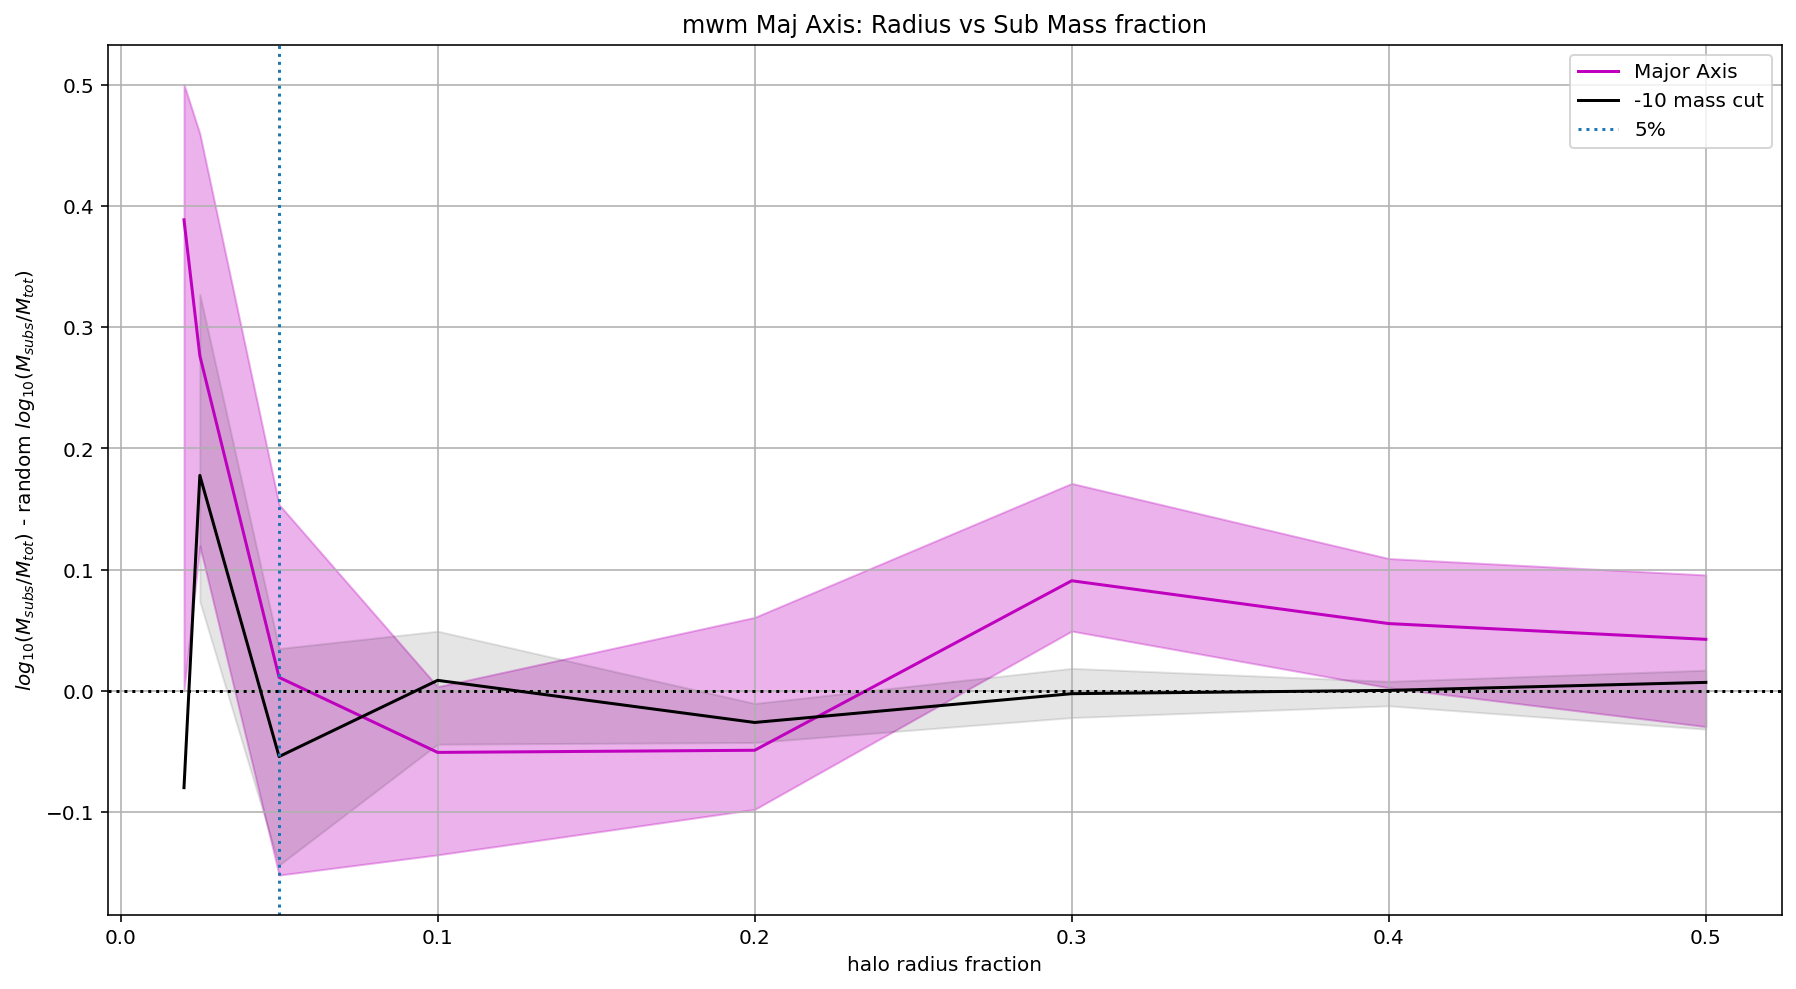

In [265]:
radius_cut = [0.5,0.4,0.3,0.2,0.1,0.05,0.025,0.02]#,0.015]

mwm_a_fracs = np.array([0.04055674249215598,0.02936370610092293,0.0196,0.0067,0.00157831,0.000395,0.0001165988340,7.591849662162162e-05])#,2.6826403570589616e-05]

mwm_rand_fracs = [0.036773559265811585,0.02584,0.0159,0.0075,0.00177397156,0.000385,6.16894772268342e-05,3.1023990637799884e-05]#, 0]
mwm_rand_lower_err = [0.033060,0.024383,0.014343,0.00669,0.001435,0.000287,4.88747731e-05,1.96912143e-05]#,0.0]
mwm_rand_upper_err = [0.040662,0.027571,0.017061,0.008223,0.001907,0.00044379,8.96910755e-05,5.34466372e-05]#,1.78176918e-05]


plt.figure(figsize=[15,8])

plt.plot((radius_cut), np.log10(np.array(mwm_a_fracs))-np.log10(np.array(mwm_rand_fracs)),label='Major Axis',c='m')
plt.plot((radius_cut), np.log10(shot_noise_fracs_cut)-np.log10(np.array(mwm_rand_fracs_cut)),color='black',label='-10 mass cut')

plt.axvline(0.05,label='5%',linestyle=':')
plt.axhline(0,c='black',linestyle=':')
plt.fill_between((radius_cut), np.log10(mwm_a_frac_err[0])-np.log10(mwm_rand_fracs),np.log10(mwm_a_frac_err[1])-np.log10(mwm_rand_fracs),color='m',alpha=0.3)

#plt.fill_between(radius_cut, mwm_mass_frac_err_particles[0]-mwm_ang_med_mass_frac_rand_rad,mwm_mass_frac_err_particles[1]-mwm_ang_med_mass_frac_rand_rad,color='orange',alpha=0.3)
plt.fill_between((radius_cut), np.log10(mwm_shot_noise_err_cut[0])-np.log10(np.array(mwm_rand_fracs_cut)),np.log10(mwm_shot_noise_err_cut[1])-np.log10(np.array(mwm_rand_fracs_cut)),color='black',alpha=0.1,)


plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$) - random $log_{10}(M_{subs}/M_{tot}$)')
plt.title("mwm Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

In [25]:
mwm_ang_mass_frac_A = np.load('mwm_mass_frac.npz')['A']*281981.0/1.3e8
mwm_ang_mass_frac_rand = np.load('mwm_mass_frac.npz')['rand']*281981.0/1.3e8

mwm_ang_med_mass_frac_A = np.median(mwm_ang_mass_frac_A,axis=0)
mwm_ang_med_mass_frac_rand = np.median(mwm_ang_mass_frac_rand,axis=0)

mwm_ang_med_mass_frac_A = np.median(mwm_ang_mass_frac_A,axis=0)
mwm_ang_med_mass_frac_rand = np.median(mwm_ang_mass_frac_rand,axis=0)

mwm_ang_mass_frac_A_2 = np.load('mwm_mass_frac_ang_2.npz')['A']
mwm_ang_mass_frac_C_2 = np.load('mwm_mass_frac_ang_2.npz')['C']
mwm_ang_mass_frac_rand_2 = np.load('mwm_mass_frac_ang_2.npz')['rand']

mwm_ang_med_mass_frac_A_2 = np.median(mwm_ang_mass_frac_A_2,axis=0)
mwm_ang_med_mass_frac_C_2 = np.median(mwm_ang_mass_frac_C_2,axis=0)
mwm_ang_med_mass_frac_rand_2 = np.median(mwm_ang_mass_frac_rand_2,axis=0)

In [338]:
rand_cut_fracs = np.zeros((45,16))
j=0
for i in range(45):
    rand_cut_fracs[j]+=mwm_ang_mass_frac_rand[i]
    i+=4
    j+=1

rand_cut_fracs_med = np.median(rand_cut_fracs,axis=0)

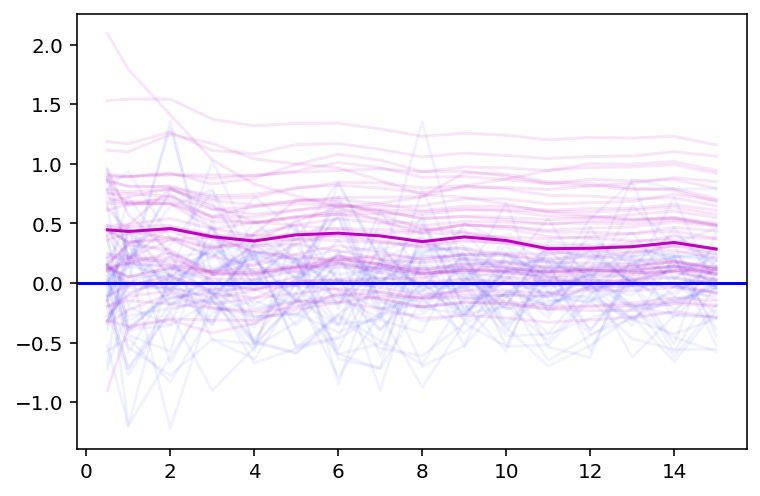

In [405]:
for i in range(45):
    plt.plot(ang_radius_cut,np.log10(rand_cut_fracs[i])-np.log10(rand_cut_fracs_med),color='b',alpha=0.05)
plt.axhline(0,color='b')
for i in range(45):
    plt.plot(ang_radius_cut,np.log10(mwm_ang_mass_frac_A[i])-np.log10(mwm_ang_med_mass_frac_rand),color='m',alpha=0.1)
plt.plot(ang_radius_cut,np.log10(mwm_ang_med_mass_frac_A)-np.log10(mwm_ang_med_mass_frac_rand),color='m')
plt.show()


In [22]:
mwm_A_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_A,1000,45,p1=4.55,p2=95.45))
mwm_rand_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_rand,1000,225,p1=4.55,p2=95.45))#-np.log10(mwm_ang_med_mass_frac_rand)
mwm_rand_ang_err = np.log10(bs_mass_frac_err_2(rand_cut_fracs,1000,45,p1=4.55,p2=95.45))#-np.log10(mwm_ang_med_mass_frac_rand)

#mwm_rand_ang_err = np.log10(np.percentile(np.median(mwm_mass_frac_errs,axis=1),[4.55,95.45],axis=1))-np.log10(mwm_ang_med_mass_frac_rand)

NameError: name 'rand_cut_fracs' is not defined

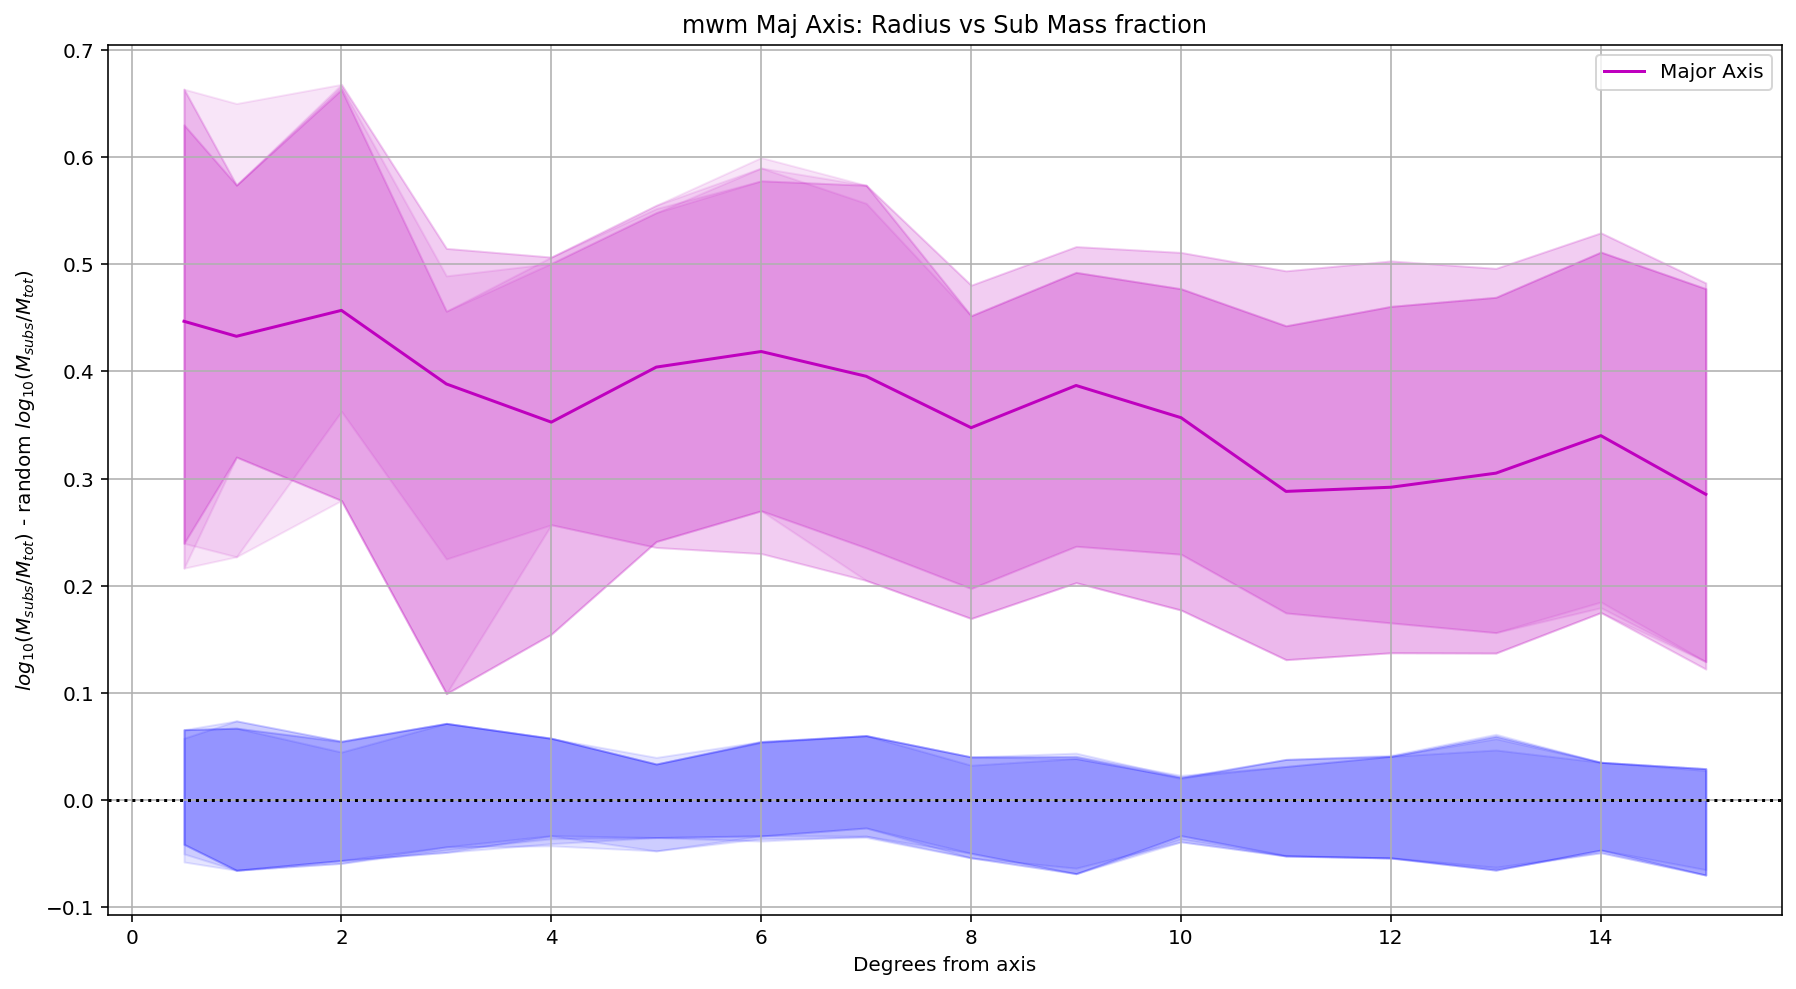

In [23]:
plt.figure(figsize=[15,8])
ang_radius_cut = [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0]
#plt.plot(ang_radius_cut, np.log10(mwm_ang_med_mass_frac_A)-np.log10(mwm_ang_med_mass_frac_rand),label='Major Axis',c='m')
plt.plot(ang_radius_cut, np.log10(mwm_ang_med_mass_frac_A)-np.log10(mwm_ang_med_mass_frac_rand),label='Major Axis',c='m')

plt.axhline(0,c='black',linestyle=':')
#

for i in range(5):
    mwm_A_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_A,1000,45,p1=4.55,p2=95.45))
    plt.fill_between(ang_radius_cut, mwm_A_ang_err[0]-np.log10((mwm_ang_med_mass_frac_rand)),mwm_A_ang_err[1]-np.log10((mwm_ang_med_mass_frac_rand)),color='m',alpha=0.1)
    mwm_rand_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_rand,1000,225,p1=4.55,p2=95.45))-np.log10(mwm_ang_med_mass_frac_rand)
    plt.fill_between(ang_radius_cut, mwm_rand_ang_err[0],mwm_rand_ang_err[1],color='b',alpha=0.1)

#plt.fill_between(ang_radius_cut, np.log10(mwm_ang_mass_frac_err_1sig[0])-np.log10(mwm_ang_med_mass_frac_rand),np.log10(mwm_ang_mass_frac_err_1sig[1])-np.log10(mwm_ang_med_mass_frac_rand),color='b',alpha=0.3)
plt.xlabel('Degrees from axis')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$) - random $log_{10}(M_{subs}/M_{tot}$)')
plt.title("mwm Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

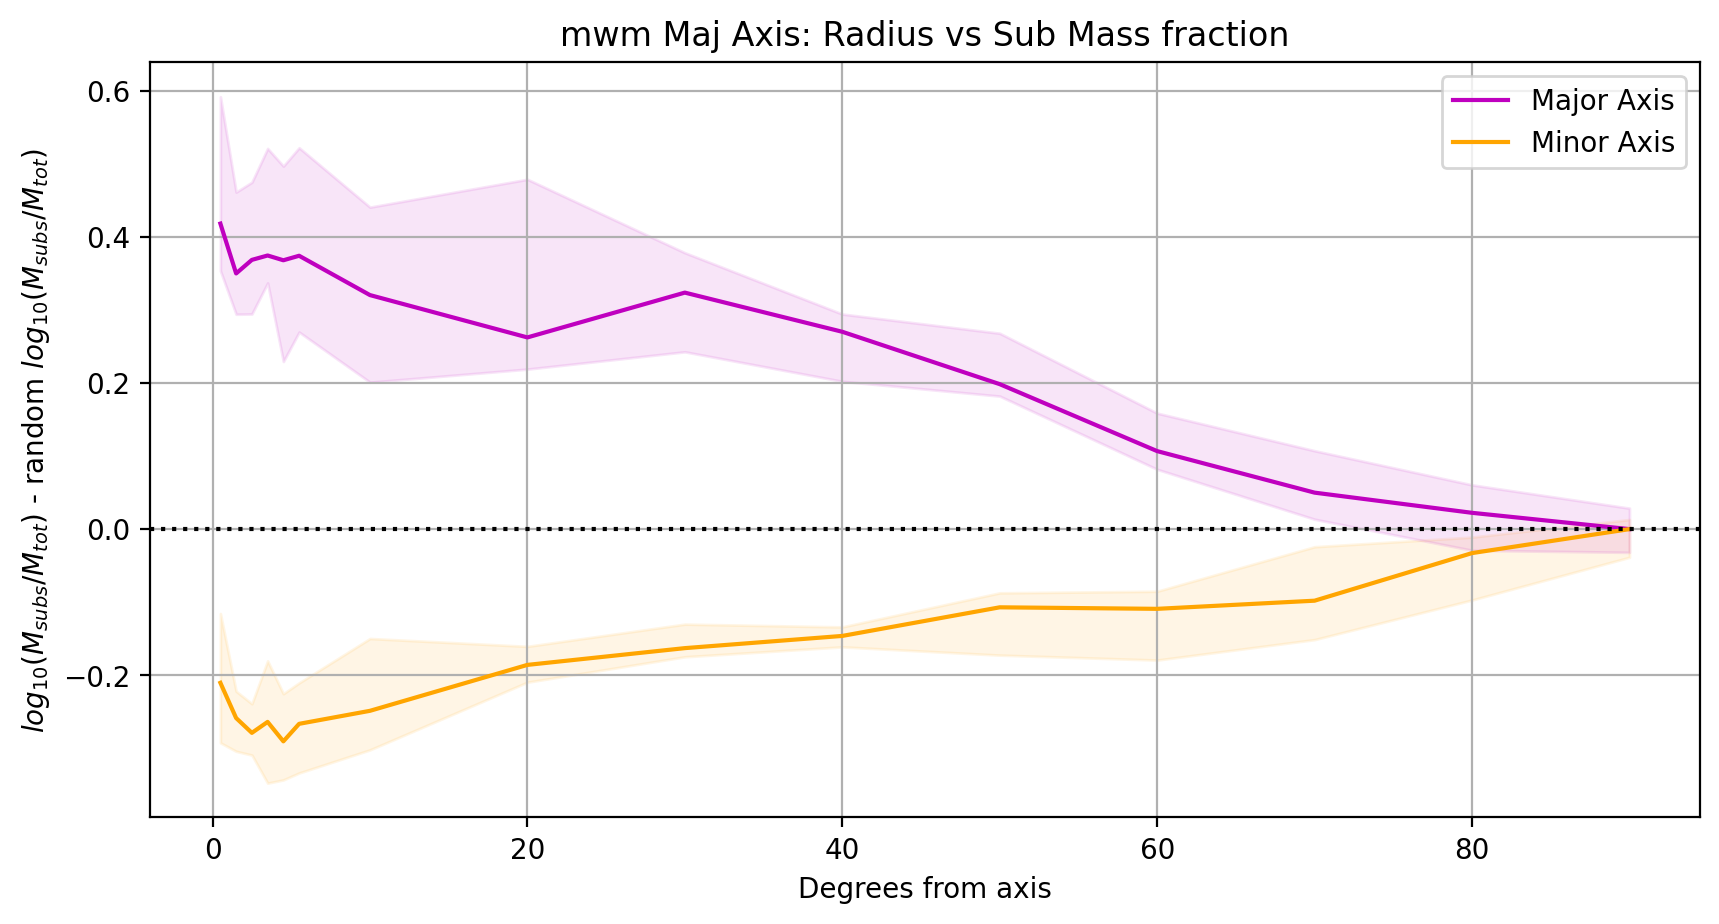

In [50]:
plt.figure(figsize=[10,5],dpi=100)
#ang_radius_cut = [10.0, 20.0, 30.0, 40.0 ,50.0 ,60.0 ,70.0 ,80.0 ,90.0]
ang_radius_cut = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 10.0, 20.0, 30.0, 40.0 ,50.0 ,60.0 ,70.0 ,80.0 ,90.0]
plt.plot(ang_radius_cut, np.log10(mwm_ang_med_mass_frac_A_2)-np.log10(mwm_ang_med_mass_frac_rand_2),label='Major Axis',c='m')
plt.plot(ang_radius_cut, np.log10(mwm_ang_med_mass_frac_C_2)-np.log10(mwm_ang_med_mass_frac_rand_2),label='Minor Axis',c='orange')

plt.axhline(0,c='black',linestyle=':')

for i in range(1):
    mwm_A_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_A_2,100,95,p1=4.55,p2=95.45))
    mwm_C_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_C_2,100,95,p1=4.55,p2=95.45))
    mwm_rand_ang_err = np.log10(bs_mass_frac_err_2(mwm_ang_mass_frac_rand_2,100,int(95*5),p1=4.55,p2=95.45))-np.log10(mwm_ang_med_mass_frac_rand_2)
    plt.fill_between(ang_radius_cut, mwm_C_ang_err[0]-np.log10((mwm_ang_med_mass_frac_rand_2)),mwm_C_ang_err[1]-np.log10((mwm_ang_med_mass_frac_rand_2)),color='orange',alpha=0.1)
    #plt.fill_between(ang_radius_cut, mwm_rand_ang_err[0],mwm_rand_ang_err[1],color='b',alpha=0.1)
    plt.fill_between(ang_radius_cut, mwm_A_ang_err[0]-np.log10((mwm_ang_med_mass_frac_rand_2)),mwm_A_ang_err[1]-np.log10((mwm_ang_med_mass_frac_rand_2)),color='m',alpha=0.1)

#plt.fill_between(ang_radius_cut, np.log10(mwm_ang_mass_frac_err_1sig[0])-np.log10(mwm_ang_med_mass_frac_rand),np.log10(mwm_ang_mass_frac_err_1sig[1])-np.log10(mwm_ang_med_mass_frac_rand),color='b',alpha=0.3)
plt.xlabel('Degrees from axis')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$) - random $log_{10}(M_{subs}/M_{tot}$)')
plt.title("mwm Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.savefig('mwm_angle_v_sub_mass_frac.png')
plt.show()

In [28]:
d1 = np.load('mwm_inertia_v_submass_all_no_norm.npy')
d2 = Is_host#np.load('inertia_v_submass_host_no_norm.npy') #host

vs = np.zeros((45,101,3))
vs2 = np.zeros((45,101,3))
for j in range(45):
    w2,v2 = get_eigs(d2[j],rvirs[j]) #for host halo
    d = d1[j]-d2[j] #calculate sub component
    for i in range(0,101):
        #get sub eigen vectors and eigen values
        w,v = get_eigs(d[i],rvirs[j])
        #transform to host frame
        #new_v = transform(v,v2)
        
        vs[j][i] += v[0]
        vs2[j][i] += v2[0]



In [ ]:
angles = np.zeros((45,101))
cumul_angles = np.zeros((45,101))
for i in range(45):
    angles[i]+=abs(get_angles(vs[i],vs2[i],101))
    #plt.plot(abs(get_angles(vs[i],vs2[i],1000))-np.mean(abs(get_angles(vs[i],vs2[i],1000))),alpha=0.1,c='b')#-np.mean(abs(get_angles(vs[i],vs2[i],1000))))
    plt.plot(abs(get_angles(vs[i],vs2[i],101)),alpha=0.1,c='b')#-np.mean(abs(get_angles(vs[i],vs2[i],1000))))
#plt.plot(np.mean(angles,axis=0),c='m')
plt.title('MWM:Angle between $A_{host}$ and $A_{subs}$')
plt.legend()
plt.ylabel('cos($\phi$)')
plt.xlabel('# of most massive subhalos')
plt.show()

for i in range(45):
    plt.plot(abs(get_angles(vs[i],vs2[i],101))-np.mean(abs(get_angles(vs[i],vs2[i],101))),alpha=0.1,c='b')#-np.mean(abs(get_angles(vs[i],vs2[i],1000))))
#plt.plot(np.mean(angles,axis=0),c='m')
plt.title('MWM:Angle between $A_{host}$ and $A_{subs}$ (centered)')
plt.legend()
plt.ylabel('cos($\phi$)')
plt.xlabel('# of most massive subhalos')
plt.show()

In [ ]:
cut1 = np.log10(cumul_top_mass.flatten()) < 11.0
counts, bin_edges=np.histogram(cumul_top_mass.flatten()[cut1],bins=15)
print(counts)

for i in range(12):
    cut2 = np.logical_and(cumul_top_mass.flatten()[cut1]>bin_edges[i],cumul_top_mass.flatten()[cut1]<bin_edges[i+1])
    angle_set = angles.flatten()[cut1][cut2]
    plt.plot(get_cumul_angles(angle_set)[0],get_cumul_angles(angle_set)[1],color=cm.cool(1+30*i),label='M={}'.format(round(np.log10(bin_edges[i+1]),3)),alpha=0.5)
plt.plot([0,1],[0,1])
plt.xlabel('cos($\phi$)')
plt.ylabel('$f_{<cos(\phi)}$')
#plt.legend()
cmap = cm.cool
norm = colors.Normalize(vmin=min(np.log10(bin_edges)), vmax=max(np.log10(bin_edges)))
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='Mass Bin')
plt.title("Halos Binned by Mass")
plt.show()

In [ ]:
for i in range(1):
    plt.plot(get_cumul_angles(angles.flatten(),num=100)[0],get_cumul_angles(angles.flatten(),num=100)[1],color='b',alpha=0.2)
plt.plot([0,1],[0,1])
plt.xlabel('cos($\phi$)')
plt.ylabel('$f_{<cos(\phi)}$')
plt.title("All Halos Combined")
plt.show()

In [ ]:
for i in range(15,35):
    plt.plot(get_cumul_angles(angles[i],num=100)[0],get_cumul_angles(angles[i],num=100)[1],color=cm.cool(np.argsort(mvirs)[i]/40),alpha=1)#,label='{}'.format(np.log10(mvirs[i])))
plt.plot([0,1],[0,1])
plt.xlabel('cos($\phi$)')
plt.ylabel('$f_{<cos(\phi)}$')
plt.title("Per Halo")
cmap = cm.cool
norm = colors.Normalize(vmin=min(np.log10(mvirs)), vmax=max(np.log10(mvirs)))
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='Host Mass')
plt.show()

In [ ]:
nums = np.linspace(0,101,101)
plt.plot(np.mean(angles,axis=0),c='m')
plt.title('MWM: Mean Angle between $A_{host}$ and $A_{subs}$')
#plt.legend()
plt.ylabel('cos($\phi$)')
plt.xlabel('# of most massive subhalos')
plt.show()



In [31]:
print(stats.spearmanr(cumul_top_mass.flatten(),abs(angles).flatten()))
spears, mwm_s_err = MC_err('random',45,2500,min(cumul_top_mass.flatten()),max(cumul_top_mass.flatten()),min(abs(angles).flatten()),max(abs(angles).flatten()))
print('spearman err: {}'.format(round(mwm_s_err,3)))


SpearmanrResult(correlation=0.13524136123792507, pvalue=5.330836654015517e-20)
spearman err: 0.151


In [ ]:
corrs = np.zeros(45)
for i in range(45):
    corrs[i]+=stats.spearmanr(np.log10(cumul_top_mass[i]),angles[i])[0]
    plt.plot(np.log10(cumul_top_mass[i]),angles[i],color='blue',alpha=0.2)
    #plt.scatter(np.log10(cumul_top_mass[i][100]),angles[i][100],color='m',marker='.',alpha=1)
    #plt.scatter(np.log10(top_mass[i][99]),angles[i][100],color='m',marker='.',alpha=1)
    
    #plt.axhline(0)

plt.xlabel('cumulative subhalo mass')
plt.ylabel('$cos(\phi)$')
plt.show()

plt.hist(corrs)
plt.show()

plt.scatter(np.log10(host_mvirs),corrs)
plt.show()

plt.plot(np.log10(np.mean(cumul_top_mass,axis=0))[0:90],np.mean(angles,axis=0)[0:90])
plt.xlabel('mean cumulative subhalo mass')
plt.ylabel('$cos(\phi)$')
plt.show()



In [40]:
h=3
mwm_sub_j = np.load('mwm_sub_js/{}_sub_js.npy'.format(halo_names[h]))
mwm_sub_m = np.load('mwm_sub_mass/{}_sub_mass.npy'.format(halo_names[h]))

rhap_sub_host_js = get_angles_1vect(mwm_sub_j,j_host.T[h],len(mwm_sub_j))
print(get_angle(j_host.T[h],j_subs.T[h]))

0.5075057543836388


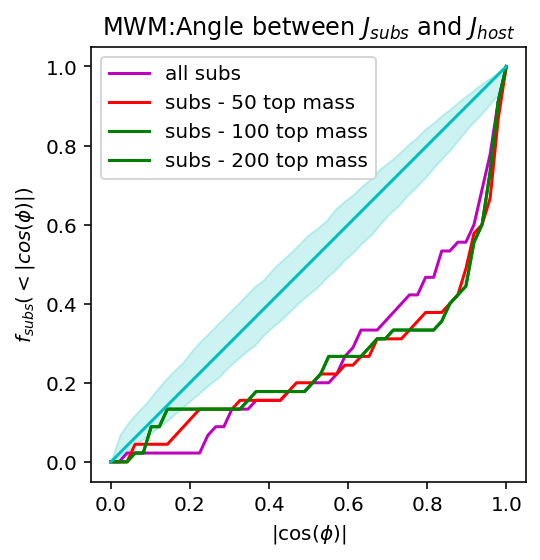

In [434]:
%matplotlib inline
lin_array = np.linspace(0,1,45)
cdfs, iso_std,iso_percentile= MC_err('uniform',45,1000,0,1)

angs = np.zeros(45)
angs1 = np.zeros(45)
angs2 = np.zeros(45)
angs3 = np.zeros(45)
for i in range(45):
    mwm_sub_j = np.load('mwm_sub_js/{}_sub_js.npy'.format(halo_names[i]))
    mwm_sub_m = np.load('mwm_sub_mass/{}_sub_mass.npy'.format(halo_names[i]))
    sub_j_set = np.sum(mwm_sub_j[np.argsort(mwm_sub_m)][0:-50],axis=0)
    angs1[i]+=abs(get_angle(sub_j_set,j_host.T[i]))
    
    sub_j_set2 = np.sum(mwm_sub_j[np.argsort(mwm_sub_m)][0:-100],axis=0)
    angs2[i]+=abs(get_angle(sub_j_set2,j_host.T[i]))

    sub_j_set3 = np.sum(mwm_sub_j[np.argsort(mwm_sub_m)][0:-200],axis=0)
    angs3[i]+=abs(get_angle(sub_j_set3,j_host.T[i]))

    #sub_j_set_2 = np.sum(mwm_sub_j[np.argsort(abs(np.sum(mwm_sub_j,axis=1)))][0:-100],axis=0)
    #angs3[i]+=abs(get_angle(sub_j_set_2,j_host.T[i]))
    angs[i]+=abs(get_angle(j_subs.T[i],j_host.T[i]))
    #angs3[i]+=abs(get_angle(j_rhap_all.T[i],j_rhap_host.T[i]))
plt.plot(get_cumul_angles(angs,num=50)[0],get_cumul_angles(angs,num=50)[1],c='m',label='all subs')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(angs1,num=50)[0],get_cumul_angles(angs2,num=50)[1],c='r',label='subs - 50 top mass')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(angs2,num=50)[0],get_cumul_angles(angs3,num=50)[1],c='g',label='subs - 100 top mass')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(angs3,num=50)[0],get_cumul_angles(angs3,num=50)[1],c='g',label='subs - 200 top mass')#,label='{}'.format(np.log10(mvirs[i])))

plt.legend()
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$')
plt.show()

In [215]:
%matplotlib
h = 25

X = np.arange(-0.25, .25, 0.05)
Y = np.arange(-0.25, .25, 0.05)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((len(X),len(Y)))

new_pos = transform(sub_pos[h],host_v_arr[h])

au = np.dot(host_v_arr[h].T,host_v_arr[h])[0]/4.5
av = np.dot(host_v_arr[h].T,host_v_arr[h])[1]/4.5
aw =np.dot(host_v_arr[h].T,host_v_arr[h])[2]/4.5

u3 = (new_pos[0])#[np.argsort(sub_mass[h])]
v3 = (new_pos[1])#[np.argsort(sub_mass[h])]
w3 = (new_pos[2])#[np.argsort(sub_mass[h])]

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.quiver(0., 0., 0., au, av, aw, length=1., normalize=False, color='black',linewidth=1,arrow_length_ratio=0.0,linestyle=':')
ax.quiver(0., 0., 0., -au, -av, -aw, length=1., normalize=False, color='black',linewidth=1,arrow_length_ratio=0.0,linestyle=':')

ax.scatter(0., 0., 0., color='red')
ax.scatter(u3, v3, w3, s = sub_mass[h]/1e8)
ax.plot_surface(X, Y, Z, color='black',
                       linewidth=0, antialiased=False,alpha=0.1)
plt.legend()
plt.show()

Using matplotlib backend: MacOSX


/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_10065/567939942.py:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
No handles with labels found to put in legend.


In [29]:
rhap_host_no_norm = np.load('rhap_host_inertia_tensor_no_norm.npy')
rhap_host_no_norm = np.delete(rhap_host_no_norm,46,0)
#rhap_host = np.load('rhap_host_inertia_tensor_1it.npy') #normlized by mass fraction

rhap_all = np.load('rhap_all_inertia_tensor_no_norm.npy')
rhap_all = np.delete(rhap_all,46,0)
rhap_subs = rhap_all-rhap_host_no_norm

rhap_all_inertia_v_mass = np.load('rhap_inertia_v_submass_all_no_norm.npy')
rhap_all_inertia_v_mass = np.delete(rhap_all_inertia_v_mass,46,0)
rhap_cumul_submass = np.load('rhap_cumul_submass.npy')
rhap_cumul_submass = np.delete(rhap_cumul_submass,46,0)


In [30]:
rhap_d1 = rhap_all_inertia_v_mass
rhap_d2 = rhap_host_no_norm

rhap_vs = np.zeros((95,101,3))
rhap_vs2 = np.zeros((95,101,3))
for j in range(95):
    w2,v2 = get_eigs(rhap_d2[j],rhap_host_rvirs[j]) #for host halo
    d = rhap_d1[j]-rhap_d2[j] #calculate sub component
    for i in range(0,101):
        #get sub eigen vectors and eigen values
        w,v = get_eigs(d[i],rhap_host_rvirs[j])
        #transform to host frame
        #new_v = transform(v,v2)
        
        rhap_vs[j][i] += v[0]
        rhap_vs2[j][i] += v2[0]

No handles with labels found to put in legend.


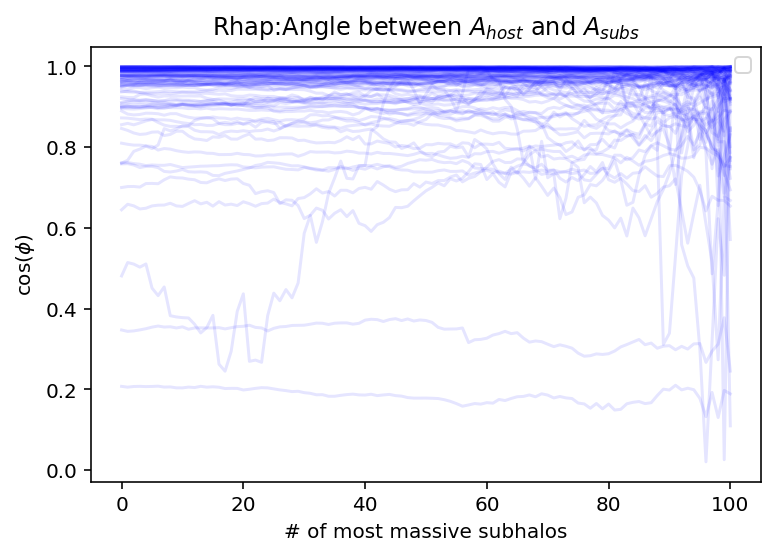

No handles with labels found to put in legend.


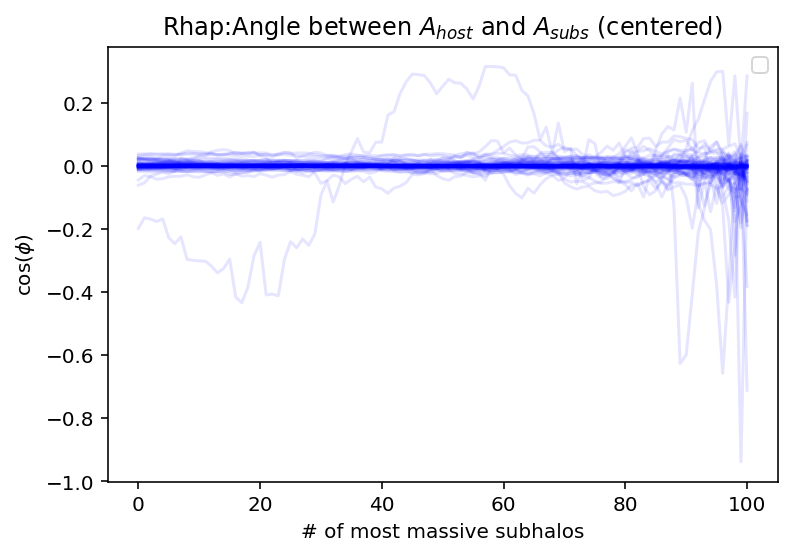

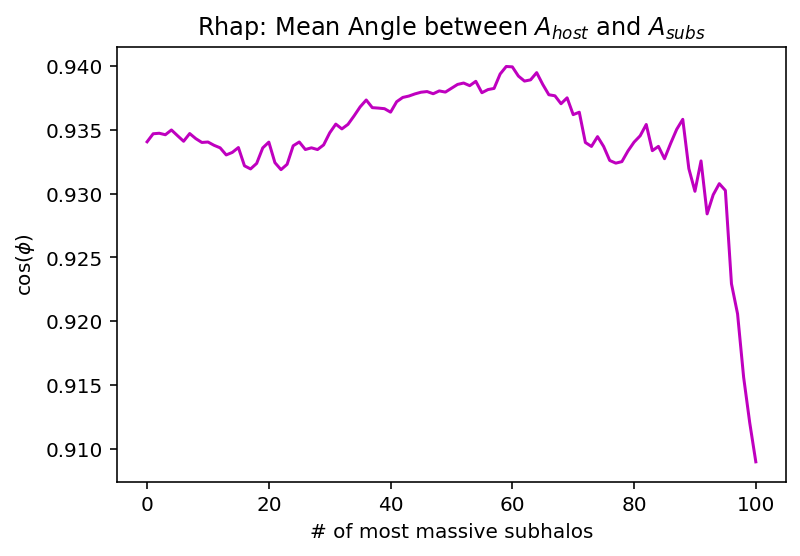

In [31]:
rhap_angles = np.zeros((95,101))
for i in range(95):
    rhap_angles[i]+=abs(get_angles(rhap_vs[i],rhap_vs2[i],101))
    #plt.plot(abs(get_angles(vs[i],vs2[i],1000))-np.mean(abs(get_angles(vs[i],vs2[i],1000))),alpha=0.1,c='b')#-np.mean(abs(get_angles(vs[i],vs2[i],1000))))
    plt.plot(abs(get_angles(rhap_vs[i],rhap_vs2[i],101)),alpha=0.1,c='b')#-np.mean(abs(get_angles(vs[i],vs2[i],1000))))
#plt.plot(np.mean(angles,axis=0),c='m')
plt.title('Rhap:Angle between $A_{host}$ and $A_{subs}$')
plt.legend()
plt.ylabel('cos($\phi$)')
plt.xlabel('# of most massive subhalos')
plt.show()

for i in range(95):
    plt.plot(abs(get_angles(rhap_vs[i],rhap_vs2[i],101))-np.mean(abs(get_angles(rhap_vs[i],rhap_vs2[i],101))),alpha=0.1,c='b')#-np.mean(abs(get_angles(vs[i],vs2[i],1000))))
#plt.plot(np.mean(angles,axis=0),c='m')
plt.title('Rhap:Angle between $A_{host}$ and $A_{subs}$ (centered)')
plt.legend()
plt.ylabel('cos($\phi$)')
plt.xlabel('# of most massive subhalos')
plt.show()

nums = np.linspace(0,101,101)
plt.plot(np.mean(rhap_angles,axis=0),c='m')
plt.title('Rhap: Mean Angle between $A_{host}$ and $A_{subs}$')
#plt.legend()
plt.ylabel('cos($\phi$)')
plt.xlabel('# of most massive subhalos')
plt.show()

In [302]:
print(stats.spearmanr(rhap_cumul_submass.flatten(),abs(rhap_angles).flatten()))
spears, r_s_err = MC_err('random',95,2500,min(rhap_cumul_submass.flatten()),max(rhap_cumul_submass.flatten()),min(abs(rhap_angles).flatten()),max(abs(rhap_angles).flatten()))
print('spearman err: {}'.format(round(r_s_err,3)))

SpearmanrResult(correlation=-0.13811177576676872, pvalue=4.4652444398877e-42)
spearman err: 0.103


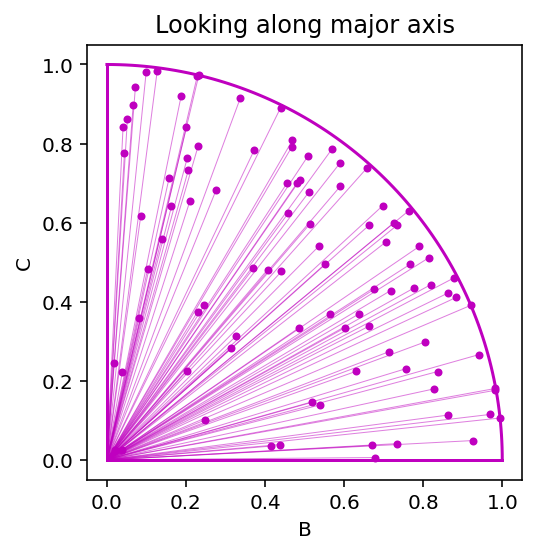

In [32]:
ang = np.linspace(0,np.pi/2,100)
plt.plot(np.cos(ang),np.sin(ang),c='m')
plt.xlabel('B')
plt.ylabel('C')
plt.axis('square')
plt.title('Looking along major axis')
plt.plot(np.array((0,0)),np.array((0,1)),c='m')
plt.plot(np.array((0,1)),np.array((0,0)),c='m')
#plt.plot(np.array((0,1)),c='m')

rhap_subs_v = np.zeros((95,3))
#rhap_subs_c = np.zeros((96,3))
rhap_host_v = np.zeros((95,3))
rhap_host_v_arr = np.zeros((95,3,3))
#host_b = np.zeros((96,3))
#host_c = np.zeros((96,3))
rhap_new_vs = np.zeros((95,3))
rhap_rs = np.zeros((95))
rhap_ts = np.zeros((95))
for i in range(95):
    #get eigen vectors and eigen values
    sw,sv = get_eigs(rhap_subs[i],rhap_host_rvirs[i])
    rhap_subs_v[i] += sv[0]
    #subs_c[i] += sv[2]
    hw,hv = get_eigs(rhap_host_no_norm[i],rhap_host_rvirs[i])
    rhap_host_v_arr[i] += hv
    rhap_host_v[i]+=hv[0]
    #host_c[i]+=hv[2]
    #host_b[i]+=hv[1]
    #check if eigenvectors are orthogonal
    check_ortho(hv)
    check_ortho(sv)
    
    #transform to frame of host halo
    new_v = transform(sv,hv)
    rhap_new_vs[i] += new_v[0]
    
    para = np.dot(new_v[0],hv[0]/norm(hv[0]))*(hv[0]/norm(hv[0]))
    perp = new_v[0]-para
    t = np.arccos(np.dot(new_v[0],hv[0])/(norm(new_v[0])*norm(hv[0])))
    p = np.arccos(np.dot(perp,hv[1])/(norm(hv[1])*norm(perp)))
    
    r = np.sqrt(np.sum(perp**2))
    plt.scatter(r*abs(np.cos(p)),r*abs(np.sin(p)),color='m',marker='.')
    plt.plot([0,r*abs(np.cos(p))],[0,r*abs(np.sin(p))],color='m',linewidth=0.5,alpha = 0.5)

plt.show()


KstestResult(statistic=0.39793501658002933, pvalue=4.4018333273329274e-14)


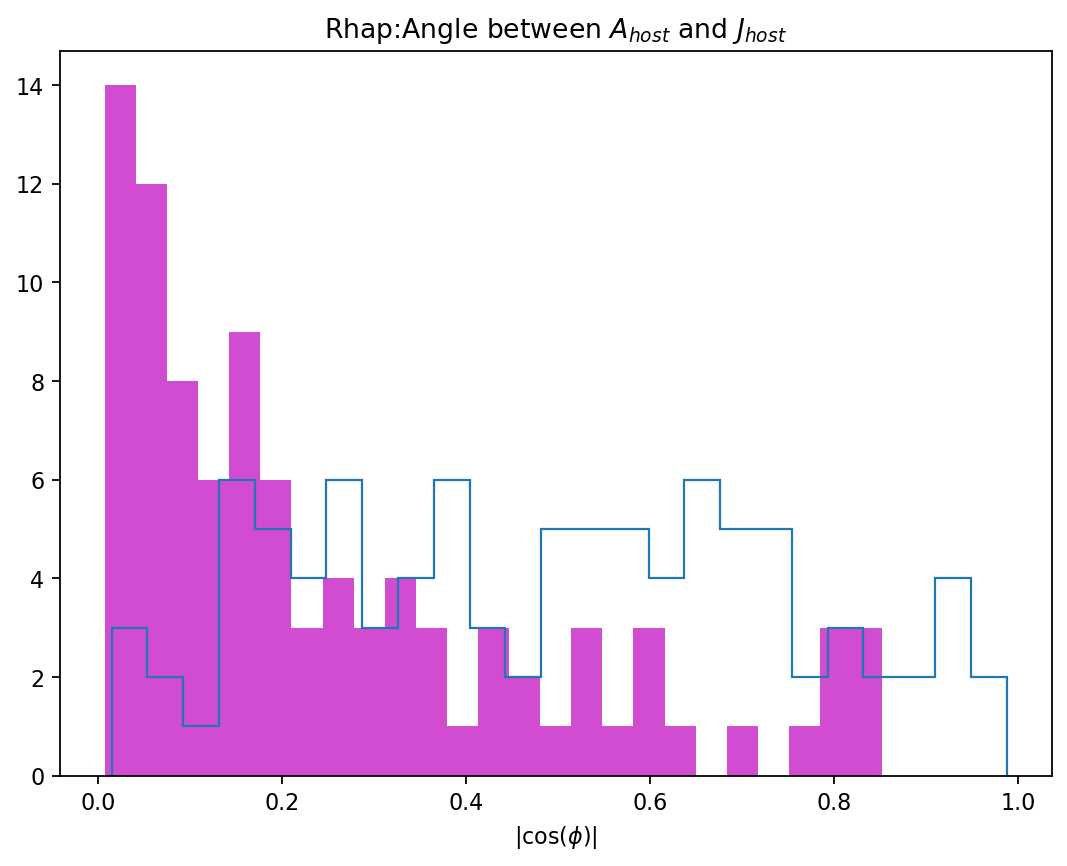

KstestResult(statistic=0.3978947368421053, pvalue=1.1836621397769451e-07)


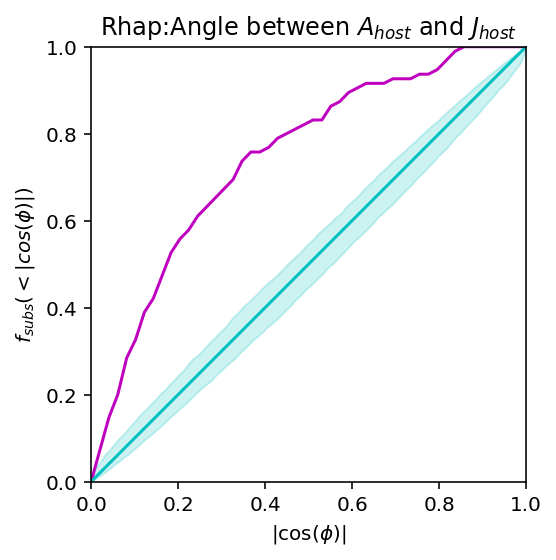

KstestResult(statistic=0.28421052631578947, pvalue=2.77145085834011e-07)


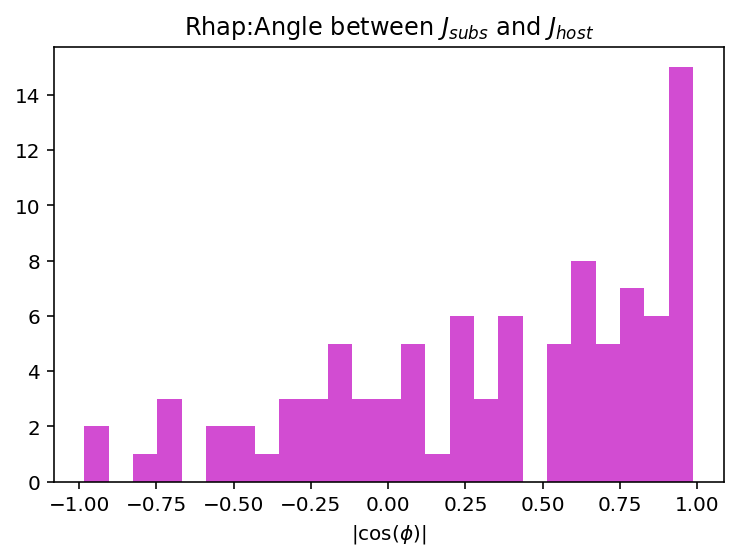

KstestResult(statistic=0.25157894736842107, pvalue=0.002823657381952227)


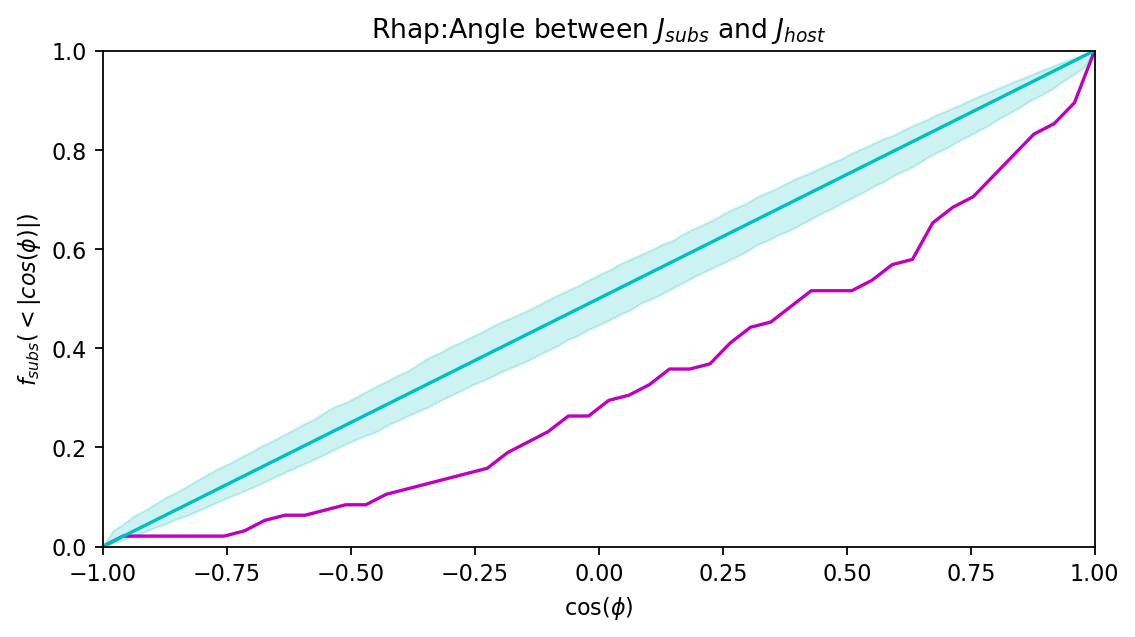

KstestResult(statistic=0.09412584248348971, pvalue=0.3473059433816825)


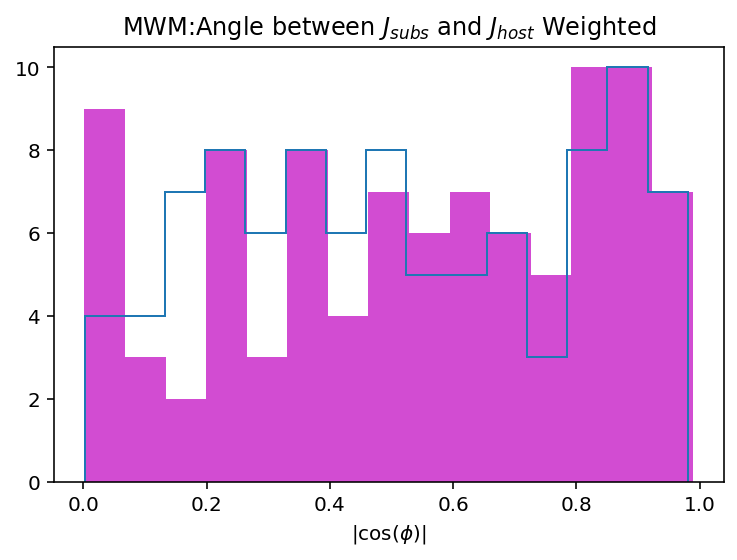

KstestResult(statistic=1.0, pvalue=0.0)


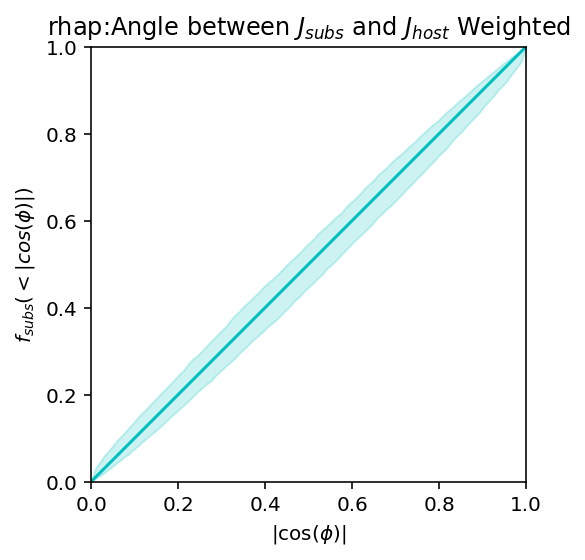

KstestResult(statistic=0.6876997594758836, pvalue=2.955008538285135e-45)


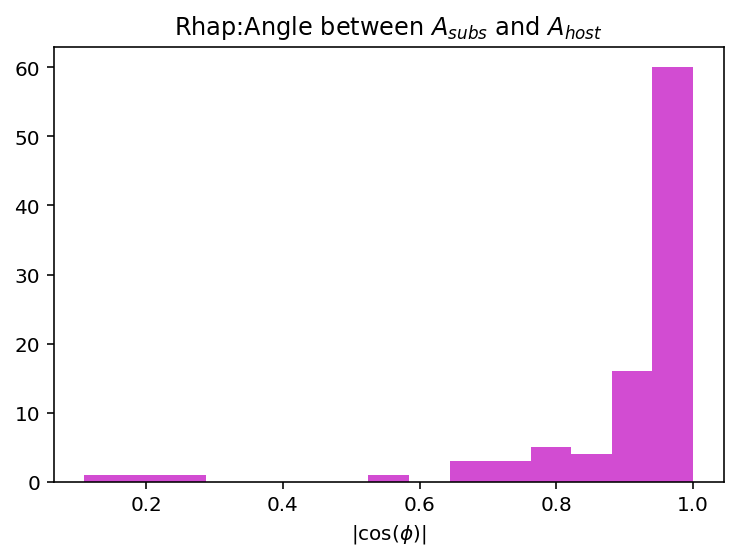

KstestResult(statistic=0.6799999999999999, pvalue=1.8843137492929046e-23)


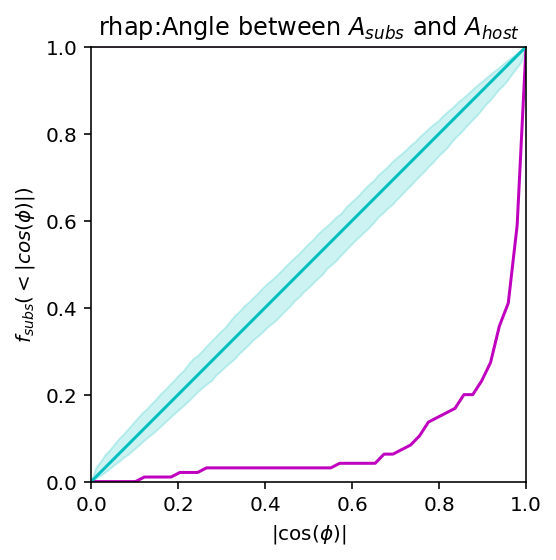

In [45]:
%matplotlib inline
plt.figure(figsize=(8, 6), dpi=80)

isotropic = np.random.uniform(0,1,95)
cdfs, iso_std,iso_percentile= MC_err('uniform',95,1000,0,1)

rhap_ahost_jhost_angs = abs(get_angles(rhap_host_v,j_rhap_host.T,95))
print(stats.kstest(abs(get_angles(rhap_host_v,j_rhap_host.T,95)),stats.uniform.cdf))
plt.hist(abs(rhap_ahost_jhost_angs),bins=25,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step',density=False,bins=25)
plt.title('Rhap:Angle between $A_{host}$ and $J_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.show()

lin_array = np.linspace(0,1,95)
print(stats.kstest(get_cumul_angles(rhap_ahost_jhost_angs,min_val=0.,num=50)[1],stats.uniform.cdf))
plt.plot(get_cumul_angles(rhap_ahost_jhost_angs,min_val=0.,num=50)[0],get_cumul_angles(rhap_ahost_jhost_angs,min_val=0.,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
err = bs_cumul_plot_err(rhap_ahost_jhost_angs,100, 100)
#plt.fill_between(get_cumul_angles(rhap_asubs_ahost_angs,num=50)[0],err[0],err[1],color='m',alpha=.25)
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.xlabel('|cos($\phi$)|')
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('Rhap:Angle between $A_{host}$ and $J_{host}$')
plt.show()

#####

isotropic = np.random.uniform(0,1,95)

rhap_jsubs_jhost_angs = (get_angles(j_rhap_subs.T,j_rhap_host.T,95))
print(stats.kstest((get_angles(j_rhap_subs.T,j_rhap_host.T,95)),stats.uniform.cdf))

plt.hist((rhap_jsubs_jhost_angs),bins=25,density=False,color='m',alpha=0.7)
#plt.hist(isotropic,histtype='step',density=False,bins=25)
plt.title('Rhap:Angle between $J_{subs}$ and $J_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.savefig('rhapsody_ang_mom_alignment_hist.png')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
print(stats.kstest(get_cumul_angles(rhap_jsubs_jhost_angs,min_val=-1,num=50)[1],stats.uniform.cdf))
plt.plot(get_cumul_angles(rhap_jsubs_jhost_angs,min_val=-1,num=50)[0],get_cumul_angles(rhap_jsubs_jhost_angs,min_val=-1,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
err = bs_cumul_plot_err(rhap_jsubs_jhost_angs,100, 100)
#plt.fill_between(get_cumul_angles(rhap_asubs_ahost_angs,num=50)[0],err[0],err[1],color='m',alpha=.25)
plt.plot([-1,1],[0,1],c='c')
lin_array = np.linspace(-1,1,95)
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(-1.,1.)
plt.xlabel('cos($\phi$)')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('Rhap:Angle between $J_{subs}$ and $J_{host}$')
plt.savefig('rhapsody_ang_mom_alignment.png')
plt.show()

#####
isotropic = np.random.uniform(0,1,95)

rhap_jsubs_jhost_w_angs = abs(get_angles(j_rhap_subs_w.T,j_rhap_host.T,95))
print(stats.kstest(abs(get_angles(j_rhap_subs_w.T,j_rhap_host.T,95)),stats.uniform.cdf))
plt.hist(rhap_jsubs_jhost_w_angs,bins=15,density=False,color='m',alpha=0.7)
plt.hist(isotropic,histtype='step',density=False,bins=15)
plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$ Weighted')
plt.xlabel('|cos($\phi$)|')
plt.show()

print(stats.kstest(get_cumul_angles(rhap_jsubs_jhost_w_angs,num=50)[1],stats.uniform.cdf))
plt.plot(get_cumul_angles(rhap_jsubs_jhost_w_angs,num=50)[0],get_cumul_angles(rhap_jsubs_jhost_w_angs,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
err = bs_cumul_plot_err(rhap_jsubs_jhost_w_angs,100, 100)
plt.fill_between(get_cumul_angles(rhap_jsubs_jhost_w_angs,num=50)[0],err[0],err[1],color='m',alpha=.25)
plt.plot([0,1],[0,1],c='c')
lin_array = np.linspace(0,1,95)

plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('rhap:Angle between $J_{subs}$ and $J_{host}$ Weighted')
plt.show()

#plt.hist(abs(get_angles(j_subs.T,j_host.T,95)),bins=15,density=False,color='m',alpha=0.7)
#plt.title('MWM:Angle between $J_{subs}$ and $J_{host}$')
#plt.xlabel('cos($\phi$)')
#plt.show()

#plt.hist(abs(get_angles(j_subs.T,host_b,95)),bins=15,density=False,color='m',alpha=0.7)
#plt.title('MWM:Angle between $J_{subs}$ and $C_{host}$')
#plt.xlabel('cos($\phi$)')
#plt.show()


isotropic = np.random.uniform(0,1,95)

rhap_asubs_ahost_angs = abs(get_angles(rhap_subs_v,rhap_host_v,95))
print(stats.kstest(abs(get_angles(rhap_subs_v,rhap_host_v,95)),stats.uniform.cdf))
plt.hist(abs(rhap_asubs_ahost_angs),bins=15,density=False,color='m',alpha=0.7)
#plt.hist(isotropic,histtype='step')
plt.title('Rhap:Angle between $A_{subs}$ and $A_{host}$')
plt.xlabel('|cos($\phi$)|')
plt.savefig('rhapsody_maj_axis_alignment_hist.png')
plt.show()


plt.plot(get_cumul_angles(rhap_asubs_ahost_angs,min_val=0.,num=50)[0],get_cumul_angles(rhap_asubs_ahost_angs,min_val=0.,num=50)[1],c='m')#,label='{}'.format(np.log10(mvirs[i])))
err = bs_cumul_plot_err(rhap_asubs_ahost_angs,100, 100)
plt.fill_between(get_cumul_angles(rhap_asubs_ahost_angs,min_val=0.,num=50)[0],err[0],err[1],color='m',alpha=.25)
print(stats.kstest(get_cumul_angles(rhap_asubs_ahost_angs,min_val=0.,num=50)[1],stats.uniform.cdf))
#for i in range(95):
#    plt.scatter(get_cumul_angles(asubs_ahost_angs,num=95)[0][i],get_cumul_angles(asubs_ahost_angs,num=95)[1][i],color=cm.cool(np.argsort(mvirs)[i]/40),alpha=1)
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.ylim(0.,1.)
plt.xlim(0.,1.)
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('rhap:Angle between $A_{subs}$ and $A_{host}$')
plt.savefig('rhapsody_maj_axis_alignment.png')
plt.show()


In [16]:
np.save('rhap_maj_axis_align.npy',rhap_asubs_ahost_angs)

In [24]:
rhap_TU_vals = np.load('rhap_TU_vals.npy')
rhap_TU_vals = np.delete(rhap_TU_vals,46)

#rhap_90_mass_scale = np.delete(rhap_90_mass_scale,46)
#rhap_25_mass_scale = np.delete(rhap_25_mass_scale,46)

In [ ]:
plt.hist(mwm_all_spin*(0.26**(1/6)),bins=40,alpha=0.24,label='MWM')
plt.hist(rhap_all_spin*(0.26**(1/6)),bins=25,alpha=0.24,label='Rhap')
plt.axvline(0.05,linestyle=':',color='Red',label='>high')
plt.axvline(0.03,linestyle=':',color='Green',label='<low')
plt.legend()
plt.show()

print('hi spin rhap: {}'.format(len(rhap_all_spin[rhap_all_spin*(0.26**(1/6))>=0.05])))
print('hi spin mwm: {}'.format(len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))>=0.05])))

print('lo spin rhap: {}'.format(len(rhap_all_spin[rhap_all_spin*(0.26**(1/6))<=0.03])))
print('lo spin mwm: {}'.format(len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))<=0.03])))

print('med spin rhap: {}'.format(95-len(rhap_all_spin[rhap_all_spin*(0.26**(1/6))>=0.05])-len(rhap_all_spin[rhap_all_spin*(0.26**(1/6))<=0.03])))
print('med spin mwm: {}'.format(45-len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))>=0.05])-len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))<=0.03])))


r_cut_hi = tuple([rhap_all_spin*(0.26**(1/6))>0.05])
r_cut_hihi = tuple([rhap_all_spin*(0.26**(1/6))>0.1])
r_cut_lo = tuple([rhap_all_spin*(0.26**(1/6))<0.03])
r_cut_med = np.logical_and(rhap_all_spin*(0.26**(1/6))<=0.05,rhap_all_spin*(0.26**(1/6))>=0.03)
m_cut_hi = tuple([mwm_all_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_all_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_all_spin*(0.26**(1/6))<=0.05,mwm_all_spin*(0.26**(1/6))>=0.03)

r_cut_hi2 = tuple([rhap_mass_cut_spin_all*(0.26**(1/6))>0.05])
r_cut_hihi2 = tuple([rhap_mass_cut_spin_all*(0.26**(1/6))>0.1])
r_cut_lo2 = tuple([rhap_mass_cut_spin_all*(0.26**(1/6))<0.03])
r_cut_med2 = np.logical_and(rhap_mass_cut_spin_all*(0.26**(1/6))<=0.05,rhap_mass_cut_spin_all*(0.26**(1/6))>=0.03)

m_cut_hi = tuple([mwm_sub_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_sub_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_sub_spin*(0.26**(1/6))<=0.05,mwm_sub_spin*(0.26**(1/6))>=0.03)

plt.hist(rhap_jsubs_jhost_angs[r_cut_hi],alpha=0.2,label='hi')
#plt.hist(rhap_jsubs_jhost_angs[r_cut_hihi],alpha=0.2,label='hi hi')
plt.hist(rhap_jsubs_jhost_angs[r_cut_lo],alpha=0.2,label='lo')
plt.hist(rhap_jsubs_jhost_angs[r_cut_med],alpha=0.2,label='med')

#plt.hist(angs8[r_cut_hi2],label='hi',bins=15,color='m',histtype = 'step')
plt.hist(angs8[r_cut_lo2],alpha=0.2,label='mass_cut_lo',bins=15,color='c',histtype = 'step')
#plt.hist(angs8[r_cut_med2],alpha=0.2,label='med',bins=15,color='green',histtype = 'step')
plt.title('Rhapsody: All particles')
plt.legend()
plt.show()

plt.hist(jsubs_jhost_angs[m_cut_hi],alpha=0.2,label='hi')
plt.hist(jsubs_jhost_angs[m_cut_lo],alpha=0.2,label='lo')
plt.hist(jsubs_jhost_angs[m_cut_med],alpha=0.2,label='med')
plt.title('MWM: All particles')
#plt.hist(j,alpha=0.2)
plt.legend()
plt.show()

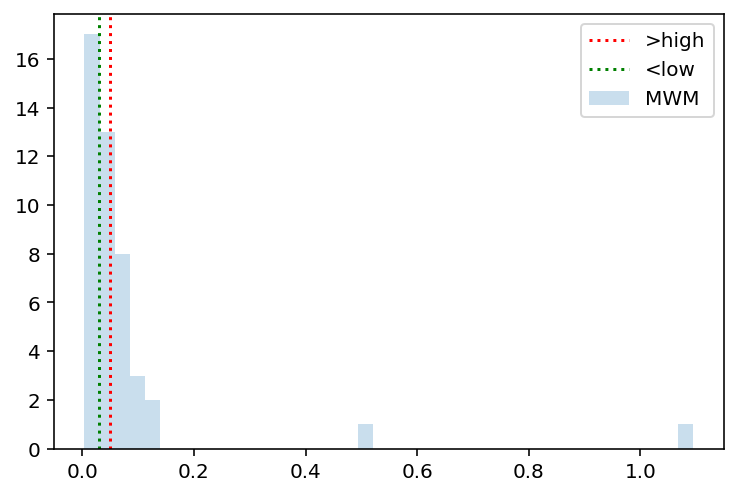

hi spin mwm: 17
lo spin mwm: 17
med spin mwm: 11


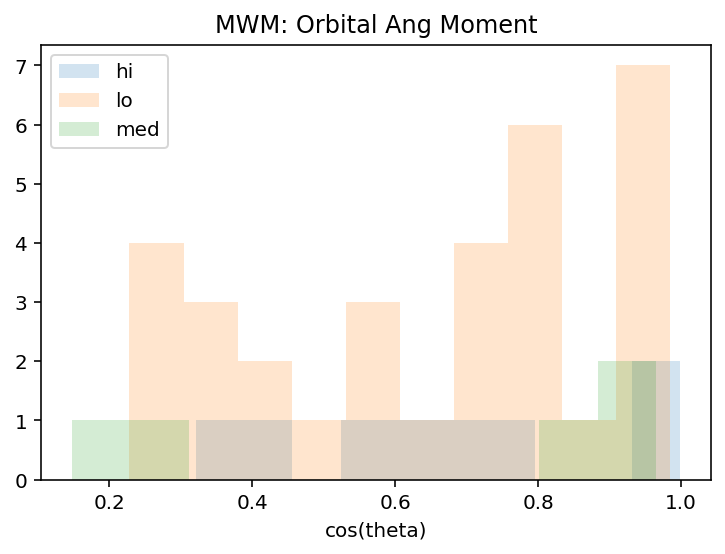

In [133]:
Lsubs_jhost_angs = abs(get_angles(Ls,j_host.T,45))

plt.hist(mwm_all_spin*(0.26**(1/6)),bins=40,alpha=0.24,label='MWM')
plt.axvline(0.05,linestyle=':',color='Red',label='>high')
plt.axvline(0.03,linestyle=':',color='Green',label='<low')
plt.legend()
plt.show()

print('hi spin mwm: {}'.format(len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))>=0.05])))

print('lo spin mwm: {}'.format(len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))<=0.03])))

print('med spin mwm: {}'.format(45-len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))>=0.05])-len(mwm_all_spin[mwm_all_spin*(0.26**(1/6))<=0.03])))


m_cut_hi = tuple([mwm_all_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_all_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_all_spin*(0.26**(1/6))<=0.05,mwm_all_spin*(0.26**(1/6))>=0.03)

m_cut_hi = tuple([mwm_sub_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_sub_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_sub_spin*(0.26**(1/6))<=0.05,mwm_sub_spin*(0.26**(1/6))>=0.03)


plt.hist(Lsubs_jhost_angs[m_cut_hi],alpha=0.2,label='hi')
plt.hist(Lsubs_jhost_angs[m_cut_lo],alpha=0.2,label='lo')
plt.hist(Lsubs_jhost_angs[m_cut_med],alpha=0.2,label='med')
plt.title('MWM: Orbital Ang Moment')
plt.xlabel('cos(theta)')
#plt.hist(j,alpha=0.2)
plt.legend()
plt.show()

/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/1661600113.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angs = np.concatenate(np.array(L_J_angles)[cut])
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/1661600113.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angs = np.concatenate(np.array(L_J_angles)[cut])
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/1661600113.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples

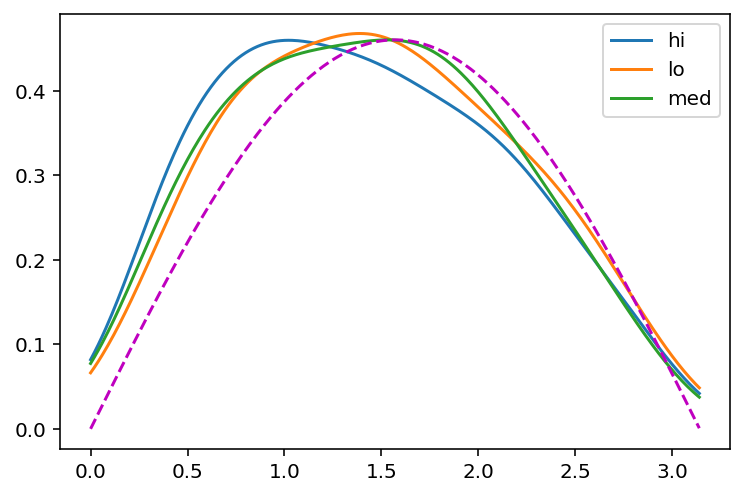

In [160]:
m_cut_hi = tuple([mwm_all_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_all_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_all_spin*(0.26**(1/6))<=0.05,mwm_all_spin*(0.26**(1/6))>=0.03)

#m_cut_hi = tuple([mwm_host_spin*(0.26**(1/6))>0.05])
#m_cut_lo = tuple([mwm_host_spin*(0.26**(1/6))<0.03])
#m_cut_med = np.logical_and(mwm_host_spin*(0.26**(1/6))<=0.05,mwm_host_spin*(0.26**(1/6))>=0.03)

#m_cut_hi = tuple([mwm_sub_spin*(0.26**(1/6))>0.05])
#m_cut_lo = tuple([mwm_sub_spin*(0.26**(1/6))<0.03])
#m_cut_med = np.logical_and(mwm_sub_spin*(0.26**(1/6))<=0.05,mwm_sub_spin*(0.26**(1/6))>=0.03)

labels = ['hi','lo','med']
for i,cut in enumerate([m_cut_hi,m_cut_lo,m_cut_med]):
    # fit density
    model = KernelDensity(bandwidth=.25, kernel='gaussian')
    angs = np.concatenate(np.array(L_J_angles)[cut])
    #angs = L_J_angles_tot[cut]
    sample = np.arccos(angs).reshape(len(angs), 1)
    model.fit(sample)
    # sample probabilities for a range of outcomes
    values = np.arange(0,np.pi,0.01)
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    # plot the histogram and pdf
    #plt.hist(sample, bins=50, density=True)
    plt.plot(values[:], probabilities,label=labels[i])
plt.legend()
plt.plot(values, np.sin(values)*max(probabilities),linestyle='--',color='m')
plt.show()


/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/3054356773.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angs = np.concatenate(np.array(L_J_angles_rhap)[cut])
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/3054356773.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  angs = np.concatenate(np.array(L_J_angles_rhap)[cut])
/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/3054356773.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists

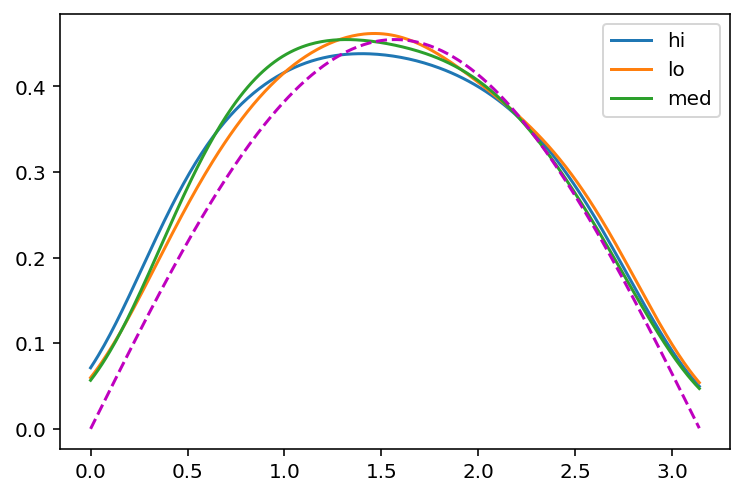

In [299]:
r_cut_hi = tuple([rhap_all_spin*(0.26**(1/6))>0.05])
r_cut_lo = tuple([rhap_all_spin*(0.26**(1/6))<0.03])
r_cut_med = np.logical_and(rhap_all_spin*(0.26**(1/6))<=0.05,rhap_all_spin*(0.26**(1/6))>=0.03)

#m_cut_hi = tuple([rhap_host_spin*(0.26**(1/6))>0.05])
#m_cut_lo = tuple([rhap_host_spin*(0.26**(1/6))<0.03])
#m_cut_med = np.logical_and(rhap_host_spin*(0.26**(1/6))<=0.05,rhap_host_spin*(0.26**(1/6))>=0.03)

#m_cut_hi = tuple([rhap_sub_spin*(0.26**(1/6))>0.05])
#m_cut_lo = tuple([rhap_sub_spin*(0.26**(1/6))<0.03])
#m_cut_med = np.logical_and(rhap_sub_spin*(0.26**(1/6))<=0.05,rhap_sub_spin*(0.26**(1/6))>=0.03)

labels = ['hi','lo','med']
for i,cut in enumerate([r_cut_hi,r_cut_lo,r_cut_med]):
    # fit density
    model = KernelDensity(bandwidth=.25, kernel='gaussian')
    angs = np.concatenate(np.array(L_J_angles_rhap)[cut])
    #angs = L_J_angles_tot_rhap[cut]
    sample = np.arccos(angs).reshape(len(angs), 1)
    model.fit(sample)
    # sample probabilities for a range of outcomes
    values = np.arange(0,np.pi,0.01)
    values = values.reshape((len(values), 1))
    probabilities = model.score_samples(values)
    probabilities = np.exp(probabilities)
    # plot the histogram and pdf
    #plt.hist(sample, bins=50, density=True)
    plt.plot(values[:], probabilities,label=labels[i])
plt.legend()
plt.plot(values, np.sin(values)*max(probabilities),linestyle='--',color='m')
plt.show()

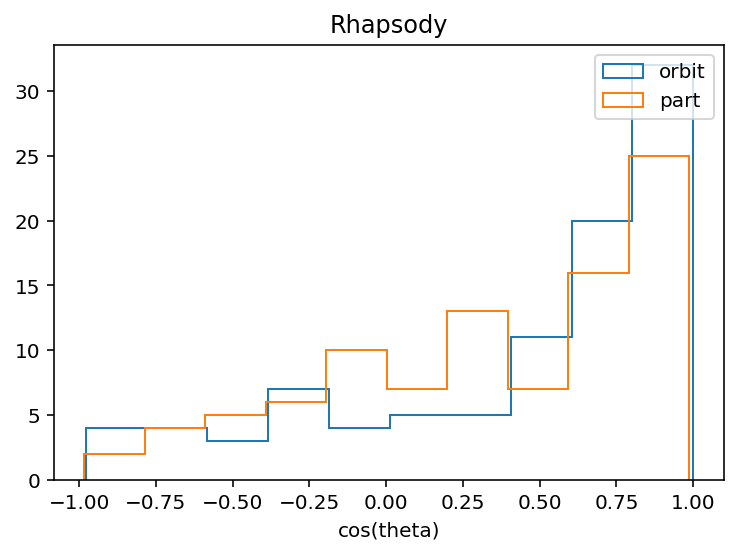

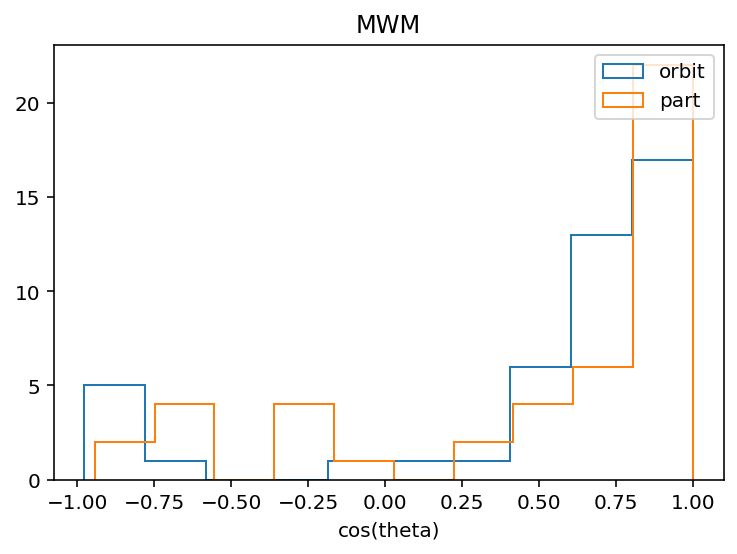

: 

In [318]:
plt.hist((L_J_angles_tot_rhap),histtype='step',label='orbit')
plt.hist(get_angles(j_rhap_subs.T,j_rhap_host.T,95),histtype='step',label='part')
plt.title('Rhapsody')
plt.xlabel('cos(theta)')
plt.legend()
plt.show()

plt.hist((L_J_angles_tot),histtype='step',label='orbit')
plt.hist(get_angles(j_subs.T,j_host.T,45),histtype='step',label='part')
plt.title('MWM')
plt.xlabel('cos(theta)')
plt.legend()
plt.show()

hi spin rhap: 32
hi spin mwm: 6
lo spin rhap: 47
lo spin mwm: 32
med spin rhap: 16
med spin mwm: 7


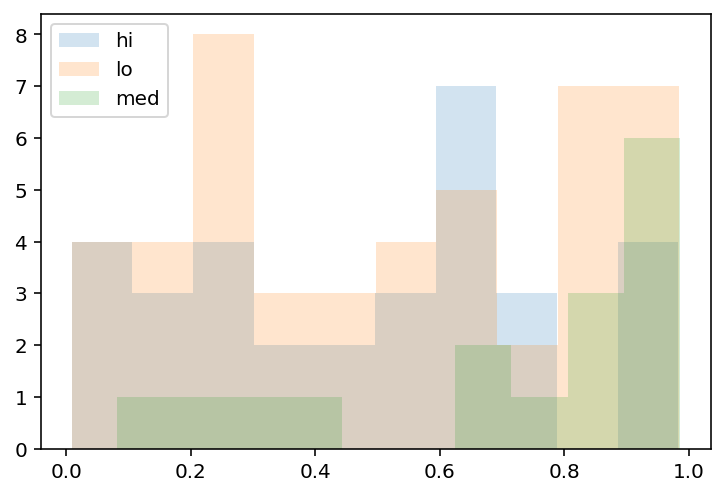

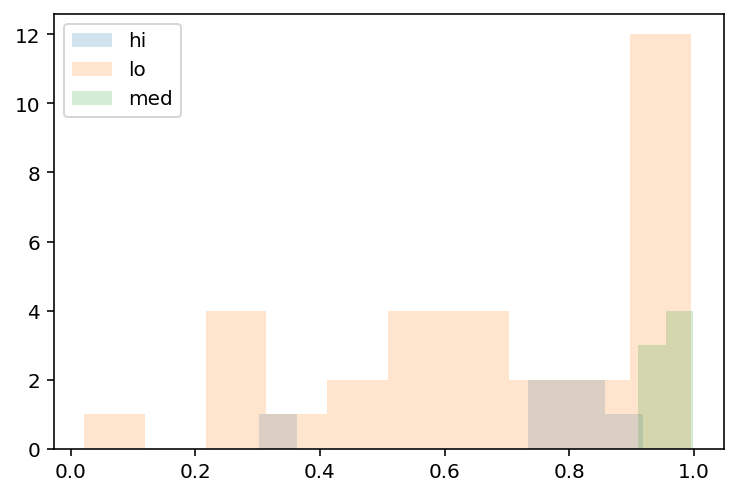

In [86]:
print('hi spin rhap: {}'.format(len(rhap_host_spin[rhap_host_spin*(0.26**(1/6))>=0.05])))
print('hi spin mwm: {}'.format(len(mwm_host_spin[mwm_host_spin*(0.26**(1/6))>=0.05])))

print('lo spin rhap: {}'.format(len(rhap_host_spin[rhap_host_spin*(0.26**(1/6))<=0.03])))
print('lo spin mwm: {}'.format(len(mwm_host_spin[mwm_host_spin*(0.26**(1/6))<=0.03])))

print('med spin rhap: {}'.format(95-len(rhap_host_spin[rhap_host_spin*(0.26**(1/6))>=0.05])-len(rhap_host_spin[rhap_host_spin*(0.26**(1/6))<=0.03])))
print('med spin mwm: {}'.format(45-len(mwm_host_spin[mwm_host_spin*(0.26**(1/6))>=0.05])-len(mwm_host_spin[mwm_host_spin*(0.26**(1/6))<=0.03])))

r_cut_hi = tuple([rhap_host_spin*(0.26**(1/6))>0.05])
r_cut_hihi = tuple([rhap_host_spin*(0.26**(1/6))>0.1])
r_cut_lo = tuple([rhap_host_spin*(0.26**(1/6))<0.03])
r_cut_med = np.logical_and(rhap_host_spin*(0.26**(1/6))<=0.05,rhap_host_spin*(0.26**(1/6))>=0.03)
m_cut_hi = tuple([mwm_host_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_host_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_host_spin*(0.26**(1/6))<=0.05,mwm_host_spin*(0.26**(1/6))>=0.03)

plt.hist(rhap_jsubs_jhost_angs[r_cut_hi],alpha=0.2,label='hi')
#plt.hist(rhap_jsubs_jhost_angs[r_cut_hihi],alpha=0.2,label='hi hi')
plt.hist(rhap_jsubs_jhost_angs[r_cut_lo],alpha=0.2,label='lo')
plt.hist(rhap_jsubs_jhost_angs[r_cut_med],alpha=0.2,label='med')
plt.legend()
plt.show()

plt.hist(jsubs_jhost_angs[m_cut_hi],alpha=0.2,label='hi',bins=10)
plt.hist(jsubs_jhost_angs[m_cut_lo],alpha=0.2,label='lo',bins=10)
plt.hist(jsubs_jhost_angs[m_cut_med],alpha=0.2,label='med',bins=2)

#plt.hist(j,alpha=0.2)
plt.legend()
plt.show()

In [87]:
rhap_mass_cut_spin = np.load('rhap_mass_cut_spin.npy')
rhap_mass_cut_spin = np.delete(rhap_mass_cut_spin,46)

rhap_mass_cut_spin_all = np.load('rhap_mass_cut_spin_all.npy')
rhap_mass_cut_spin_all = np.delete(rhap_mass_cut_spin_all,46)

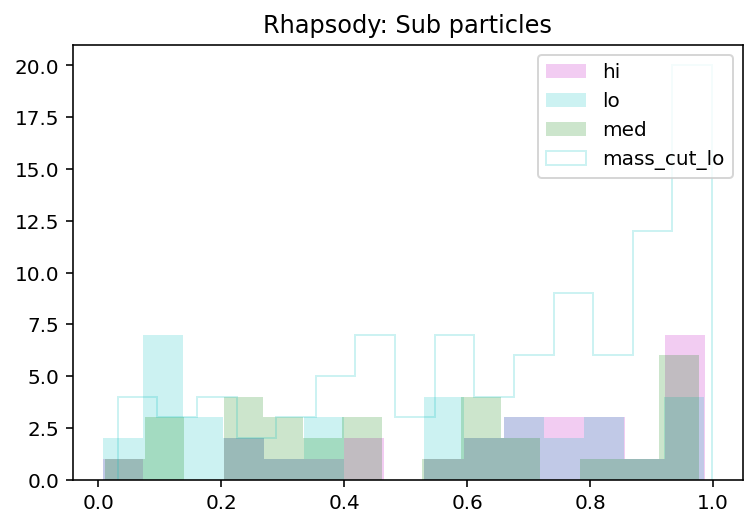

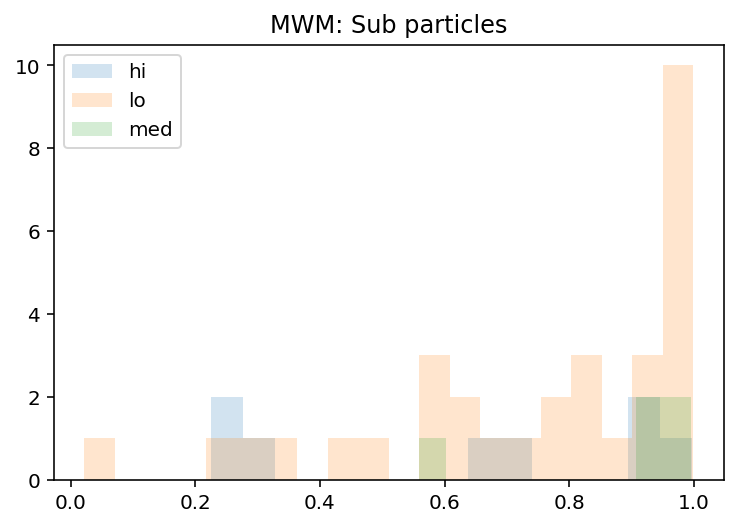

hi spin rhap: 27
hi spin mwm: 8
lo spin rhap: 37
lo spin mwm: 32
med spin rhap: 31
med spin mwm: 5


In [93]:
r_cut_hi = tuple([rhap_sub_spin*(0.26**(1/6))>0.05])
r_cut_hihi = tuple([rhap_sub_spin*(0.26**(1/6))>0.1])
r_cut_lo = tuple([rhap_sub_spin*(0.26**(1/6))<0.03])

r_cut_hi2 = tuple([rhap_mass_cut_spin*(0.26**(1/6))>0.05])
r_cut_hihi2 = tuple([rhap_mass_cut_spin*(0.26**(1/6))>0.1])
r_cut_lo2 = tuple([rhap_mass_cut_spin*(0.26**(1/6))<0.03])
r_cut_med2 = np.logical_and(rhap_mass_cut_spin*(0.26**(1/6))<=0.05,rhap_mass_cut_spin*(0.26**(1/6))>=0.03)

r_cut_med = np.logical_and(rhap_sub_spin*(0.26**(1/6))<=0.05,rhap_sub_spin*(0.26**(1/6))>=0.03)
m_cut_hi = tuple([mwm_sub_spin*(0.26**(1/6))>0.05])
m_cut_lo = tuple([mwm_sub_spin*(0.26**(1/6))<0.03])
m_cut_med = np.logical_and(mwm_sub_spin*(0.26**(1/6))<=0.05,mwm_sub_spin*(0.26**(1/6))>=0.03)

plt.hist(rhap_jsubs_jhost_angs[r_cut_hi],alpha=0.2,label='hi',bins=15,color='m')
plt.hist(rhap_jsubs_jhost_angs[r_cut_lo],alpha=0.2,label='lo',bins=15,color='c')
plt.hist(rhap_jsubs_jhost_angs[r_cut_med],alpha=0.2,label='med',bins=15,color='green')

#plt.hist(angs8[r_cut_hi2],label='hi',bins=15,color='m',histtype = 'step')
plt.hist(angs8[r_cut_lo2],alpha=0.2,label='mass_cut_lo',bins=15,color='c',histtype = 'step')
#plt.hist(angs8[r_cut_med2],alpha=0.2,label='med',bins=15,color='green',histtype = 'step')
plt.title('Rhapsody: Sub particles')
plt.legend()
plt.show()

plt.hist(jsubs_jhost_angs[m_cut_hi],alpha=0.2,label='hi',bins=15)
plt.hist(jsubs_jhost_angs[m_cut_lo],alpha=0.2,label='lo',bins=20)
plt.hist(jsubs_jhost_angs[m_cut_med],alpha=0.2,label='med')
plt.title('MWM: Sub particles')
plt.legend()
plt.show()
print('hi spin rhap: {}'.format(len(rhap_sub_spin[rhap_sub_spin*(0.26**(1/6))>=0.05])))
print('hi spin mwm: {}'.format(len(mwm_sub_spin[mwm_sub_spin*(0.26**(1/6))>=0.05])))

print('lo spin rhap: {}'.format(len(rhap_sub_spin[rhap_sub_spin*(0.26**(1/6))<=0.03])))
print('lo spin mwm: {}'.format(len(mwm_sub_spin[mwm_sub_spin*(0.26**(1/6))<=0.03])))

print('med spin rhap: {}'.format(95-len(rhap_sub_spin[rhap_sub_spin*(0.26**(1/6))>=0.05])-len(rhap_sub_spin[rhap_sub_spin*(0.26**(1/6))<=0.03])))
print('med spin mwm: {}'.format(45-len(mwm_sub_spin[mwm_sub_spin*(0.26**(1/6))>=0.05])-len(mwm_sub_spin[mwm_sub_spin*(0.26**(1/6))<=0.03])))

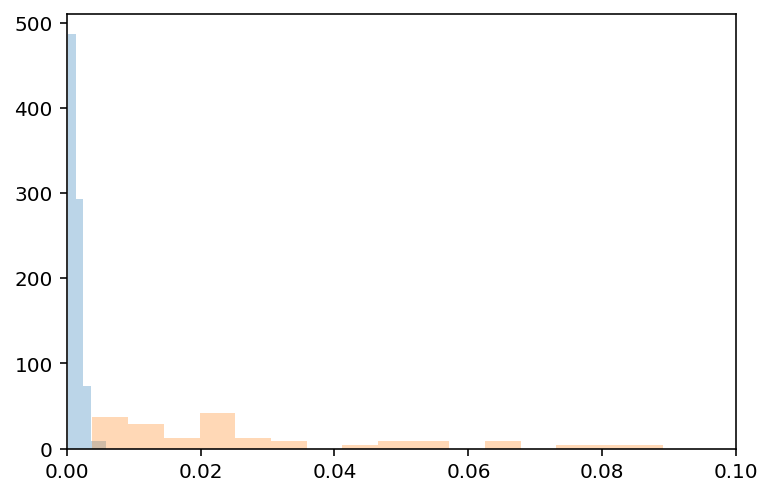

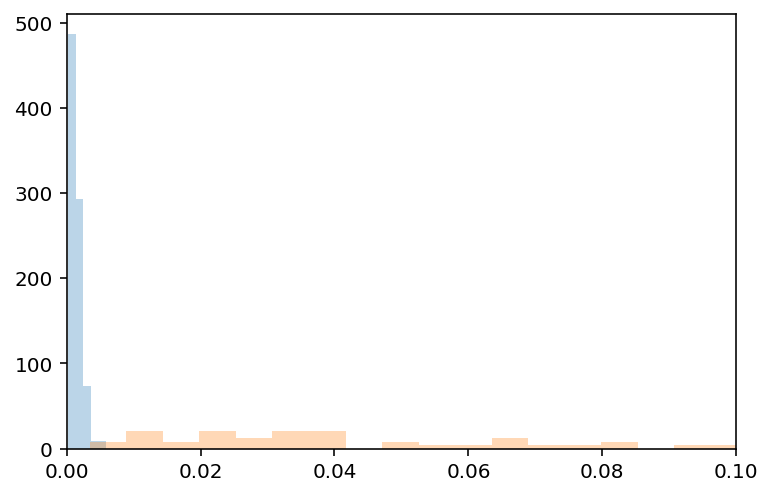

In [89]:
plt.hist(rhap_mass_cut_spin*(0.26**(1/6)),density=True,bins=5,alpha=0.3)
plt.hist(mwm_sub_spin*(0.26**(1/6)),density=True,bins=200,alpha=0.3)
plt.xlim(0,.1)
plt.show()

plt.hist(rhap_mass_cut_spin_all*(0.26**(1/6)),density=True,bins=5,alpha=0.3)
plt.hist(mwm_all_spin*(0.26**(1/6)),density=True,bins=200,alpha=0.3)
plt.xlim(0,.1)
plt.show()

virial
pearsonr correlation: 0.212
pearsonr err: 0.107


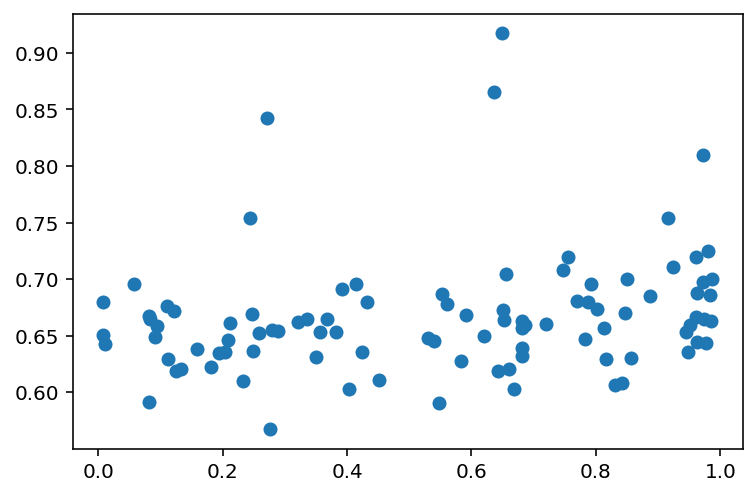

50% mass scale
pearsonr correlation: -0.103
pearsonr err: 0.103


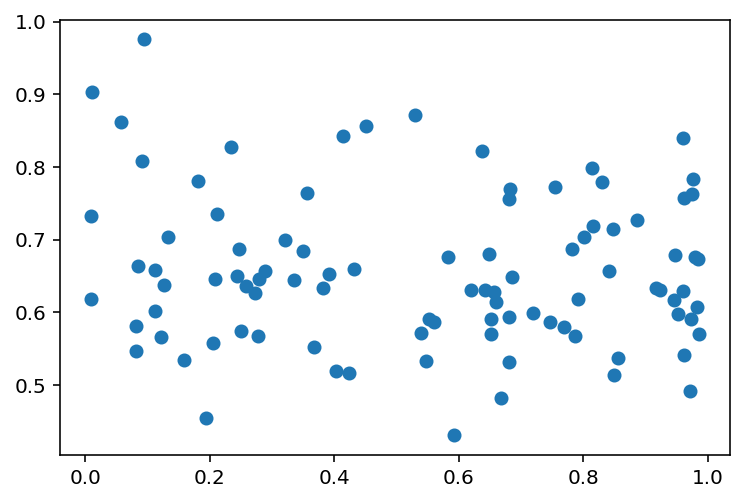

Mass
pearsonr correlation: -0.049
pearsonr err: 0.106


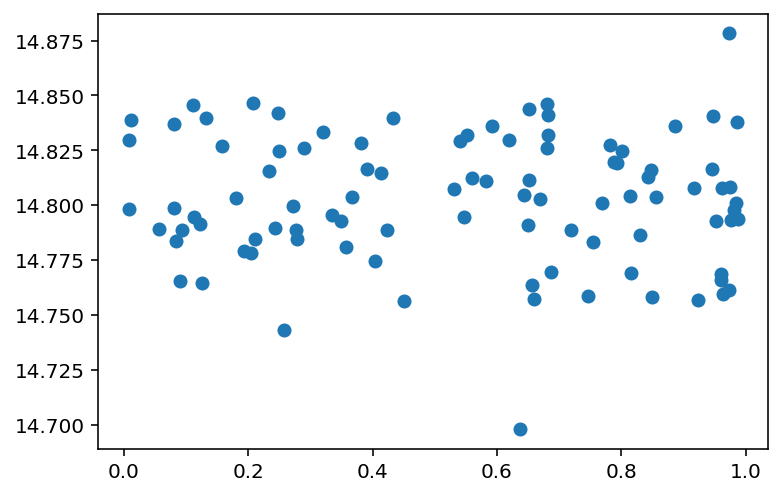

In [230]:
print('virial')
plt.scatter(rhap_jsubs_jhost_angs,rhap_TU_vals)

corr, _ = stats.pearsonr(rhap_jsubs_jhost_angs,rhap_TU_vals)
print('pearsonr correlation: %.3f' % corr)

pear_err = pearsonr_err(95, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0)
print('pearsonr err: %.3f' % pear_err)

plt.show()

print('50% mass scale')
plt.scatter(rhap_jsubs_jhost_angs,rhap_50_mass_scale)

corr, _ = stats.pearsonr(rhap_jsubs_jhost_angs,rhap_50_mass_scale)
print('pearsonr correlation: %.3f' % corr)
pear_err = pearsonr_err(95, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0)
print('pearsonr err: %.3f' % pear_err)

plt.show()

print('Mass')
plt.scatter(rhap_jsubs_jhost_angs,np.log10(rhap_host_mvirs))

corr, _ = stats.pearsonr(rhap_jsubs_jhost_angs,np.log10(rhap_host_mvirs))
print('pearsonr correlation: %.3f' % corr)
pear_err = pearsonr_err(95, n_rep=1000, val_min1 = 0.0, val_max1 = 1.0,val_min2 = 0.0, val_max2 = 1.0)
print('pearsonr err: %.3f' % pear_err)

plt.show()


In [295]:
L_J_angles_rhap = []
L_J_angles_tot_rhap = np.zeros(95)
J_J_angles_rhap = []
J_J_angles_tot_rhap = np.zeros(95)
L_J_sub_angles_tot = np.zeros(95)
L_dispersion_rhap = np.zeros((95))
J_dispersion_rhap = np.zeros((95))
j_rhap_subs_2 = np.zeros((95,3))
for j in range(95):
    this_halo = rhap_halo_names[j]
    r_sub_pos = np.load('rhap_sub_pos_2/{}_sub_pos_2.npy'.format(this_halo))
    r_sub_mass = np.load('rhap_sub_mass_2/{}_sub_mass_2.npy'.format(this_halo))
    r_sub_vel = np.load('rhap_sub_vel/{}_sub_vel.npy'.format(this_halo))
    rhap_sub_j = np.load('rhap_sub_js/{}_sub_js.npy'.format(this_halo))

    J_dispersion_rhap[j] += np.std(np.sqrt(np.sum(rhap_sub_j.T**2,axis=1)))
    J_J_angles_rhap.append(get_angles_1vect(rhap_sub_j,j_rhap_host.T[j],len(rhap_sub_j)))

    L = r_sub_mass*np.cross(r_sub_pos,r_sub_vel).T
    L_dispersion_rhap[j] += np.std(np.sqrt(np.sum(L**2,axis=1)))
    L_J_angles_rhap.append(get_angles_1vect(L.T,j_rhap_host.T[j],len(L.T)))

    L = get_ang_moment(rhap_host_mvirs[j],r_sub_pos,r_sub_vel)
    L_J_angles_tot_rhap[j]+=get_angle(L,j_rhap_host.T[j])

    L_J_sub_angles_tot[j]+=get_angle(np.sum(rhap_sub_j.T,axis=1),L)
    J_J_angles_tot_rhap[j]+=get_angle(np.sum(rhap_sub_j.T,axis=1),j_rhap_host.T[j])
    j_rhap_subs_2[j]+=np.sum(rhap_sub_j.T,axis=1)
    del r_sub_pos, r_sub_mass, r_sub_vel, rhap_sub_j


In [311]:
print(stats.kstest(get_cumul_angles((L_J_angles_tot_rhap),num=50)[1],stats.uniform.cdf))
print(stats.kstest(get_cumul_angles((J_J_angles_tot_rhap),num=50)[1],stats.uniform.cdf))
print(stats.kstest(get_cumul_angles((get_angles(j_rhap_subs.T,j_rhap_host.T,95)),num=50)[1],stats.uniform.cdf))


KstestResult(statistic=0.22105263157894736, pvalue=0.012591410358213317)
KstestResult(statistic=0.28421052631578947, pvalue=0.00045633878323753893)
KstestResult(statistic=0.28421052631578947, pvalue=0.00045633878323753893)


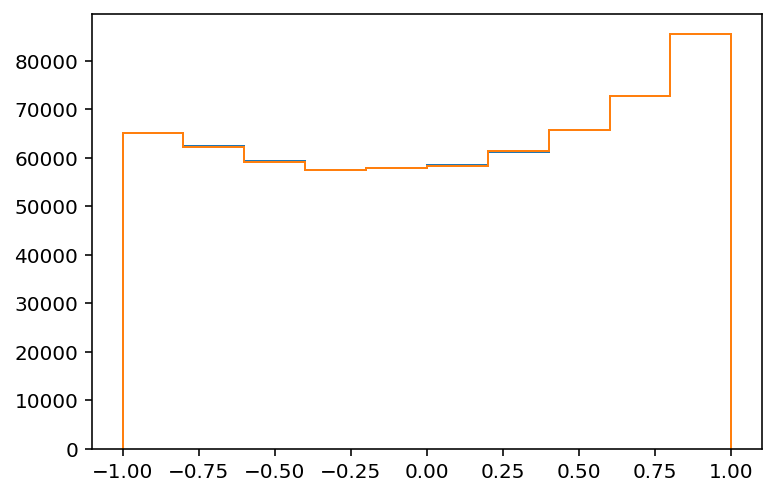

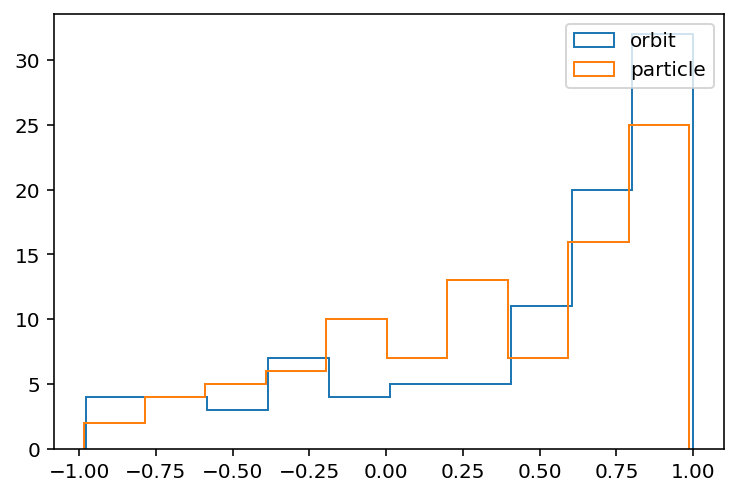

In [316]:
plt.hist(np.concatenate(L_J_angles_rhap),histtype='step')
plt.hist(np.concatenate(J_J_angles_rhap),histtype='step')
plt.show()

plt.hist(L_J_angles_tot_rhap,label='orbit',histtype='step')
plt.hist((J_J_angles_tot_rhap),label='particle',histtype='step')
plt.legend()
#plt.hist((get_angles(j_rhap_subs.T,j_rhap_host.T,95)))
plt.show()

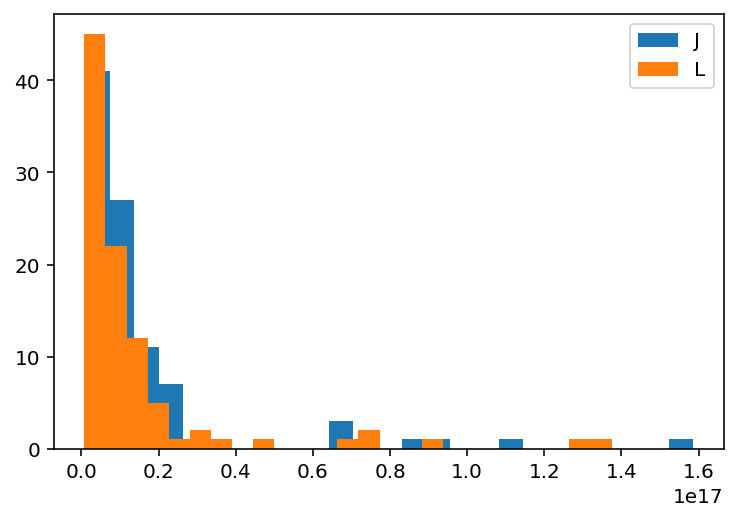

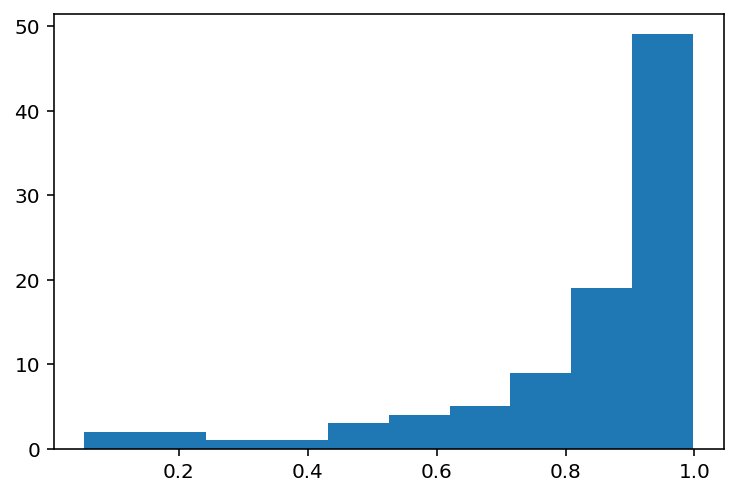

In [258]:
plt.hist(J_dispersion_rhap,label='J',bins=25)
plt.hist(L_dispersion_rhap,label='L',bins=25)
plt.legend()
plt.show()

plt.hist(abs(L_J_sub_angles_tot))
plt.show()

In [37]:
rhap_mass_frac_A = np.zeros(95)
rhap_mass_frac_C = np.zeros(95)
rhap_mass_frac_B = np.zeros(95)
rhap_mass_frac_random = np.zeros(int(95*5))
rhap_sub_pos = []
rhap_sub_mass = []
rhap_sub_mass_sum = []
#tx = np.random.random()*90.0
#ty = np.random.random()*90.0
#tz = np.random.random()*90.0

for j in range(95):
    this_halo = rhap_halo_names[j]
    with np.load('rhap_sub_pos/rhap_sub_pos_{}.npy'.format(this_halo)) as r_sub_pos:
        rhap_sub_pos.append(r_sub_pos)

    with np.load('rhap_sub_mass/rhap_sub_mvir_{}.npy'.format(this_halo)) as r_sub_mass:
        rhap_sub_mass.append(r_sub_mass)

    new_pos = transform(r_sub_pos.T,rhap_host_v_arr[j]).T

    para = np.zeros(np.shape(new_pos))
    perp = np.zeros(np.shape(new_pos))
    p = np.zeros(len(new_pos))
    t = np.zeros(len(new_pos))
    hA = rhap_host_v_arr[j][0]
    hB = rhap_host_v_arr[j][1]
    hC = rhap_host_v_arr[j][2]

    for i in range(len(new_pos)):
        para[i]+=np.dot(new_pos[i],hA/norm(hA))*(hA/norm(hA))
        perp[i]+=new_pos[i]-para[i]
        t[i]+=np.arccos(np.dot(new_pos[i],hA)/(norm(new_pos[i])*norm(hA)))
        p[i]+=np.arccos(np.dot(perp[i],hB)/(norm(hB)*norm(perp[i])))
    r = np.sqrt(np.sum(perp**2,axis=1))

    
    #for i in range(len(new_pos)):
    #    para[i]+=np.dot(new_pos[i],hA/norm(hA))*(hA/norm(hA))
    #    perp[i]+=new_pos[i]-para[i]
    #    t[i]+=np.arccos(np.dot(new_pos[i],hA)/(norm(new_pos[i])*norm(hA)))
    #    p[i]+=np.arccos(np.dot(perp[i],hB)/(norm(hB)*norm(perp[i])))
    #r = np.sqrt(np.sum(perp**2,axis=1))
    
    #plt.scatter(r*abs(np.cos(p)),r*abs(np.sin(p)),marker='.',c='m',alpha=0.04)
    #plt.plot([np.zeros(len(new_pos)),r*abs(np.cos(p))],[np.zeros(len(new_pos)),r*abs(np.sin(p))],color='m',linewidth=0.5,alpha = 0.5)
    #ang = np.linspace(0,np.pi/2,100)
    #plt.plot(max(r)*np.cos(ang),max(r)*np.sin(ang),c='m')
    #plt.plot(0.001*host_rvirs[j]*np.cos(ang),0.001*host_rvirs[j]*np.sin(ang),c='c')
    #plt.plot(0.0003*host_rvirs[j]*np.cos(ang),0.0003*host_rvirs[j]*np.sin(ang),c='c')    
    #plt.axis('square')
    #plt.show()
    rhap_mass_frac_A[j]+=np.sum(r_sub_mass[r<0.000015*rhap_host_rvirs[j]])/rhap_host_mvirs[j]#np.sum(sub_mass[j])

    #rhap_num_frac_A[j]+=len(sub_mass[j][r<0.0003*host_rvirs[j]])/len(sub_mass[j])




In [347]:
#print('rand log med: {}'.format(np.log10(np.median(rhap_mass_frac_random))))
#print('A log med: {}'.format(np.log10(np.median(rhap_mass_frac_A))))
#print('A med: {}'.format(np.median(rhap_mass_frac_A)))

print('B med: {}'.format(np.median(rhap_mass_frac_A)))
print('Rand med: {}'.format(np.median(rhap_mass_frac_random)))
#print(rotation_err_bs_3(rhap_host_v_arr,rhap_sub_pos,rhap_sub_mass,rhap_host_rvirs,rhap_host_mvirs,0.000025,95,n_rep=500))

B med: 0.10391518263058126
Rand med: 0.0


In [624]:
np.median(np.load('rhap_mass_frac_A_arr.npy'),axis=1)

array([1.03915183e-01, 7.48695578e-02, 4.09515082e-02, 1.61871211e-02,
       3.35691114e-03, 6.71160842e-04, 1.16119601e-04, 6.46476415e-05,
       3.37121631e-05, 8.05112964e-06])

In [ ]:
radius_cut = [0.5,0.4,0.3,0.2,0.1,0.05,0.025,0.02,0.015,0.01]

rhap_a_fracs = [0.1039151,0.074869,0.041,0.0162,0.0034,0.00067116,0.000116119,6.464764151705637e-05,3.371216e-5,8.051e-6]
rhap_c_fracs = [0.1003531,0.0716913,0.0399756,0.017452628,0.00283066,0.00057047,0.00011078,8.105692775492284e-05,4.338026400464598e-05,9.967092814716094e-06]
rhap_b_fracs = [0.09716943,0.069591705,0.03473703,0.016732230,0.002933233,0.00054692,0.000106915,6.240356802352827e-05,2.2357822058021924e-05,1.0059167062646577e-05]

rhap_rand_fracs = [0.098692292,0.06925325,0.0389,0.0152,0.0030,0.0005695,0.0001,6.607652156945642e-05,3.159196900075441e-05,7.517605633802817e-06]
lower_err = [0.096071,0.0664,0.0368,0.0143,0.0027,0.00053668,9.59434883e-05,5.47904631e-05,2.74283287e-05,6.60952089e-06]
upper_err = [0.103132,0.073024,0.0409,0.0172,0.0032,0.00067863,1.25697827e-04,7.55547834e-05,4.13378938e-05,1.20818848e-05]


plt.figure(figsize=[10,8])
plt.plot(radius_cut, np.log10(rhap_a_fracs),label='Major Axis',c='m')
plt.plot(radius_cut, np.log10(rhap_rand_fracs),label='Random',c='b')
plt.fill_between(radius_cut, np.log10(lower_err),np.log10(upper_err),color='b',alpha=0.3)
plt.axvline(0.01,label='1%',linestyle=':')
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("Rhap Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[10,8])
plt.plot(radius_cut, np.log10(rhap_b_fracs),label='Semi-Maj Axis',c='g')
plt.plot(radius_cut, np.log10(rhap_rand_fracs),label='Random',c='b')
plt.fill_between(radius_cut, np.log10(lower_err),np.log10(upper_err),color='b',alpha=0.3)
plt.axvline(0.01,label='1%',linestyle=':')
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("Rhap SM Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[10,8])
plt.plot(radius_cut, np.log10(rhap_c_fracs),label='Minor Axis',c='c')
plt.plot(radius_cut, np.log10(rhap_rand_fracs),label='Random',c='b')
plt.fill_between(radius_cut, np.log10(lower_err),np.log10(upper_err),color='b',alpha=0.3)
plt.axvline(0.01,label='1%',linestyle=':')
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("Rhap Min Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=[15,8])
plt.plot(radius_cut, np.log10(np.array(rhap_a_fracs))-np.log10(np.array(rhap_rand_fracs)),label='Major Axis',c='m')
plt.plot(radius_cut, np.log10(np.array(rhap_b_fracs))-np.log10(np.array(rhap_rand_fracs)),label='Semi-Maj Axis',c='g')
plt.plot(radius_cut, np.log10(np.array(rhap_c_fracs))-np.log10(np.array(rhap_rand_fracs)),label='Minor Axis',c='c')
plt.axvline(0.01,label='1%',linestyle=':')
plt.axhline(0,c='black',linestyle=':')
plt.fill_between(radius_cut, np.log10(np.array(lower_err))-np.log10(np.array(rhap_rand_fracs)),np.log10(np.array(upper_err))-np.log10(np.array(rhap_rand_fracs)),color='b',alpha=0.3)
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$)')
plt.title("Rhap Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.show()

In [ ]:
%matplotlib inline
radius_cut = [0.5,0.4,0.3,0.2,0.1,0.05,0.025,0.02,0.015,0.01]

rhap_a_fracs = [0.1039151,0.074869,0.041,0.0162,0.0034,0.00067116,0.000116119,6.464764151705637e-05,3.371216e-5,8.051e-6]

rhap_rand_fracs = [0.098692292,0.06925325,0.0389,0.0152,0.0030,0.0005695,0.0001,6.607652156945642e-05,3.159196900075441e-05,7.517605633802817e-06]
lower_err = [0.096071,0.0664,0.0368,0.0143,0.0027,0.00053668,9.59434883e-05,5.47904631e-05,2.74283287e-05,6.60952089e-06]
upper_err = [0.103132,0.073024,0.0409,0.0172,0.0032,0.00067863,1.25697827e-04,7.55547834e-05,4.13378938e-05,1.20818848e-05]

rhap_drop_2 = np.load('rhapsody_nit3183545_ndrop_4_med.npy')
rhap_drop_2_lower_err = np.zeros(len(radius_cut))
rhap_drop_2_upper_err = np.zeros(len(radius_cut))
for i in range(len(radius_cut)):
    rhap_drop_2_prctls = np.percentile(rhap_drop_2[i],[0.00006,99.99994])
    rhap_drop_2_lower_err[i]+=rhap_drop_2_prctls[0]
    rhap_drop_2_upper_err[i]+=rhap_drop_2_prctls[1]



plt.figure(figsize=[15,8])

#for i in range(95):
#    plt.plot(radius_cut,np.log10(fracs.T[i])-np.log10(np.array(rhap_rand_fracs)),alpha=0.25,color='c')

plt.plot(radius_cut, np.log10(np.array(rhap_a_fracs))-np.log10(np.array(rhap_rand_fracs)),label='Major Axis',c='m')
#plt.plot(radius_cut, np.log10(np.median(np.array(rhap_drop_2),axis=1))-np.log10(np.array(rhap_rand_fracs)),label='Major Axis drop 4',c='g')
#plt.plot(radius_cut, np.log10(np.array(rhap_b_fracs))-np.log10(np.array(rhap_rand_fracs)),label='Semi-Maj Axis',c='g')
#plt.plot(radius_cut, np.log10(np.array(rhap_c_fracs))-np.log10(np.array(rhap_rand_fracs)),label='Minor Axis',c='c')
plt.axvline(0.05,label='5%',linestyle=':')
plt.axhline(0,c='black',linestyle=':')
plt.fill_between(radius_cut, np.log10(rhap_a_frac_err[0])-np.log10(np.array(rhap_rand_fracs)),np.log10(rhap_a_frac_err[1])-np.log10(np.array(rhap_rand_fracs)),color='m',alpha=0.3)
#plt.fill_between(radius_cut, np.log10(np.array(rhap_drop_2_lower_err))-np.log10(np.array(rhap_rand_fracs)),np.log10(np.array(rhap_drop_2_upper_err))-np.log10(np.array(rhap_rand_fracs)),color='g',alpha=0.3)
plt.fill_between(radius_cut, np.log10(np.array(lower_err))-np.log10(np.array(rhap_rand_fracs)),np.log10(np.array(upper_err))-np.log10(np.array(rhap_rand_fracs)),color='b',alpha=0.3)
plt.xlabel('halo radius fraction')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$) - random $log_{10}(M_{subs}/M_{tot}$) ')
plt.title("Rhap Maj Axis: Radius vs Sub Mass fraction 5 sig")
plt.grid()
plt.legend()
plt.show()

In [52]:
rhap_ang_mass_frac_A = np.load('rhap_mass_frac.npz')['A']
rhap_ang_mass_frac_rand = np.load('rhap_mass_frac.npz')['rand']

rhap_ang_mass_frac_A_2 = np.load('rhap_mass_frac_ang.npz')['A']
rhap_ang_mass_frac_rand_2 = np.load('rhap_mass_frac_ang.npz')['rand']
rhap_ang_mass_frac_C_2 = np.load('rhap_mass_frac_ang.npz')['C']


rhap_ang_med_mass_frac_A = np.median(rhap_ang_mass_frac_A,axis=0)
#rhap_ang_med_mass_frac_rand = np.median(rhap_ang_mass_frac_rand,axis=0)

rhap_ang_med_mass_frac_A_2 = np.median(rhap_ang_mass_frac_A_2,axis=0)
rhap_ang_med_mass_frac_rand_2 = np.median(rhap_ang_mass_frac_rand_2,axis=0)
rhap_ang_med_mass_frac_C_2 = np.median(rhap_ang_mass_frac_C_2,axis=0)

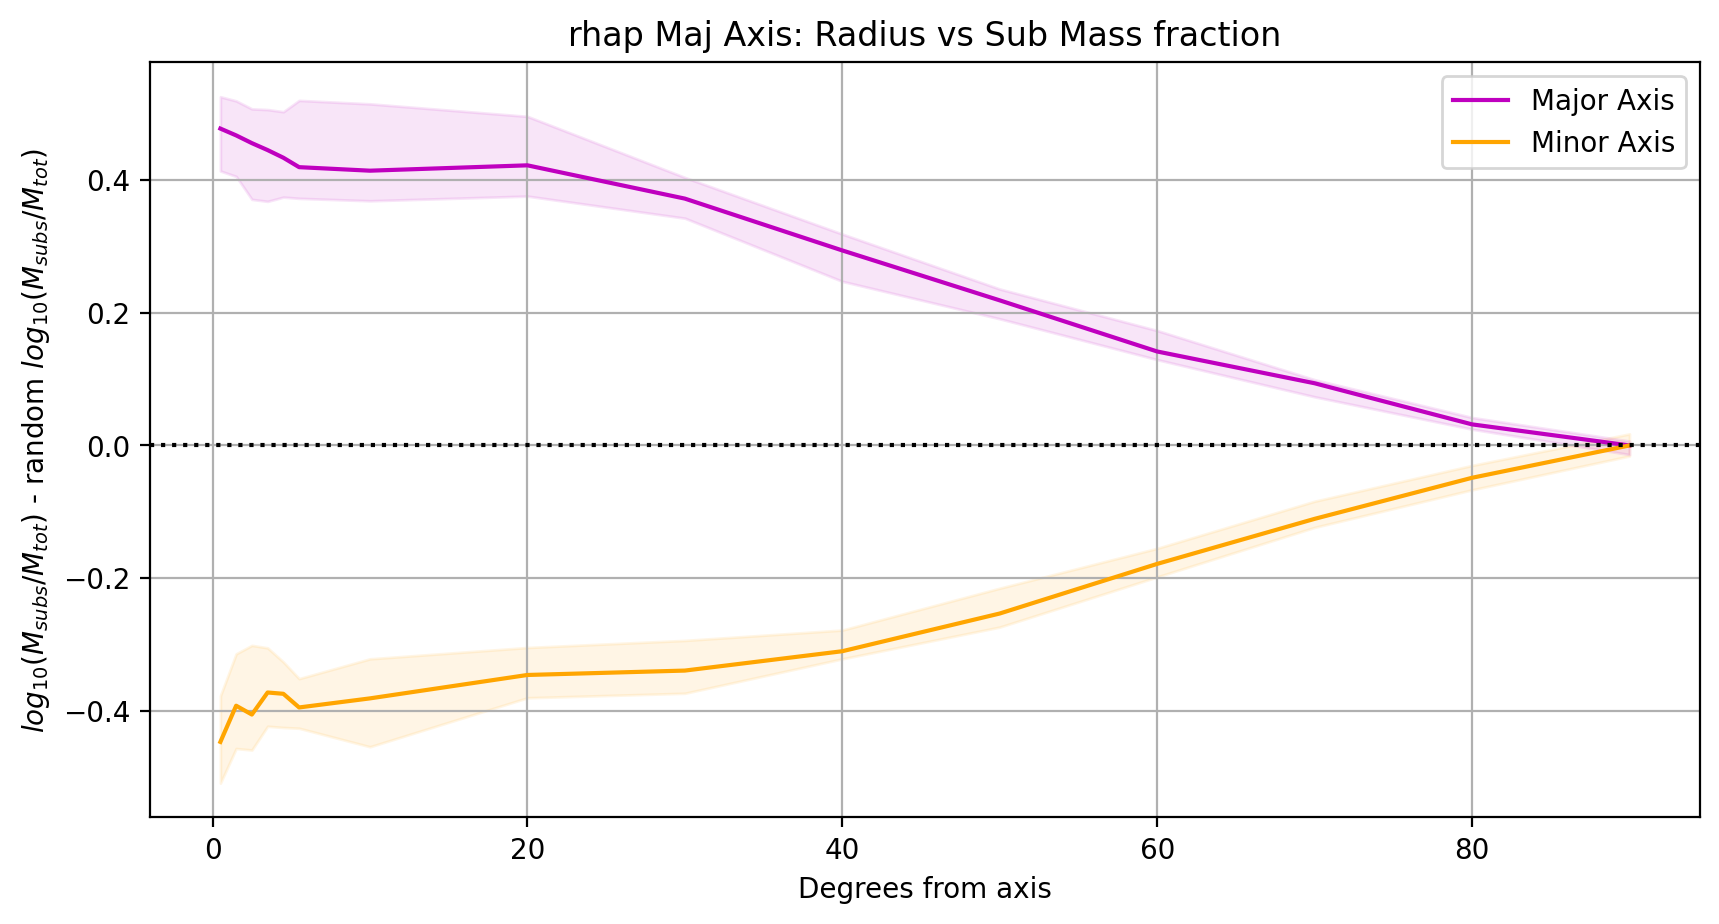

In [58]:
plt.figure(figsize=[10,5],dpi=100)
#ang_radius_cut = [10.0, 20.0, 30.0, 40.0 ,50.0 ,60.0 ,70.0 ,80.0 ,90.0]
ang_radius_cut = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 10.0, 20.0, 30.0, 40.0 ,50.0 ,60.0 ,70.0 ,80.0 ,90.0]
plt.plot(ang_radius_cut, np.log10(rhap_ang_med_mass_frac_A_2)-np.log10(rhap_ang_med_mass_frac_rand_2),label='Major Axis',c='m')
plt.plot(ang_radius_cut, np.log10(rhap_ang_med_mass_frac_C_2)-np.log10(rhap_ang_med_mass_frac_rand_2),label='Minor Axis',c='orange')

plt.axhline(0,c='black',linestyle=':')

for i in range(1):
    rhap_A_ang_err = np.log10(bs_mass_frac_err_2(rhap_ang_mass_frac_A_2,100,95,p1=4.55,p2=95.45))
    rhap_C_ang_err = np.log10(bs_mass_frac_err_2(rhap_ang_mass_frac_C_2,100,95,p1=4.55,p2=95.45))
    rhap_rand_ang_err = np.log10(bs_mass_frac_err_2(rhap_ang_mass_frac_rand_2,100,int(95*5),p1=4.55,p2=95.45))-np.log10(rhap_ang_med_mass_frac_rand_2)
    plt.fill_between(ang_radius_cut, rhap_C_ang_err[0]-np.log10((rhap_ang_med_mass_frac_rand_2)),rhap_C_ang_err[1]-np.log10((rhap_ang_med_mass_frac_rand_2)),color='orange',alpha=0.1)
    #plt.fill_between(ang_radius_cut, rhap_rand_ang_err[0],rhap_rand_ang_err[1],color='b',alpha=0.1)
    plt.fill_between(ang_radius_cut, rhap_A_ang_err[0]-np.log10((rhap_ang_med_mass_frac_rand_2)),rhap_A_ang_err[1]-np.log10((rhap_ang_med_mass_frac_rand_2)),color='m',alpha=0.1)

#plt.fill_between(ang_radius_cut, np.log10(rhap_ang_mass_frac_err_1sig[0])-np.log10(rhap_ang_med_mass_frac_rand),np.log10(rhap_ang_mass_frac_err_1sig[1])-np.log10(rhap_ang_med_mass_frac_rand),color='b',alpha=0.3)
plt.xlabel('Degrees from axis')
plt.ylabel('$log_{10}(M_{subs}/M_{tot}$) - random $log_{10}(M_{subs}/M_{tot}$)')
plt.title("rhap Maj Axis: Radius vs Sub Mass fraction")
plt.grid()
plt.legend()
plt.savefig('rhap_angle_v_sub_mass_frac.png')
plt.show()

In [225]:
h=15
rhap_sub_j = np.load('rhap_sub_js/{}_sub_js.npy'.format(rhap_halo_names[h]))
rhap_sub_m = np.load('rhap_sub_mass_2/{}_sub_mass_2.npy'.format(rhap_halo_names[h]))
rhap_sub_pos = np.load('rhap_sub_pos_2/{}_sub_pos_2.npy'.format(rhap_halo_names[h]))

rhap_sub_vel = np.load('rhap_sub_vel/{}_sub_vel.npy'.format(rhap_halo_names[h]))
rhap_sub_vel_set = rhap_sub_vel[np.argsort(rhap_sub_m)][0:-100]
rhap_sub_m_set = rhap_sub_m[np.argsort(rhap_sub_m)][0:-100]
rhap_sub_vel_set2 = rhap_sub_vel[np.argsort(rhap_sub_m)][-100:]

rhap_sub_j_set = rhap_sub_j[np.argsort(rhap_sub_m)][0:-100]
rhap_sub_j_set2 = rhap_sub_j[np.argsort(rhap_sub_m)][-100:]

rhap_sub_j2 = (rhap_sub_m*np.cross(rhap_sub_pos,rhap_sub_vel).T).T
rhap_sub_host_js = get_angles_1vect(rhap_sub_j,j_rhap_host.T[h],len(rhap_sub_j))


In [204]:
from mpl_toolkits.mplot3d import Axes3D

In [226]:
%matplotlib
h = 15

X = np.arange(-5., 5, 0.5)
Y = np.arange(-5., 5, 0.5)
X, Y = np.meshgrid(X, Y)
Z = np.zeros((len(X),len(Y)))

new_pos = transform(rhap_sub_pos,rhap_host_v_arr[h])

au = np.dot(rhap_host_v_arr[h].T,rhap_host_v_arr[h])[0]*5
av = np.dot(rhap_host_v_arr[h].T,rhap_host_v_arr[h])[1]*5
aw =np.dot(rhap_host_v_arr[h].T,rhap_host_v_arr[h])[2]*5

u3 = (new_pos[0])#[np.argsort(sub_mass[h])]
v3 = (new_pos[1])#[np.argsort(sub_mass[h])]
w3 = (new_pos[2])#[np.argsort(sub_mass[h])]

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.quiver(0., 0., 0., au, av, aw, length=1., normalize=False, color='black',linewidth=1,arrow_length_ratio=0.0,linestyle=':')
ax.quiver(0., 0., 0., -au, -av, -aw, length=1., normalize=False, color='black',linewidth=1,arrow_length_ratio=0.0,linestyle=':')

ax.scatter(0., 0., 0., color='red')
ax.scatter(u3, v3, w3, s = rhap_sub_m/1e11)
ax.plot_surface(X, Y, Z, color='black',
                       linewidth=0, antialiased=False,alpha=0.1)

ax.set_xlabel('$A$', fontsize=12)
ax.set_ylabel('$B$', fontsize=12)
ax.set_zlabel('$C$', fontsize=12)
plt.legend()
plt.show()

/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_3033/3137764939.py:20: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
No handles with labels found to put in legend.


Using matplotlib backend: MacOSX


In [1589]:
%matplotlib
hu = j_rhap_host.T[h][0]/1e18
hv = j_rhap_host.T[h][1]/1e18
hw = j_rhap_host.T[h][2]/1e18

au = rhap_A_hosts.T[h][0]/50
av = rhap_A_hosts.T[h][1]/50
aw = rhap_A_hosts.T[h][2]/50

x2 = np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][-15:]))
y2= np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][-15:]))
z2 = np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][-15:]))

u2 = rhap_sub_j.T[0][np.argsort(rhap_sub_m)][-15:]/1e16
v2 = rhap_sub_j.T[1][np.argsort(rhap_sub_m)][-15:]/1e16
w2 = rhap_sub_j.T[2][np.argsort(rhap_sub_m)][-15:]/1e16

u5 = rhap_sub_vel.T[0][np.argsort(rhap_sub_m)][-15:]/1e16
v5 = rhap_sub_vel.T[1][np.argsort(rhap_sub_m)][-15:]/1e16
w5 = rhap_sub_vel.T[2][np.argsort(rhap_sub_m)][-15:]/1e16

u3 = rhap_sub_pos.T[0][np.argsort(rhap_sub_m)][-15:]
v3 = rhap_sub_pos.T[1][np.argsort(rhap_sub_m)][-15:]
w3 = rhap_sub_pos.T[2][np.argsort(rhap_sub_m)][-15:]


x2 = np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][:15]))
y2= np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][:15]))
z2 = np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][:15]))

u2 = rhap_sub_j.T[0][np.argsort(rhap_sub_m)][:15]/1e16
v2 = rhap_sub_j.T[1][np.argsort(rhap_sub_m)][:15]/1e16
w2 = rhap_sub_j.T[2][np.argsort(rhap_sub_m)][:15]/1e16

u4 = rhap_sub_vel.T[0][np.argsort(rhap_sub_m)][:15]/1e16
v4 = rhap_sub_vel.T[1][np.argsort(rhap_sub_m)][:15]/1e16
w4 = rhap_sub_vel.T[2][np.argsort(rhap_sub_m)][:15]/1e16

u3 = rhap_sub_pos.T[0][np.argsort(rhap_sub_m)][:15]
v3 = rhap_sub_pos.T[1][np.argsort(rhap_sub_m)][:15]
w3 = rhap_sub_pos.T[2][np.argsort(rhap_sub_m)][:15]

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.quiver(0., 0., 0., hu, hv, hw, length=1., normalize=True, color='red',linewidth=5,label='host')
ax.quiver(0., 0., 0., np.sum(u4), np.sum(v4), np.sum(w4), length=1., normalize=True, color='m',linewidth=5,label='host')
ax.quiver(0., 0., 0., np.sum(u5), np.sum(v5), np.sum(w5), length=1., normalize=True, color='c',linewidth=5,label='host')


ax.quiver(0., 0., 0., au, av, aw, length=1., normalize=False, color='red',linewidth=1,arrow_length_ratio=0.0)
ax.quiver(0., 0., 0., -au, -av, -aw, length=1., normalize=False, color='red',linewidth=1,arrow_length_ratio=0.0)

ax.quiver(u3, v3, w3, u2, v2, w2, length=1., normalize=True,alpha=0.4,arrow_length_ratio=0.05,color='g')
ax.quiver(u3, v3, w3, u4, v4, w4, length=1., normalize=True,alpha=0.4,arrow_length_ratio=0.05,color='m')

ax.scatter(0., 0., 0., color='red')
ax.scatter(u3, v3, w3,)

plt.legend()
plt.show()

Using matplotlib backend: MacOSX


/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_56465/2001500958.py:44: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [73]:
%matplotlib

x2 = np.zeros(len(rhap_sub_j[np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-20]))[0::2]
y2= np.zeros(len(rhap_sub_j[np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-20]))[0::2]
z2 = np.zeros(len(rhap_sub_j[np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-20]))[0::2]

u2 = rhap_sub_j.T[0][np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-20][0::2]
v2 = rhap_sub_j.T[1][np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-20][0::2]
w2 = rhap_sub_j.T[2][np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-20][0::2]

x2 = np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][0:-100]))[0::2]
y2= np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][0:-100]))[0::2]
z2 = np.zeros(len(rhap_sub_j[np.argsort(rhap_sub_m)][0:-100]))[0::2]

u2 = rhap_sub_j.T[0][np.argsort(rhap_sub_m)][0:-100][0::2]
v2 = rhap_sub_j.T[1][np.argsort(rhap_sub_m)][0:-100][0::2]
w2 = rhap_sub_j.T[2][np.argsort(rhap_sub_m)][0:-100][0::2]


x = np.zeros(len(rhap_sub_j))[0::2]
y = np.zeros(len(rhap_sub_j))[0::2]
z = np.zeros(len(rhap_sub_j))[0::2]

u = rhap_sub_j.T[0][0::2]
v = rhap_sub_j.T[1][0::2]
w = rhap_sub_j.T[2][0::2]


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-5.0e15,5.e15)
ax.set_ylim(-5.0e15,5.e15)
ax.set_zlim(-5.0e15,5.e15)
#ax.set_ylim(-1.0,1.)
#ax.set_zlim(-1.0,1.)
hu = j_rhap_host.T[h][0]/200.
hv = j_rhap_host.T[h][1]/200.
hw = j_rhap_host.T[h][2]/200.

au = j_rhap_all.T[h][0]/20.
av = j_rhap_all.T[h][1]/20.
aw = j_rhap_all.T[h][2]/20.

su2 = np.sum(u)/10#j_rhap_subs.T[h][0]/10.
sv2 = np.sum(v)/10#j_rhap_subs.T[h][1]/10.
sw2 = np.sum(w)/10#j_rhap_subs.T[h][2]/10.

su = j_rhap_subs.T[h][0]/10.
sv = j_rhap_subs.T[h][1]/10.
sw = j_rhap_subs.T[h][2]/10.

ax.quiver(0., 0., 0., hu, hv, hw, length=1., normalize=False, color='red',linewidth=5,label='host')
ax.quiver(x2, y2, z2, u2, v2, w2, length=1., normalize=False,alpha=0.2,arrow_length_ratio=0.05,color='g')

ax.quiver(x, y, z, u, v, w, length=1., normalize=False,alpha=0.2,arrow_length_ratio=0.05, color='m')

#ax.quiver(x2, y2, z2, u2, v2, w2, length=1., normalize=False,alpha=0.2,arrow_length_ratio=0.03)
#ax.quiver(0, 0, 0, np.sum(rhap_sub_j.T[0]), np.sum(rhap_sub_j.T[1]), np.sum(rhap_sub_j.T[2]), length=0.05, linewidth=5, normalize=True,color='m')
ax.quiver(0., 0., 0., su, sv, sw, length=1., normalize=False, color='m',linewidth=5,label='tot sub')
ax.quiver(0., 0., 0., su2, sv2, sw2, length=1., normalize=False, color='g',linewidth=5,label='tot sub - 20')

#ax.quiver(0., 0., 0., au, av, aw, length=1., normalize=False, color='g',linewidth=5,label='sub+host')

plt.legend()
plt.show()
#%matplotlib inline

Using matplotlib backend: MacOSX


/var/folders/q3/qkwnggcn0hz9nm0zc4p3drfr0000gn/T/ipykernel_56465/3841397474.py:30: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [360]:
np.sum(rhap_sub_j,axis=0),j_rhap_subs.T[h]

(array([ 1.05306610e+16, -1.89073306e+16, -1.45866984e+16]),
 array([ 1.05306610e+16, -1.89073306e+16, -1.45866984e+16]))

0.6512977262472606
0.5418911010718129
0.28274577602849404
0.5417524748693818
0.3673445443768276
0.782459881262199
0.3332818232968595
0.3583577506775068
0.2525466302673519
0.4035243693312724
0.34228689318861094
0.3373041511932522
0.10827573528316778
0.15934241332941776
0.2509123085420834
0.27743891625615763
0.3504985475254956
1.3850172482261993
0.2903859538589827
0.18405085760447773
0.5257790198062744
0.28815129691791275
0.47246667988767427
0.23715152146989196
0.24399245799389002
0.42490709345022915
0.25260459943623786
0.22751744353886302
0.29603441163094346
0.2127474448014927
0.2586480455052276
0.18707887170519857
0.224059335604274
0.19138493403915635
0.31998629799803086
0.34398834483545315
0.21001978277175165
0.20090685794151827
0.3099470439803476
0.2788600492104526
0.14368027858901242
0.1563702935994433
0.22175640777566086
0.23855788007510698
0.17124114324228906
0.19378024966426566
0.29473660671114976
0.3609760300449417
0.6153198926364833
0.2300988438300699
0.21931172428191165
0.1866

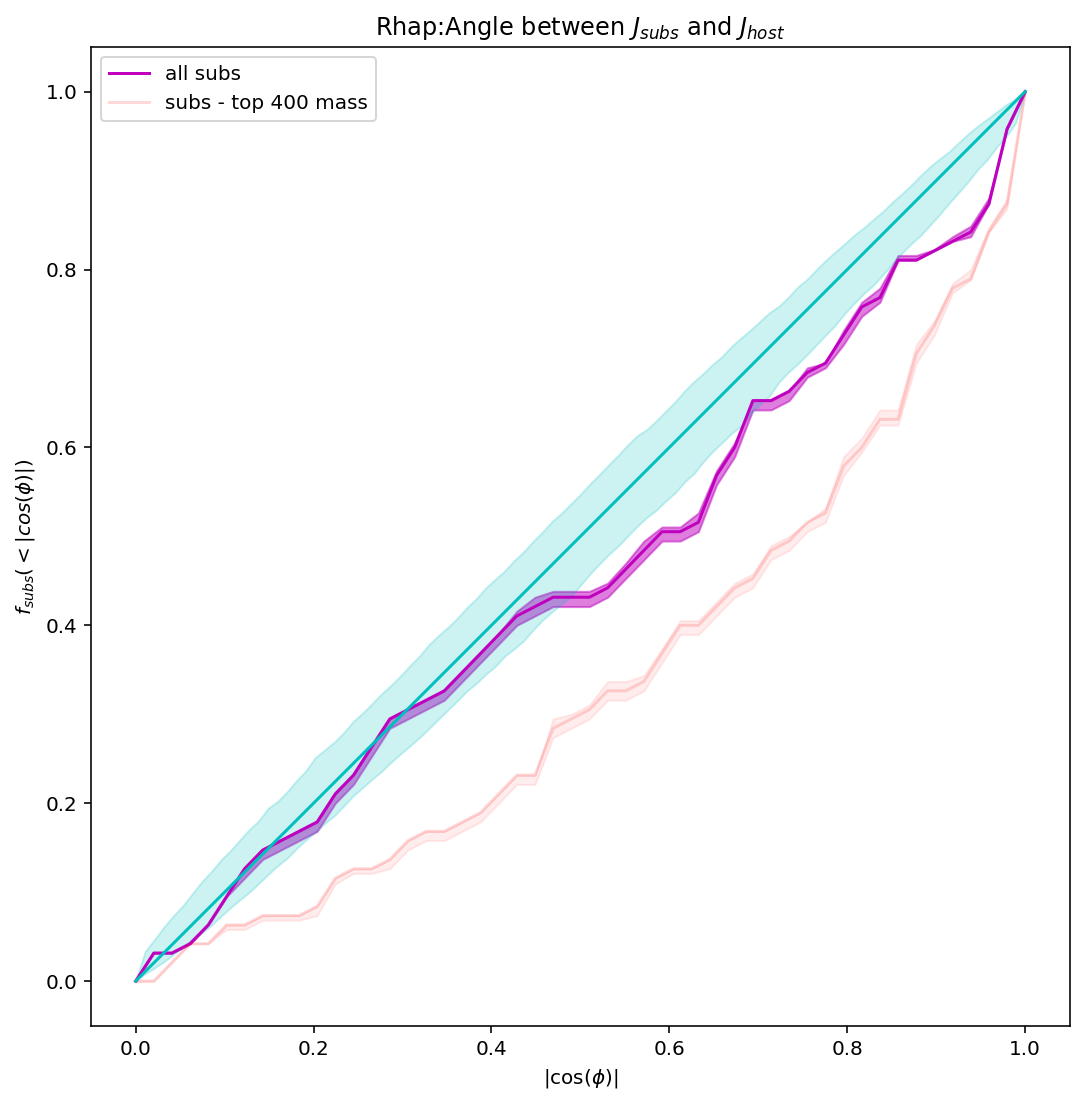

In [74]:
%matplotlib inline
lin_array = np.linspace(0,1,95)
cdfs, iso_std,iso_percentile= MC_err('uniform',95,1000,0,1)

plt.figure(figsize=[9,9])

angs = np.zeros(95)
angs2 = np.zeros(95)
angs3 = np.zeros(95)
angs4 = np.zeros(95)
angs5 = np.zeros(95)
angs6 = np.zeros(95)
angs7 = np.zeros(95)
angs8 = np.zeros(95)

rhap_mass_cut_j = np.zeros(95)
rhap_tot_sub_j = np.zeros(95)
for i in range(95):
    rhap_sub_j = np.load('rhap_sub_js/{}_sub_js.npy'.format(rhap_halo_names[i]))
    rhap_tot_sub_j[i] = np.sum(np.sqrt(np.sum(rhap_sub_j**2,axis=1)))
    rhap_sub_m_i = np.load('rhap_sub_mass_2/{}_sub_mass_2.npy'.format(rhap_halo_names[i]))

    sub_j_set7 = np.sum(rhap_sub_j[np.argsort(rhap_sub_m_i)][0:-400],axis=0)
    angs8[i]+=abs(get_angle(sub_j_set7,j_rhap_host.T[i]))
    rhap_mass_cut_j[i]+=np.sum(np.sqrt(np.sum(rhap_sub_j[np.argsort(rhap_sub_m_i)][0:-400]**2,axis=1)))
    cut_tot = np.sum(rhap_sub_m_i[np.argsort(rhap_sub_m_i)][0:-400])
    frac_lost = np.sum(rhap_sub_m_i)/rhap_host_mvirs[i] - cut_tot/rhap_host_mvirs[i]
    print(frac_lost)
    #sub_j_set_2 = np.sum(rhap_sub_j[np.argsort(abs(np.sum(rhap_sub_j,axis=1)))][0:-100],axis=0)
    angs[i]+=abs(get_angle(np.sum((rhap_sub_j),axis=0),j_rhap_host.T[i]))

plt.plot(get_cumul_angles(angs,num=50)[0],get_cumul_angles(angs,num=50)[1],c='m',label='all subs')#,label='{}'.format(np.log10(mvirs[i])))
err = bs_cumul_plot_err(angs,100, 100)
plt.fill_between(get_cumul_angles(angs,num=50)[0],err[0],err[1],color='m',alpha=0.5)
plt.plot(get_cumul_angles(angs8,num=50)[0],get_cumul_angles(angs8,num=50)[1],c='r',label='subs - top 400 mass',alpha=0.15)#,label='{}'.format(np.log10(mvirs[i])))
err = bs_cumul_plot_err(angs8,100, 100)
plt.fill_between(get_cumul_angles(angs8,num=50)[0],err[0],err[1],color='r',alpha=.075)

#plt.plot(get_cumul_angles(angs3,num=50)[0],get_cumul_angles(angs3,num=50)[1],c='g',label='subs - 100 top j')#,label='{}'.format(np.log10(mvirs[i])))
plt.legend()
plt.plot([0,1],[0,1],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('Rhap:Angle between $J_{subs}$ and $J_{host}$')
plt.show()

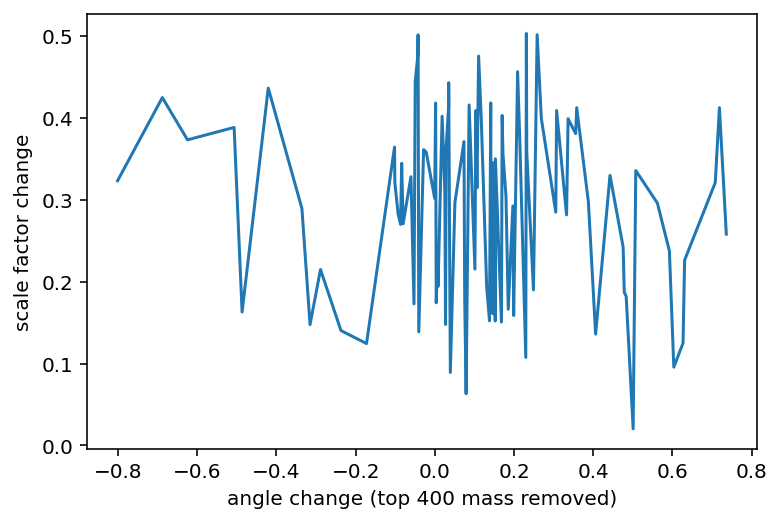

SpearmanrResult(correlation=-0.08437849944008959, pvalue=0.41622738770997136)
spearman err: 0.101


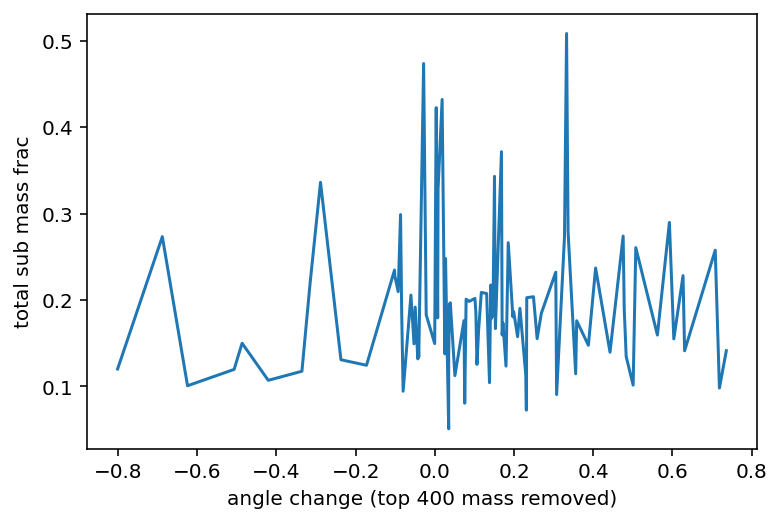

SpearmanrResult(correlation=0.032754759238521836, pvalue=0.7526765345666186)
spearman err: 0.103


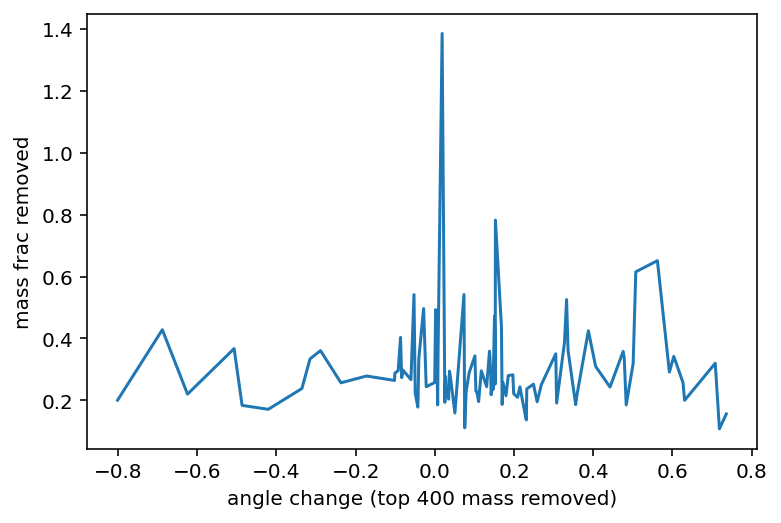

SpearmanrResult(correlation=0.032754759238521836, pvalue=0.7526765345666186)
spearman err: 0.104


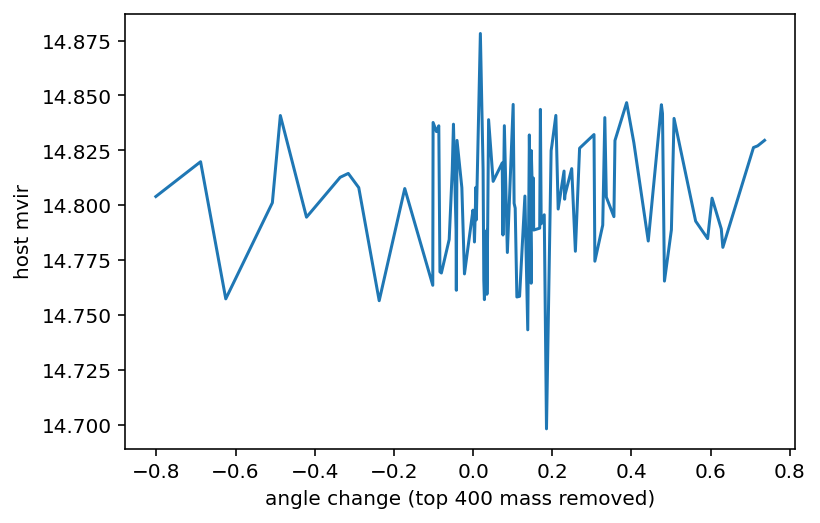

SpearmanrResult(correlation=0.11751860833851471, pvalue=0.2567100444094372)
spearman err: 0.105


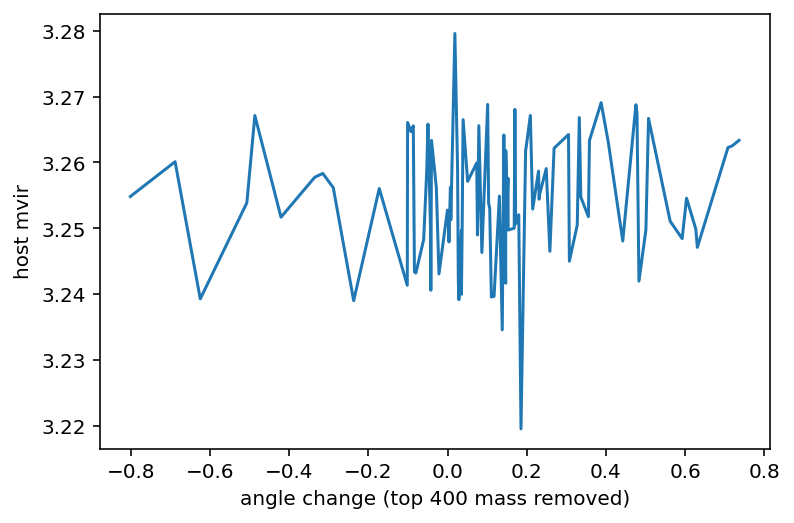

SpearmanrResult(correlation=0.11797312430011199, pvalue=0.2548621099844737)
spearman err: 0.102


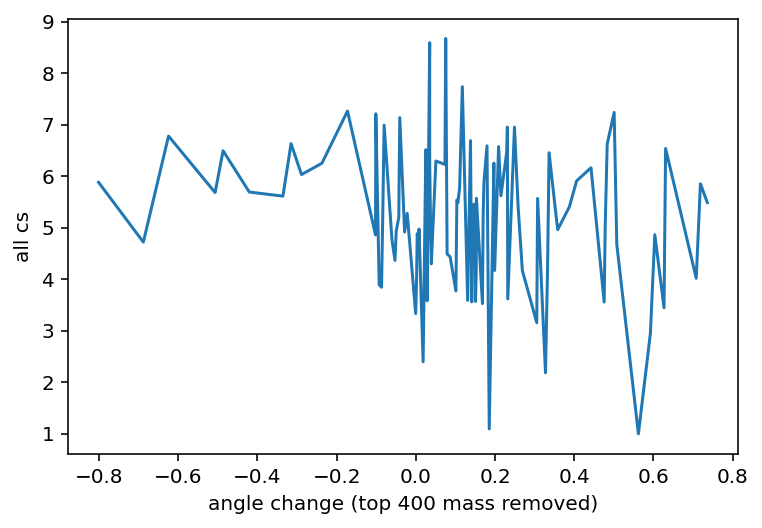

SpearmanrResult(correlation=-0.16005039193729004, pvalue=0.12130174837369273)
spearman err: 0.107


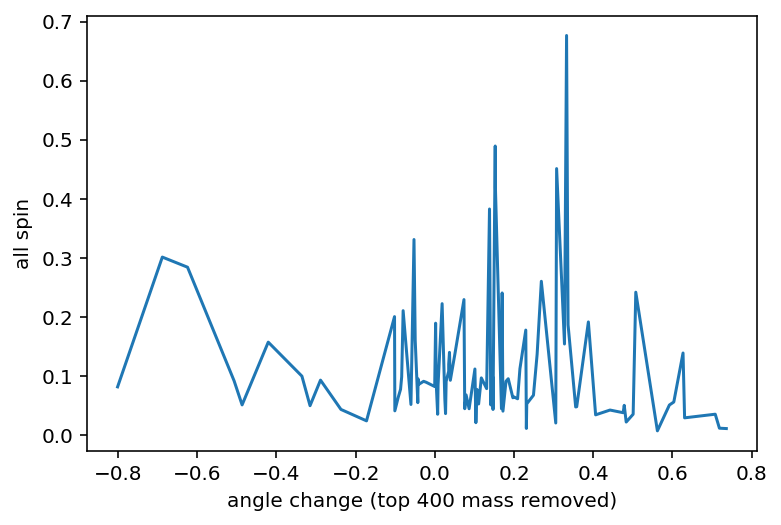

SpearmanrResult(correlation=-0.23663213885778275, pvalue=0.020956616089740716)
spearman err: 0.104


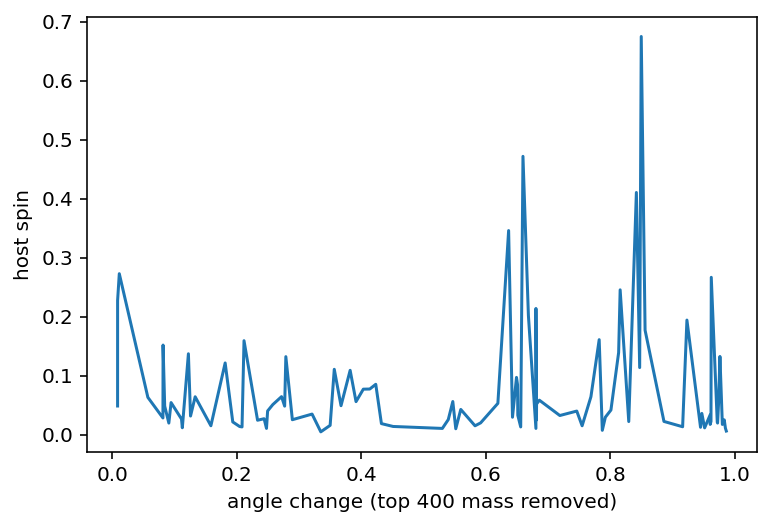

SpearmanrResult(correlation=-0.07312430011198208, pvalue=0.4812858943046342)
spearman err: 0.109


In [1181]:
plt.plot(np.sort((angs8-angs)),(rhap_99_mass_scale-rhap_50_mass_scale)[np.argsort(angs8-angs)])
plt.ylabel('scale factor change')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,rhap_99_mass_scale-rhap_50_mass_scale))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(rhap_99_mass_scale-rhap_50_mass_scale), val_max2 = max(rhap_99_mass_scale-rhap_50_mass_scale))
print('spearman err: {}'.format(round(spear_err,3)))

plt.plot(np.sort((angs8-angs)),(rhap_fs)[np.argsort(angs8-angs)])
plt.ylabel('total sub mass frac')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,rhap_fs))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(rhap_fs), val_max2 = max(rhap_fs))
print('spearman err: {}'.format(round(spear_err,3)))


plt.plot(np.sort((angs8-angs)),(rhap_mass_frac_removed)[np.argsort(angs8-angs)])
plt.ylabel('mass frac removed')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,rhap_fs))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(rhap_mass_frac_removed), val_max2 = max(rhap_mass_frac_removed))
print('spearman err: {}'.format(round(spear_err,3)))


plt.plot(np.sort((angs8-angs)),(np.log10(rhap_host_mvirs))[np.argsort(angs8-angs)])
plt.ylabel('host mvir')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,np.log10(rhap_host_mvirs)))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(np.log10(rhap_host_mvirs)), val_max2 = max(np.log10(rhap_host_mvirs)))
print('spearman err: {}'.format(round(spear_err,3)))

plt.plot(np.sort((angs8-angs)),(np.log10(rhap_host_rvirs))[np.argsort(angs8-angs)])
plt.ylabel('host mvir')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,np.log10(rhap_host_rvirs)))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(np.log10(rhap_host_rvirs)), val_max2 = max(np.log10(rhap_host_rvirs)))
print('spearman err: {}'.format(round(spear_err,3)))

plt.plot(np.sort((angs8-angs)),(rhap_all_cs)[np.argsort(angs8-angs)])
plt.ylabel('all cs')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,rhap_all_cs))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(rhap_all_cs), val_max2 = max(rhap_all_cs))
print('spearman err: {}'.format(round(spear_err,3)))

plt.plot(np.sort((angs8-angs)),(rhap_all_spin)[np.argsort(angs8-angs)])
plt.ylabel('all spin')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,rhap_all_spin))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(rhap_all_spin), val_max2 = max(rhap_all_spin))
print('spearman err: {}'.format(round(spear_err,3)))

plt.plot(np.sort((angs)),(rhap_host_spin)[np.argsort(angs8-angs)])
plt.ylabel('host spin')
plt.xlabel('angle change (top 400 mass removed)')
plt.show()
print(stats.spearmanr(angs8-angs,rhap_host_spin))
spears,spear_err = MC_err('random',n=95,val_min1=min(angs8-angs), val_max1 = max(angs8-angs),val_min2 = min(rhap_host_spin), val_max2 = max(rhap_host_spin))
print('spearman err: {}'.format(round(spear_err,3)))

In [1443]:
lin_array = np.linspace(0,1,95)
cdfs, iso_std,iso_percentile= MC_err('uniform',95,1000,0,1)
rhap_mass_frac_removed = np.zeros(95)
all_angs = []
all_sub_j = []
all_angs2 = []
all_sub_j2 = []

all_angs3 = []
all_sub_j3 = []
all_angs4 = []
all_sub_j4 = []
for indx in range(25):
    rhap_sub_j = np.load('rhap_sub_js/{}_sub_js.npy'.format(rhap_halo_names[indx]))
    rhap_sub_m_i = np.load('rhap_sub_mass_2/{}_sub_mass_2.npy'.format(rhap_halo_names[indx]))
    rhap_sub_vel = np.load('rhap_sub_vel/{}_sub_vel.npy'.format(rhap_halo_names[indx]))
    rhap_sub_pos_2 = np.load('rhap_sub_pos_2/{}_sub_pos_2.npy'.format(rhap_halo_names[indx]))

    angs = np.zeros(len(rhap_sub_j))
    angs3 = np.zeros(len(rhap_sub_j))
    for i in range(len(rhap_sub_j)):
        angs[i]+=abs(get_angle(rhap_sub_j[i],j_rhap_host.T[indx]))
        sub_j = rhap_sub_m_i[i]*np.cross(rhap_sub_pos_2[i],rhap_sub_vel[i])
        angs3[i]+=abs(get_angle(sub_j,j_rhap_host.T[indx]))

    all_angs.append(angs)
    all_angs3.append(angs)
    all_sub_j.append(np.sum(rhap_sub_j,axis=0))
    all_sub_j3.append(np.sum(rhap_sub_m_i*np.cross(rhap_sub_pos_2,rhap_sub_vel).T,axis=1))
    mass_removed = sum(np.sort(rhap_sub_m_i)[-400:])
    rhap_mass_frac_removed[indx]+=mass_removed/rhap_host_mvirs[indx]
    sub_j_set = rhap_sub_j[np.argsort(rhap_sub_m_i)][-400:]
    sub_v_set = rhap_sub_vel[np.argsort(rhap_sub_m_i)][-400:]
    sub_pos_set = rhap_sub_pos_2[np.argsort(rhap_sub_m_i)][-400:]
    sub_mass_set = rhap_sub_m_i[np.argsort(rhap_sub_m_i)][-400:]

    angs2 = np.zeros(len(sub_j_set))
    angs4 = np.zeros(len(sub_j_set))
    for i in range(len(sub_j_set)):
        angs2[i]+=abs(get_angle(sub_j_set[i],j_rhap_host.T[indx]))
        sub_j = sub_mass_set[i]*np.cross(sub_pos_set[i],sub_v_set[i])
        angs4[i]+=abs(get_angle(sub_j,j_rhap_host.T[indx]))
    all_angs2.append(angs2)
    all_angs4.append(angs2)
    all_sub_j2.append(np.sum(sub_j_set,axis=0))
    all_sub_j4.append(np.sum(sub_mass_set*np.cross(sub_pos_set,sub_v_set).T,axis=1))
    #print(abs(get_angle(np.sum(rhap_sub_j,axis=0),j_rhap_host.T[indx])))
    #print(abs(get_angle(np.sum(sub_j_set,axis=0),j_rhap_host.T[indx])))
    #plt.figure(figsize=[1,1])
    a_diff = round(rhap_70_mass_scale[indx],2)
    #plt.plot(get_cumul_angles(angs,num=1500)[0],get_cumul_angles(angs,num=1500)[1],c='c',label='70% mass a = {}'.format(a_diff),linewidth=0.5)#,label='{}'.format(np.log10(mvirs[i])))
    #plt.plot(get_cumul_angles(angs2,num=1500)[0],get_cumul_angles(angs2,num=1500)[1],c='m',label='frac mass removed = {}'.format(round(mass_removed/rhap_host_mvirs[indx],5)),linewidth=0.5)#,label='{}'.format(np.log10(mvirs[i])))
    
    #plt.plot([0.,1.],[0.,1.0],c='c')
    #plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
    #plt.axis('square')
    #plt.xlabel('|cos($\phi$)|')
    #plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
    #plt.title('Rhap:Angle between $J_{subs}$ and $J_{host}$')

    #plt.xlim(0.25,0.75)
    #plt.ylim(0.25,0.75)
    #plt.show()
    

In [1332]:
%matplotlib inline

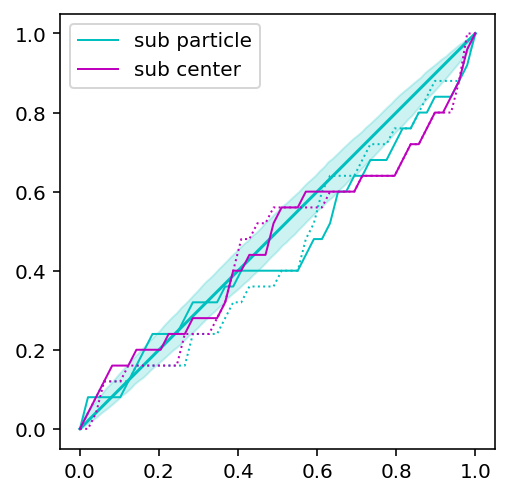

In [1444]:


plt.plot([0.,1.],[0.,1.0],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.plot(get_cumul_angles(abs(get_angles(all_sub_j,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j,j_rhap_host.T[0:25],25)),num=50)[1],c='c',label='sub particle',linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(abs(get_angles(all_sub_j2,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j2,j_rhap_host.T[0:25],25)),num=50)[1],c='c',linestyle=':',linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(abs(get_angles(all_sub_j3,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j3,j_rhap_host.T[0:25],25)),num=50)[1],c='m',linewidth=1.,label='sub center')#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(abs(get_angles(all_sub_j4,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j4,j_rhap_host.T[0:25],25)),num=50)[1],c='m',linewidth=1.,linestyle=':')#,label='{}'.format(np.log10(mvirs[i])))
plt.legend()
plt.show()




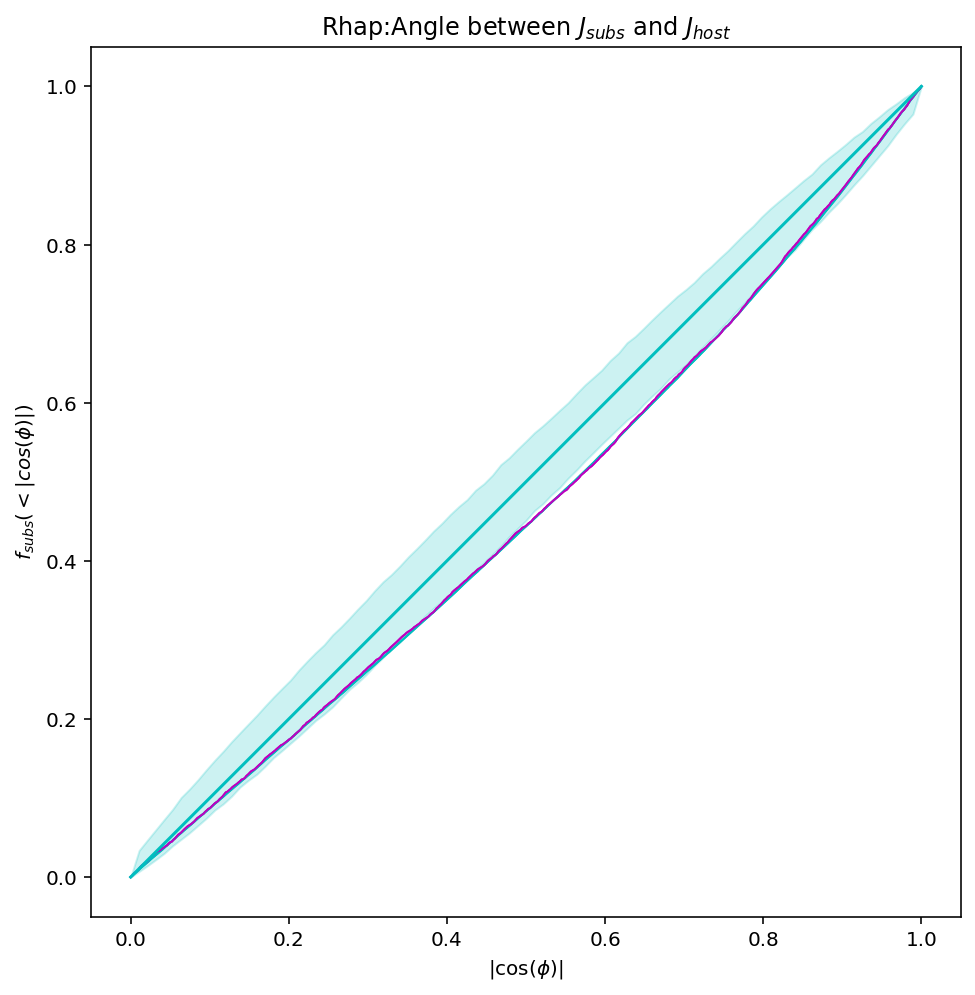

In [1445]:
plt.figure(figsize=[8,8])
plt.plot(get_cumul_angles(np.concatenate(all_angs),num=500)[0],get_cumul_angles(np.concatenate(all_angs),num=500)[1],c='c',label='70% mass a = {}'.format(a_diff),linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(np.concatenate(all_angs2),num=500)[0],get_cumul_angles(np.concatenate(all_angs2),num=500)[1],c='m',label='frac mass removed = {}'.format(round(mass_removed/rhap_host_mvirs[indx],5)),linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))

plt.plot(get_cumul_angles(np.concatenate(all_angs3),num=500)[0],get_cumul_angles(np.concatenate(all_angs3),num=500)[1],c='c',label='70% mass a = {}'.format(a_diff),linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))
plt.plot(get_cumul_angles(np.concatenate(all_angs4),num=500)[0],get_cumul_angles(np.concatenate(all_angs4),num=500)[1],c='m',label='frac mass removed = {}'.format(round(mass_removed/rhap_host_mvirs[indx],5)),linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))


plt.plot([0.,1.],[0.,1.0],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.xlabel('|cos($\phi$)|')
plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
plt.title('Rhap:Angle between $J_{subs}$ and $J_{host}$')

plt.show()

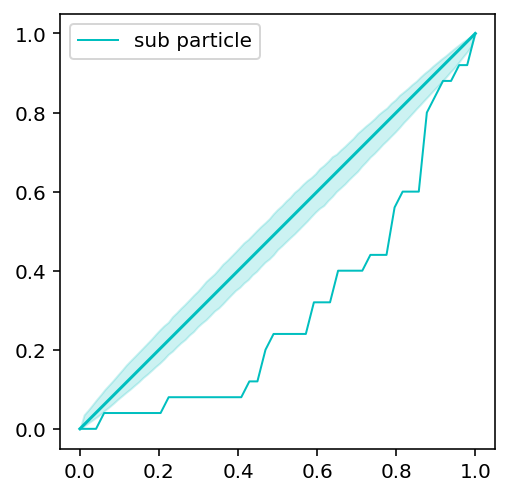

In [1456]:
lin_array = np.linspace(0,1,95)
cdfs, iso_std,iso_percentile= MC_err('uniform',95,1000,0,1)
rhap_mass_frac_removed = np.zeros(95)
all_angs = []
all_sub_j = []
all_angs2 = []
all_sub_j2 = []

all_angs3 = []
all_sub_j3 = []
all_angs4 = []
all_sub_j4 = []
for indx in range(25):
    rhap_sub_j = np.load('rhap_sub_js/{}_sub_js.npy'.format(rhap_halo_names[indx]))
    rhap_sub_m_i = np.load('rhap_sub_mass_2/{}_sub_mass_2.npy'.format(rhap_halo_names[indx]))
    rhap_sub_vel = np.load('rhap_sub_vel/{}_sub_vel.npy'.format(rhap_halo_names[indx]))
    rhap_sub_pos_2 = np.load('rhap_sub_pos_2/{}_sub_pos_2.npy'.format(rhap_halo_names[indx]))

    sub_j_set = rhap_sub_j[np.argsort(rhap_sub_m_i)][0:-400]
    sub_v_set = rhap_sub_vel[np.argsort(rhap_sub_m_i)][0:-400]
    sub_pos_set = rhap_sub_pos_2[np.argsort(rhap_sub_m_i)][0:-400]
    sub_mass_set = rhap_sub_m_i[np.argsort(rhap_sub_m_i)][0:-400]

    angs = np.zeros(len(sub_j_set))
    angs2 = np.zeros(len(sub_j_set))
    for i in range(len(sub_j_set)):
        angs[i]+=abs(get_angle(sub_j_set[i],j_rhap_host.T[indx]))
        sub_j = sub_mass_set[i]*np.cross(sub_pos_set[i],sub_v_set[i])
        angs2[i]+=abs(get_angle(sub_j,j_rhap_host.T[indx]))

    all_angs.append(angs)
    all_angs3.append(angs)
    all_sub_j.append(np.sum(sub_j_set,axis=0))
    all_sub_j3.append(np.sum(rhap_sub_m_i*np.cross(rhap_sub_pos_2,rhap_sub_vel).T,axis=1))
    mass_removed = sum(np.sort(rhap_sub_m_i)[1000:1500])
    rhap_mass_frac_removed[indx]+=mass_removed/rhap_host_mvirs[indx]
    sub_j_set = rhap_sub_j[np.argsort(rhap_sub_m_i)][1000:1400]
    sub_v_set = rhap_sub_vel[np.argsort(rhap_sub_m_i)][1000:1400]
    sub_pos_set = rhap_sub_pos_2[np.argsort(rhap_sub_m_i)][1000:1400]
    sub_mass_set = rhap_sub_m_i[np.argsort(rhap_sub_m_i)][1000:1400]

    angs2 = np.zeros(len(sub_j_set))
    angs4 = np.zeros(len(sub_j_set))
    for i in range(len(sub_j_set)):
        angs2[i]+=abs(get_angle(sub_j_set[i],j_rhap_host.T[indx]))
        sub_j = sub_mass_set[i]*np.cross(sub_pos_set[i],sub_v_set[i])
        angs4[i]+=abs(get_angle(sub_j,j_rhap_host.T[indx]))
    all_angs2.append(angs2)
    all_angs4.append(angs2)
    all_sub_j2.append(np.sum(sub_j_set,axis=0))
    all_sub_j4.append(np.sum(sub_mass_set*np.cross(sub_pos_set,sub_v_set).T,axis=1))
    #print(abs(get_angle(np.sum(rhap_sub_j,axis=0),j_rhap_host.T[indx])))
    #print(abs(get_angle(np.sum(sub_j_set,axis=0),j_rhap_host.T[indx])))
    #plt.figure(figsize=[1,1])
    a_diff = round(rhap_70_mass_scale[indx],2)
    #plt.plot(get_cumul_angles(angs,num=1500)[0],get_cumul_angles(angs,num=1500)[1],c='c',label='70% mass a = {}'.format(a_diff),linewidth=0.5)#,label='{}'.format(np.log10(mvirs[i])))
    #plt.plot(get_cumul_angles(angs2,num=1500)[0],get_cumul_angles(angs2,num=1500)[1],c='m',label='frac mass removed = {}'.format(round(mass_removed/rhap_host_mvirs[indx],5)),linewidth=0.5)#,label='{}'.format(np.log10(mvirs[i])))
    
    #plt.plot([0.,1.],[0.,1.0],c='c')
    #plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
    #plt.axis('square')
    #plt.xlabel('|cos($\phi$)|')
    #plt.ylabel('$f_{subs} (<|cos(\phi)|)$')
    #plt.title('Rhap:Angle between $J_{subs}$ and $J_{host}$')

    #plt.xlim(0.25,0.75)
    #plt.ylim(0.25,0.75)
    #plt.show()

plt.plot([0.,1.],[0.,1.0],c='c')
plt.fill_between(lin_array, iso_percentile[0], iso_percentile[1],color='c',alpha=0.2)
plt.axis('square')
plt.plot(get_cumul_angles(abs(get_angles(all_sub_j,all_sub_j2,len(all_sub_j))),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j,j_rhap_host.T[0:25],25)),num=50)[1],c='c',label='sub particle',linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))
#plt.plot(get_cumul_angles(abs(get_angles(all_sub_j2,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j2,j_rhap_host.T[0:25],25)),num=50)[1],c='c',linestyle=':',linewidth=1.)#,label='{}'.format(np.log10(mvirs[i])))
#plt.plot(get_cumul_angles(abs(get_angles(all_sub_j3,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j3,j_rhap_host.T[0:25],25)),num=50)[1],c='m',linewidth=1.,label='sub center')#,label='{}'.format(np.log10(mvirs[i])))
#plt.plot(get_cumul_angles(abs(get_angles(all_sub_j4,j_rhap_host.T[0:25],25)),num=50)[0],get_cumul_angles(abs(get_angles(all_sub_j4,j_rhap_host.T[0:25],25)),num=50)[1],c='m',linewidth=1.,linestyle=':')#,label='{}'.format(np.log10(mvirs[i])))
plt.legend()
plt.show()

    

In [203]:
all_subs_posx = []
all_subs_posy = []
all_subs_posz = []
all_subs_mass = []
for i in range(45):
    all_subs_posz.append(transform(sub_pos[i],host_v_arr[i])[2])
    all_subs_posx.append(transform(sub_pos[i],host_v_arr[i])[0])
    all_subs_posy.append(transform(sub_pos[i],host_v_arr[i])[1])
    #all_subs_posz.append(sub_pos[i].T[2])
    #all_subs_posx.append(sub_pos[i].T[0])
    #all_subs_posy.append(sub_pos[i].T[1])
    all_subs_mass.append(sub_mass[i])
all_subs_posx = abs(np.concatenate(all_subs_posx))
all_subs_posy = abs(np.concatenate(all_subs_posy))
all_subs_posz = abs(np.concatenate(all_subs_posz))
all_subs_mass = abs(np.concatenate(all_subs_mass))
layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0},)
plot_data = []

for i in range(2,3):
    zdata = all_subs_posz[1::20]
    xdata = all_subs_posx[1::20]
    ydata = all_subs_posy[1::20]
    ax_mean = np.mean(abs(host_v),axis=0)
    #zdata = abs(transform(sub_pos[i],host_v_arr[i])[2])
    #xdata = abs(transform(sub_pos[i],host_v_arr[i])[0])
    #ydata = abs(transform(sub_pos[i],host_v_arr[i])[1])
    
    sub_pos_plot = go.Scatter3d(x=xdata, y=ydata, z=zdata,mode='markers',name='')
    #maj_ax_plot = go.Scatter3d(x=[0,abs(host_v[i][0])], y=[0,abs(host_v[i][1])], z=[0,abs(host_v[i][2])],mode='lines',name='')
    maj_ax_plot = go.Scatter3d(x=[0,ax_mean[0]], y=[0,ax_mean[1]], z=[0,ax_mean[2]],mode='lines',line = dict(color='royalblue', width=4))
    plot_data.append(sub_pos_plot)
    figure = go.Figure(data=plot_data, layout=layout)
    plot_data.append(maj_ax_plot)
    figure = go.Figure(data=plot_data, layout=layout)
    figure.update_traces(marker=dict(size=(np.log10(all_subs_mass)/5)**4,color=np.log10(all_subs_mass),showscale=True))
    #figure.update_traces(marker=dict(size=(np.log10(sub_mass[i])/5)**4,color=np.log10(sub_mass[i]),showscale=True))


figure.update_layout(
        scene = dict(
            xaxis = dict(nticks=4, range=[-.0,0.25],),
                        yaxis = dict(nticks=4, range=[-.0,0.25],),
                        zaxis = dict(nticks=4, range=[-.0,0.25],),),
        width=700,
        margin=dict(r=20, l=10, b=10, t=10))
figure.update_layout(scene_aspectmode='cube')

plotly.offline.iplot(figure)



NameError: name 'go' is not defined